# Figure 6

Temperature and salinity anomalies in depth-longitude space

In [1]:
import numpy as np
import xarray as xr
from glob import glob
import gsw
import cosima_cookbook as cc

import matplotlib.pyplot as plt
import matplotlib.colors as col
from matplotlib.lines import Line2D
import matplotlib.path as mpath

import cartopy.crs as ccrs
import cmocean.cm as cmo

In [2]:
from dask.distributed import Client
client = Client()
client

<Client: 'tcp://127.0.0.1:35475' processes=7 threads=28, memory=251.19 GiB>

In [3]:
import warnings # ignore these warnings
warnings.filterwarnings("ignore", category = FutureWarning)
warnings.filterwarnings("ignore", category = UserWarning)
warnings.filterwarnings("ignore", category = RuntimeWarning)

### Preplotting - data and functions.

Read in depth-longitude anomaly data

In [4]:
control = xr.open_dataset('/g/data/e14/hd4873/access-om2-01/project03_misc_data/shelf_lon-z/shelf_lon-z_MEAN_01deg_jra55v13_ryf9091.nc')
ssp245 = xr.open_dataset('/g/data/e14/hd4873/access-om2-01/project03_misc_data/shelf_lon-z/shelf_lon-z_MEAN_01deg_jra55v13_ryf9091_ssp245.nc')
ssp245mw = xr.open_dataset('/g/data/e14/hd4873/access-om2-01/project03_misc_data/shelf_lon-z/shelf_lon-z_MEAN_01deg_jra55v13_ryf9091_ssp245_mw.nc')
ssp585 = xr.open_dataset('/g/data/e14/hd4873/access-om2-01/project03_misc_data/shelf_lon-z/shelf_lon-z_MEAN_01deg_jra55v13_ryf9091_ssp585.nc')
ssp585mw = xr.open_dataset('/g/data/e14/hd4873/access-om2-01/project03_misc_data/shelf_lon-z/shelf_lon-z_MEAN_01deg_jra55v13_ssp585_windthermalmw.nc')

Add density to datasets. 

In [5]:
ssp245['sig1'] = gsw.density.sigma1(ssp245['salt'], ssp245['temp'])
ssp245mw['sig1'] = gsw.density.sigma1(ssp245mw['salt'], ssp245mw['temp'])
ssp585['sig1'] = gsw.density.sigma1(ssp585['salt'], ssp585['temp'])
ssp585mw['sig1'] = gsw.density.sigma1(ssp585mw['salt'], ssp585mw['temp'])

Read in bottom data

In [6]:
outdir = '/g/data/e14/hd4873/access-om2-01/project03_misc_data/bottom_values/'
ds_ctrl = xr.open_dataset(outdir + 'control_temp_salt.nc')
ds_ssp245mw = xr.open_dataset(outdir + 'ssp245mw_temp_salt.nc')

Calculate bottom anomalies. 

In [7]:
bottom_temp_anom = (ds_ssp245mw.temp - ds_ctrl.temp).mean('time').compute()
bottom_salt_anom = (ds_ssp245mw.salt - ds_ctrl.salt).mean('time').compute()

Miscellaneous plotting data. 

In [8]:
# database for control simulation:
master_session = cc.database.create_session('/g/data/ik11/databases/cosima_master.db')
ctrl = '01deg_jra55v13_ryf9091'

# topography data for plotting:
ht = cc.querying.getvar(ctrl,'ht' , master_session,n=1)
land_mask = np.squeeze(ht.values)*0
land_mask[np.isnan(land_mask)] = 1
land_mask = np.where(land_mask==1,land_mask,np.nan)
land_mask_masked = np.ma.masked_where((land_mask==0),land_mask)
# make land go all the way to -90S:
land_mask_lat = ht.yt_ocean.values
land_mask_lat[0] = -90

Miscellaneous plotting functions. 

In [9]:
def plot_vars(axes, ds, t, scenario):
    cbA = axes[0].pcolormesh(ds.xt_ocean, ds.st_ocean, ds.age.isel(time = t), 
                       cmap = cmo.curl, vmin=-60, vmax=60)
    cbT = axes[1].pcolormesh(ds.xt_ocean, ds.st_ocean, ds.temp.isel(time = t), 
                       cmap = cmo.balance, vmin=-1.5, vmax=1.5)
    cbS = axes[2].pcolormesh(ds.xt_ocean, ds.st_ocean, ds.salt.isel(time = t), 
                       cmap = cmo.delta, vmin=-0.4, vmax=0.4)
    for i, ax in enumerate(axes.flatten()):
        ax.set_ylim([0,1300])
        ax.invert_yaxis()
        ax.text(-270, 1200, f'{scenario}', fontsize=14, fontweight='bold', color='k',
                bbox=dict(facecolor='w', edgecolor='dimgrey', boxstyle='round,pad=0.2'))
        if i > 0:
            ax.set_yticklabels([])

    return cbA, cbT, cbS

def colorbar_horz(cb, axes, label):
    fs = 16
    cbaxes = fig.add_axes(axes)
    cbar = plt.colorbar(cb, cax = cbaxes, orientation = 'horizontal',extend = 'both')
    cbar.set_label(label,fontsize=fs,labelpad=6)
    cbar.ax.tick_params(labelsize=fs, labeltop=True)
    return cbar

def plot_land_mask(axes):
     for i, ax in enumerate(axes.flatten()):
         ax.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors=['k','grey'],linewidths=0.8,)
         ax.contourf(ht.xt_ocean, land_mask_lat,land_mask_masked,colors='dimgrey',zorder=2,)
         ax.set_ylim([-79,-60])
         if i > 0:
            ax.set_yticklabels([])

def plot_vars_timemean(axes, ds, cntl, scenario):
    cntl_temp = cntl.temp.mean(dim='time').where(cntl.temp.mean(dim='time') != 0., np.nan)
    cntl_salt= cntl.salt.mean(dim='time').where(cntl.salt.mean(dim='time') != 0., np.nan)
    cbT = axes[0].pcolormesh(ds.xt_ocean, ds.st_ocean, ds.temp.mean(dim='time') - cntl_temp, 
                       cmap = cmo.balance, vmin=-1.5, vmax=1.5)
    cbS = axes[1].pcolormesh(ds.xt_ocean, ds.st_ocean, ds.salt.mean(dim='time') - cntl_salt, 
                       cmap = cmo.delta, vmin=-0.6, vmax=0.6)
    
    for i, ax in enumerate(axes.flatten()):
        ax.set_ylim([0,1000])
        ax.invert_yaxis()
        ax.text(-274, 900, f'{scenario}', fontsize=16, fontweight='bold', color='dimgrey',
                bbox=dict(facecolor='w', alpha=0.8, edgecolor='dimgrey', boxstyle='round,pad=0.2'))
        if i > 0:
            ax.set_yticklabels([])

    return cbT, cbS

### Plot figure. 

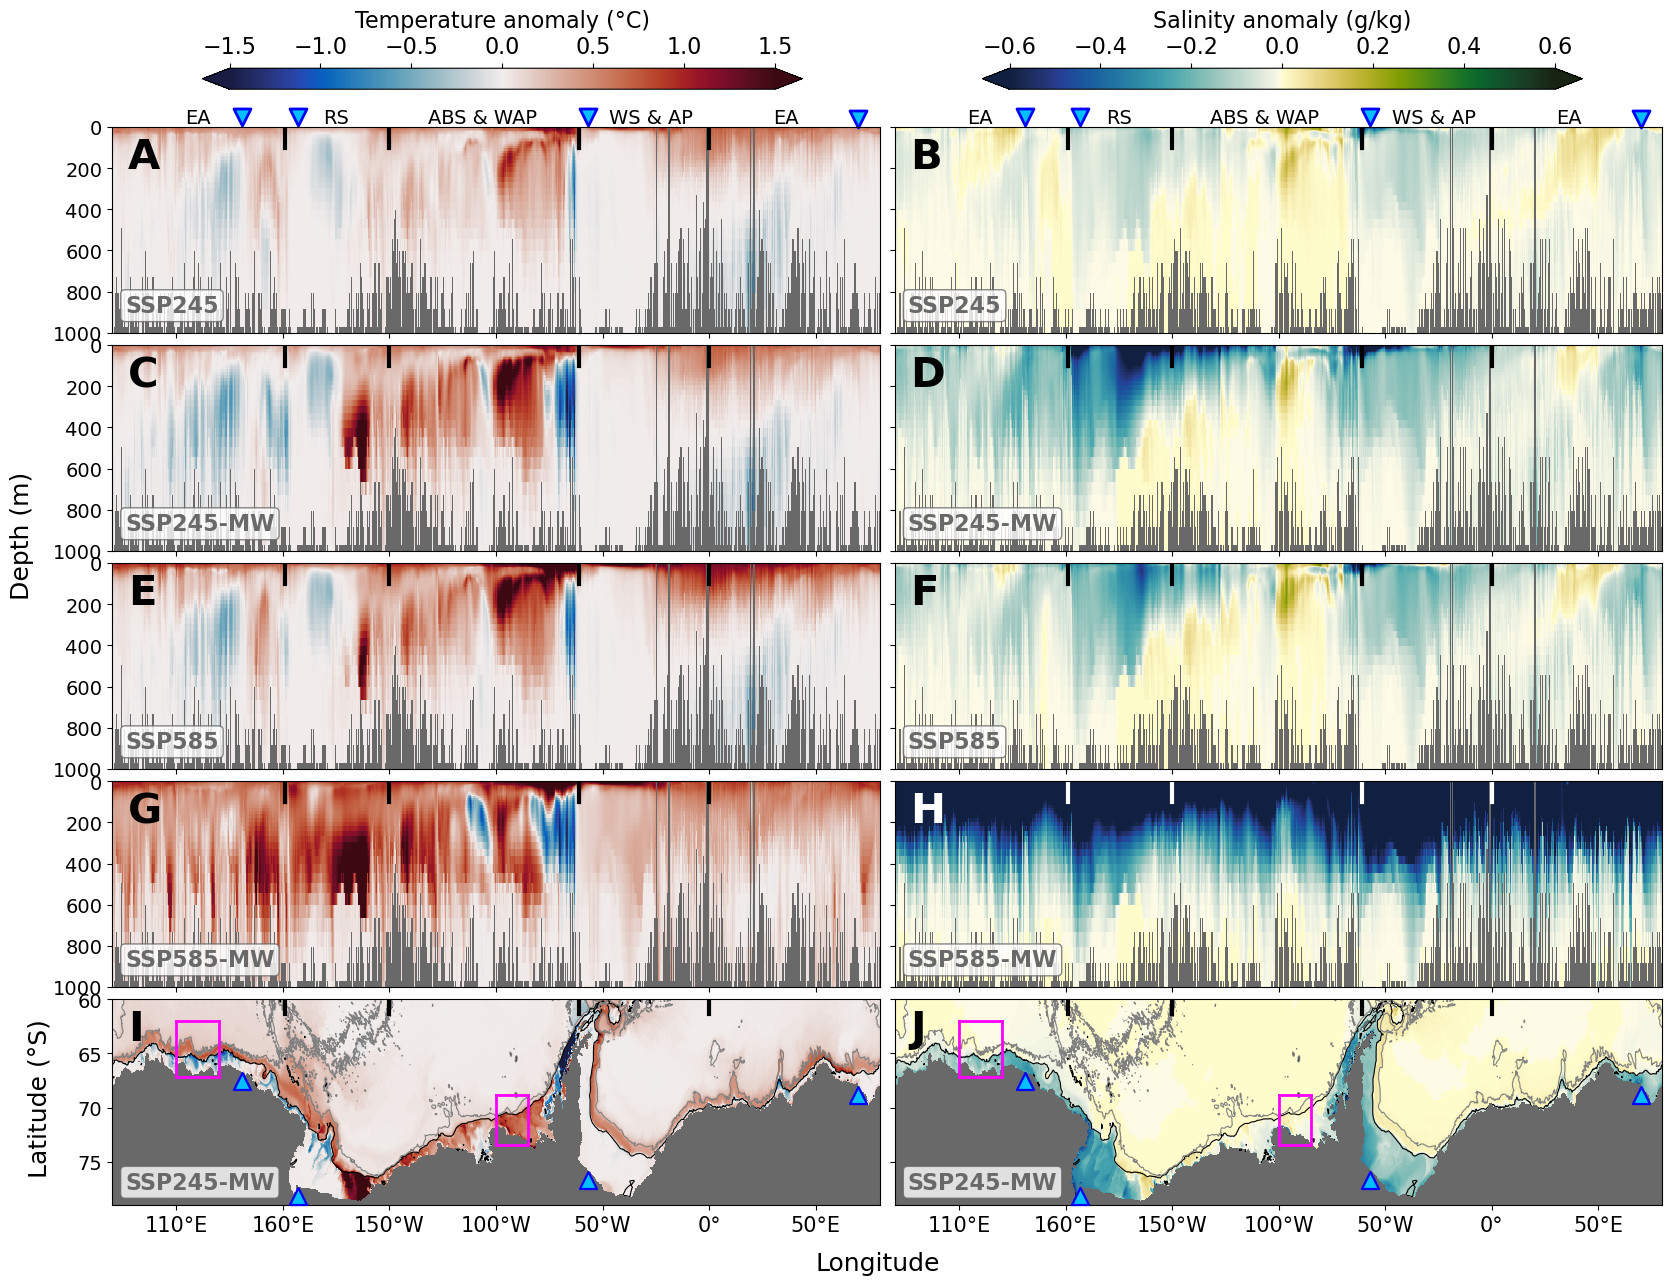

CPU times: user 10.6 s, sys: 3.39 s, total: 14 s
Wall time: 12.8 s


In [10]:
%%time
plt.rcParams.update({'font.size': 14})
fig,axes = plt.subplots(5, 2, figsize=(20, 14), sharex=True, 
                            gridspec_kw = {'wspace':0.02, 'hspace':0.06},height_ratios=[1,1,1,1,1])

# plot depth-longitude anomalies
plot_vars_timemean(axes[0,:], ssp245.sel(time=slice('2160-01','2164-12')), control.sel(time=slice('2160-01','2164-12')), 'SSP245')
plot_vars_timemean(axes[1,:], ssp245mw.sel(time=slice('2160-01','2164-12')), control.sel(time=slice('2160-01','2164-12')), 'SSP245-MW')
plot_vars_timemean(axes[2,:], ssp585.sel(time=slice('2160-01','2164-12')), control.sel(time=slice('2160-01','2164-12')), 'SSP585')
cbT, cbS = plot_vars_timemean(axes[3,:], ssp585mw.sel(time=slice('2160-01','2164-12')), control.sel(time=slice('2160-01','2164-12')), 'SSP585-MW')

#cbar = colorbar_horz(cbT, [0.17, 0.89, 0.3, 0.015],'Temperature anomaly (\u00b0C)')
cbar = colorbar_horz(cbT, [0.17, 0.907, 0.3, 0.015],'Temperature anomaly (\u00b0C)')
cbar.ax.xaxis.set_ticks_position('top')
cbar.ax.xaxis.set_label_position('top')
#cbar = colorbar_horz(cbS, [0.56, 0.89, 0.3, 0.015],'Salinity anomaly (g/kg)')
cbar = colorbar_horz(cbS, [0.56, 0.907, 0.3, 0.015],'Salinity anomaly (g/kg)')
cbar.ax.xaxis.set_ticks_position('top')
cbar.ax.xaxis.set_label_position('top')

# plot spatial maps in I) and J)
plot_land_mask(axes[4,:])
# plot bottom anomalies
axes[4,0].pcolormesh(bottom_temp_anom.xt_ocean, bottom_temp_anom.yt_ocean, bottom_temp_anom, 
                    cmap = cmo.balance, vmin=-1.5, vmax=1.5)
axes[4,1].pcolormesh(bottom_salt_anom.xt_ocean, bottom_salt_anom.yt_ocean, bottom_salt_anom, 
                    cmap = cmo.delta, vmin=-0.6, vmax=0.6)
axes[4,0].text(-274, -77.5, 'SSP245-MW', fontsize=16, fontweight='bold', color='dimgrey',
                bbox=dict(facecolor='w', alpha=0.8, edgecolor='dimgrey', boxstyle='round,pad=0.2'))
axes[4,1].text(-274, -77.5, 'SSP245-MW', fontsize=16, fontweight='bold', color='dimgrey',
                bbox=dict(facecolor='w', alpha=0.8, edgecolor='dimgrey', boxstyle='round,pad=0.2'))
axes[4,0].set_yticks([-75, -70, -65, -60])
axes[4,0].set_yticklabels([75, 70, 65, 60])


# label subplots
labels = ['A','B','C','D','E','F','G','H','I','J']
for i, ax in enumerate(axes.flatten()):
    ax.set_facecolor('dimgrey')
    if i == 7:
        ax.text(0.02, 0.8, f'{labels[i]}',  c='w', fontsize=30, fontweight='bold', transform = ax.transAxes)
    else:
        ax.text(0.02, 0.8, f'{labels[i]}',  c='k', fontsize=30, fontweight='bold', transform = ax.transAxes)

    bounds = [-199, -150, -61, 0]
    if i < 8:
        for b, lon in enumerate(bounds):
            if i == 7:
                ax.plot([lon, lon],[0,100], c='w', lw=3)
            else:
                ax.plot([lon, lon],[0,100], c='k', lw=3)
        if i <= 1:
            tc = 'k'
            ax.text(-246, -20, 'EA',  c=tc, fontsize=14, clip_on=False)
            ax.text(30, -20, 'EA', c=tc,fontsize=14,)
            ax.text(-181, -20, 'RS', c=tc, fontsize=14,)
            ax.text(-132, -20, f'ABS & WAP',  c=tc, fontsize=14)
            ax.text(-47, -20, 'WS & AP', c=tc,fontsize=14)
    else:
        tc = 'k'
        for b, lon in enumerate(bounds):
            ax.plot([lon, lon],[-61.4,-60], c='k', lw=3)
        ax.set_xticklabels(['','110\u00b0E','160\u00b0E','150\u00b0W','100\u00b0W','50\u00b0W', '0\u00b0','50\u00b0E'], 
                           fontsize=15)

# plot axis labels
axes[2,0].text(-328, 150, 'Depth (m)', rotation=90, c=tc,fontsize=18)
axes[4,0].text(50, -85, 'Longitude', c=tc,fontsize=18)
axes[4,0].text(-320, -76, 'Latitude (\u00b0S)', rotation=90, c=tc,fontsize=18)

l,r,b,t,c,ls,lw = -230, -250, -67.2, -62, 'magenta','-', 2
axes[4,0].plot([l,l], [b,t], lw=lw, ls=ls, c=c)
axes[4,0].plot([r,r], [b,t], lw=lw, ls=ls, c=c)
axes[4,0].plot([l,r], [b,b], lw=lw, ls=ls, c=c)
axes[4,0].plot([l,r], [t,t], lw=lw, ls=ls, c=c)
axes[4,1].plot([l,l], [b,t], lw=lw, ls=ls, c=c)
axes[4,1].plot([r,r], [b,t], lw=lw, ls=ls, c=c)
axes[4,1].plot([l,r], [b,b], lw=lw, ls=ls, c=c)
axes[4,1].plot([l,r], [t,t], lw=lw, ls=ls, c=c)

l,r,b,t = -100, -85, -73.5, -68.8
axes[4,0].plot([l,l], [b,t], lw=lw, ls=ls, c=c)
axes[4,0].plot([r,r], [b,t], lw=lw, ls=ls, c=c)
axes[4,0].plot([l,r], [b,b], lw=lw, ls=ls, c=c)
axes[4,0].plot([l,r], [t,t], lw=lw, ls=ls, c=c)
axes[4,1].plot([l,l], [b,t], lw=lw, ls=ls, c=c)
axes[4,1].plot([r,r], [b,t], lw=lw, ls=ls, c=c)
axes[4,1].plot([l,r], [b,b], lw=lw, ls=ls, c=c)
axes[4,1].plot([l,r], [t,t], lw=lw, ls=ls, c=c)


# mark locations of DSW formation sites
for i in range(2):
    axes[0,i].scatter(70, -40, marker='v', s=150, c='deepskyblue', edgecolors='b', linewidths=2, clip_on=False) # Prydz
    axes[0,i].scatter(-219, -50, marker='v', s=150, c='deepskyblue', edgecolors='b', linewidths=2, clip_on=False) # Adelie
    axes[0,i].scatter(-193, -50, marker='v', s=150, c='deepskyblue', edgecolors='b', linewidths=2, clip_on=False) # Ross
    axes[0,i].scatter(-57, -50, marker='v', s=150, c='deepskyblue', edgecolors='b', linewidths=2, clip_on=False) # Weddell

    axes[4,i].scatter(70, -68.8, marker='^', s=150, c='deepskyblue', edgecolors='b', linewidths=1.6, clip_on=False, zorder=10) # Prydz
    axes[4,i].scatter(-219, -67.5, marker='^', s=150, c='deepskyblue', edgecolors='b', linewidths=1.6, clip_on=False, zorder=10) # Adelie
    axes[4,i].scatter(-193, -78.2, marker='^', s=150, c='deepskyblue', edgecolors='b', linewidths=1.6, clip_on=False, zorder=10) # Ross
    axes[4,i].scatter(-57, -76.7, marker='^', s=150, c='deepskyblue', edgecolors='b', linewidths=1.6, clip_on=False, zorder=10) # Weddell

# save figure
# fig.savefig('../figs/Fig06.jpg', dpi=300, bbox_inches='tight')

plt.show()

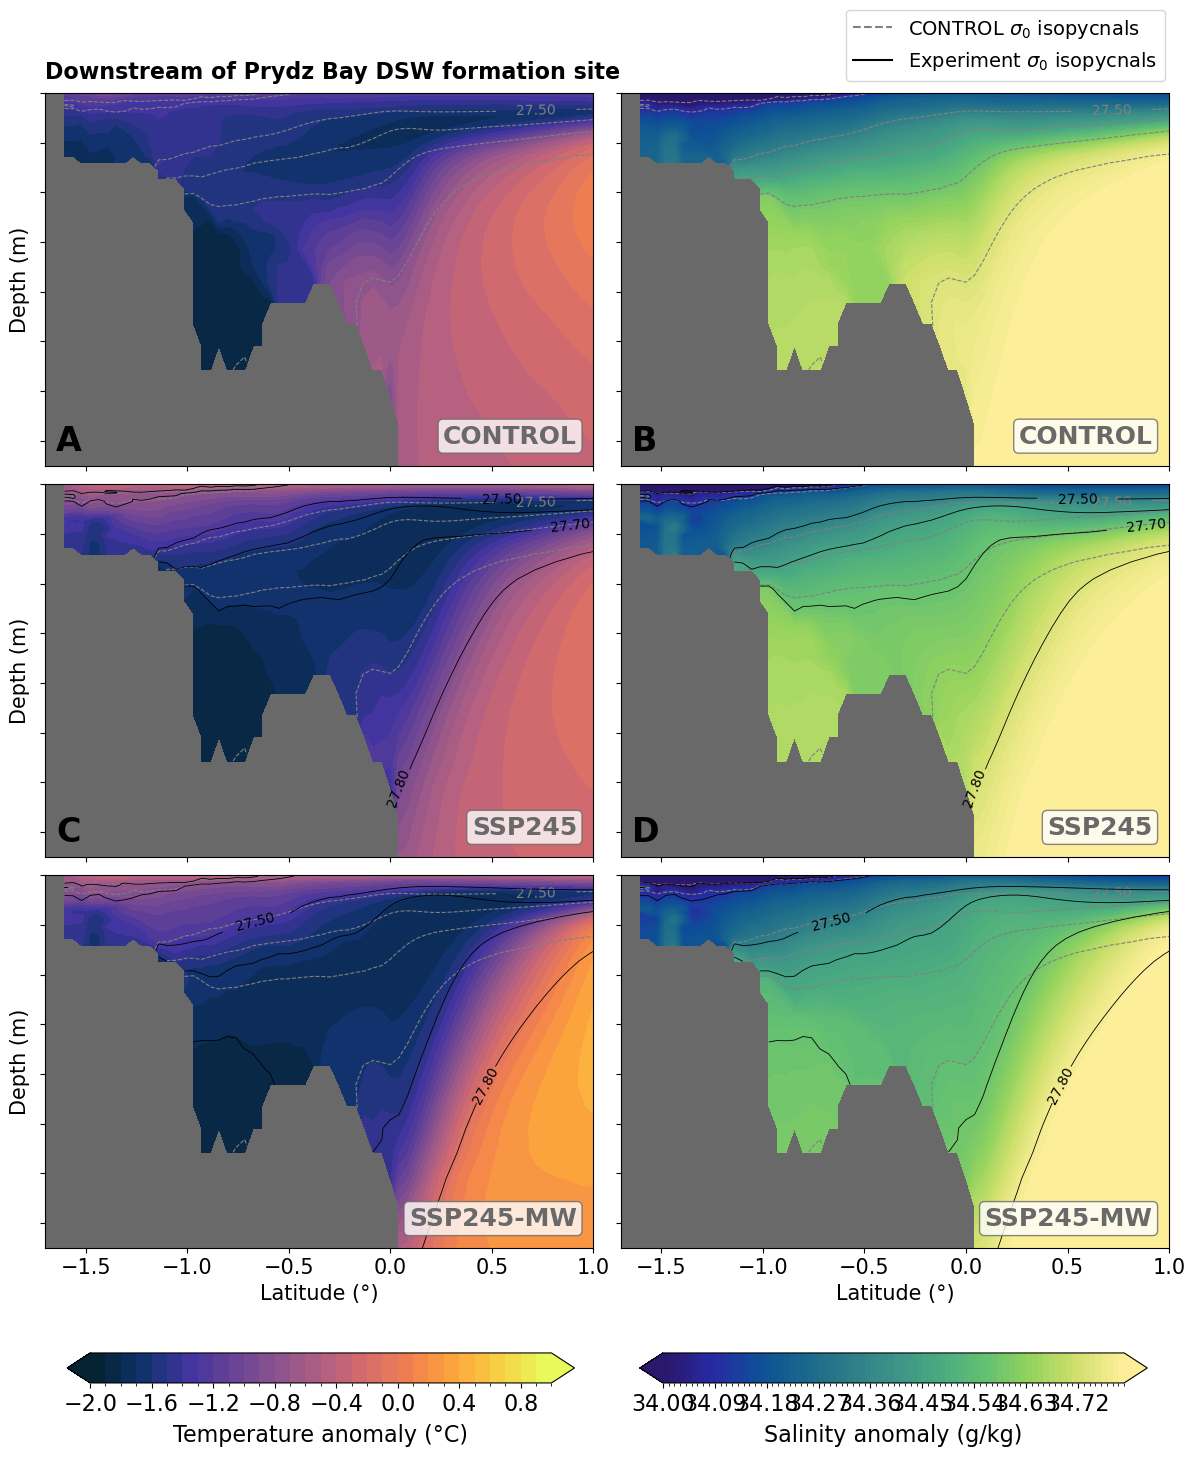

CPU times: user 15 s, sys: 17.7 s, total: 32.6 s
Wall time: 45.8 s


In [18]:
%%time
labels = ['A','B','C','D','','','E','F','G','H','I','J','K']
sim_labels = ['CONTROL','CONTROL','SSP245','SSP245','SSP245-MW','SSP245-MW','','']

plt.rcParams.update({'font.size': 15})
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14.5,15), sharex=True,sharey=True)
plt.subplots_adjust(wspace=0.05, hspace=0.05)

for i, ax in enumerate(axes.flatten()):
    ax.set_facecolor('dimgrey')
    ax.text(0.02, 0.04, f'{labels[i]}',  c='k', fontsize=24, ha='left', fontweight='bold', transform=ax.transAxes)
    ax.text(0.97, 0.06, f'{np.tile(sim_labels,2)[i]}', fontsize=18, fontweight='bold', color='dimgrey', ha='right', transform=ax.transAxes,
            bbox=dict(facecolor='w', alpha=0.8, edgecolor='dimgrey', boxstyle='round,pad=0.2'), zorder=3)

for i, ax in enumerate(axes[:,0]):
    ax.set_ylabel('Depth (m)')
for i, ax in enumerate(axes[:,1]):
    ax.set_yticklabels([])
#for i, ax in enumerate(axes[0,:]):
#    ax.set_xticklabels([])

axes[0,0].text(0.0, 1.04, 'Downstream of Prydz Bay DSW formation site',  c='k', fontsize=16, fontweight='bold',transform=axes[0,0].transAxes)


# EAST ANTARCTICA
l1,l2,l3 = 50,30,80
# temp
control_mean_T = control_temp.where(((control_temp.xt_ocean < l1) & (control_temp.xt_ocean >= l2) | (control_temp.xt_ocean  > l3)), np.nan).mean('xt_ocean')
ssp245_mean_T = ssp245_temp.where(((control_temp.xt_ocean < l1) & (control_temp.xt_ocean >= l2) | (control_temp.xt_ocean  > l3)), np.nan).mean('xt_ocean')
ssp245mw_mean_T = ssp245mw_temp.where(((control_temp.xt_ocean < l1) & (control_temp.xt_ocean >= l2) | (control_temp.xt_ocean  > l3)), np.nan).mean('xt_ocean')
# salt
control_mean_S = control_salt.where(((control_salt.xt_ocean < l1) & (control_salt.xt_ocean >= l2) | (control_salt.xt_ocean  > l3)), np.nan).mean('xt_ocean')
ssp245_mean_S = ssp245_salt.where(((control_salt.xt_ocean < l1) & (control_salt.xt_ocean >= l2) | (control_salt.xt_ocean  > l3)), np.nan).mean('xt_ocean')
ssp245mw_mean_S = ssp245mw_salt.where(((control_salt.xt_ocean < l1) & (control_salt.xt_ocean >= l2) | (control_salt.xt_ocean  > l3)), np.nan).mean('xt_ocean')
# sigma1
control_mean_sig1 = control_sig1.where(((control_temp.xt_ocean < l1) & (control_temp.xt_ocean >= l2) | (control_temp.xt_ocean  > l3)), np.nan).mean('xt_ocean')
ssp245_mean_sig1 = ssp245_sig1.where(((control_temp.xt_ocean < l1) & (control_temp.xt_ocean >= l2) | (control_temp.xt_ocean  > l3)), np.nan).mean('xt_ocean')
ssp245mw_mean_sig1 = ssp245mw_sig1.where(((control_temp.xt_ocean < l1) & (control_temp.xt_ocean >= l2) | (control_temp.xt_ocean  > l3)), np.nan).mean('xt_ocean')
# sigma0
control_mean_sig0 = control_sig0.where(((control_temp.xt_ocean < l1) & (control_temp.xt_ocean >= l2) | (control_temp.xt_ocean  > l3)), np.nan).mean('xt_ocean')
ssp245_mean_sig0 = ssp245_sig0.where(((control_temp.xt_ocean < l1) & (control_temp.xt_ocean >= l2) | (control_temp.xt_ocean  > l3)), np.nan).mean('xt_ocean')
ssp245mw_mean_sig0 = ssp245mw_sig0.where(((control_temp.xt_ocean < l1) & (control_temp.xt_ocean >= l2) | (control_temp.xt_ocean  > l3)), np.nan).mean('xt_ocean')


# plot temperature
x_rel = control_mean_sig0.yt_isobath_rel
y = control_mean_sig0.st_ocean
axes[0,0].contourf(x_rel, y, control_mean_T,
                   cmap=cmap_T, norm=mpl.colors.BoundaryNorm(levels_T,ncolors=cmap_T.N, clip=False), 
                   levels=levels_T, extend='both')
axes[1,0].contourf(x_rel, y, ssp245_mean_T,
                   cmap=cmap_T, norm=mpl.colors.BoundaryNorm(levels_T,ncolors=cmap_T.N, clip=False), 
                   levels=levels_T, extend='both')
cbT = axes[2,0].contourf(x_rel, y, ssp245mw_mean_T,
                   cmap=cmap_T, norm=mpl.colors.BoundaryNorm(levels_T,ncolors=cmap_T.N, clip=False), 
                   levels=levels_T, extend='both')
cbar = colorbar_horz(cbT, [0.14, 0.02, 0.35, 0.02],'Temperature anomaly (\u00b0C)')
#cbar.ax.set_xticks([-1.0, -0.5, 0,0.5,1.0,])
#cbar.ax.set_xticklabels([-2.0,'',-1.0,'',0,'',1.0,'',2.0])

# plot salinity
axes[0,1].contourf(ssp245_mean_S.yt_isobath_rel, ssp245_mean_S.st_ocean, control_mean_S,
                   cmap=cmap_S, norm=mpl.colors.BoundaryNorm(levels_S,ncolors=cmap_S.N, clip=False), 
                   levels=levels_S, extend='both')
axes[1,1].contourf(ssp245_mean_S.yt_isobath_rel, ssp245_mean_S.st_ocean, ssp245_mean_S,
                   cmap=cmap_S, norm=mpl.colors.BoundaryNorm(levels_S,ncolors=cmap_S.N, clip=False), 
                   levels=levels_S, extend='both')
cbS = axes[2,1].contourf(ssp245mw_mean_S.yt_isobath_rel, ssp245mw_mean_S.st_ocean, ssp245mw_mean_S,
                   cmap=cmap_S, norm=mpl.colors.BoundaryNorm(levels_S,ncolors=cmap_S.N, clip=False), 
                   levels=levels_S, extend='both')
cbar = colorbar_horz(cbS, [0.535, 0.02, 0.35, 0.02],'Salinity anomaly (g/kg)')
#cbar.ax.set_xticks([-0.3,-0.2,-0.1,0,0.1,0.2,0.3])


lvls = [27.2, 27.3, 27.5, 27.6, 27.7, 27.8, 27.85, 27.9]
x_rel = control_mean_sig0.yt_isobath_rel
y = control_mean_sig0.st_ocean
# plot control contours
for i, ax in enumerate(axes.flatten()):
    cs = ax.contour(x_rel, y, control_mean_sig0, 
                    levels=lvls, colors='grey', linewidths=0.8, linestyles='--', zorder=2)
    ax.clabel(cs, lvls,use_clabeltext=True, fontsize=10, inline=True, inline_spacing=-15, zorder=2)
# plot SSP245 contours
for i, ax in enumerate(axes[1,:]):
    cs = ax.contour(x_rel[:-200], y, ssp245_mean_sig0[:,:-200], 
                    levels=lvls, colors='k', linewidths=0.6, zorder=2)
    ax.clabel(cs, lvls,use_clabeltext=True, fontsize=10, inline=True, inline_spacing=-15, zorder=2)
# plot SSP245-MW contours
for i, ax in enumerate(axes[2,:]):
    cs = ax.contour(x_rel[:-220], y, ssp245mw_mean_sig0[:,:-220], 
                     levels=lvls, colors='k', linewidths=0.6, zorder=2)
    ax.clabel(cs, lvls,use_clabeltext=True, fontsize=10, inline=True, inline_spacing=-15, zorder=2)

# add legend
line1 = Line2D([0], [0], color='grey', linestyle='--')
line2 = Line2D([0], [0], color='k', linestyle='-')
legend_labels = [f'CONTROL $\sigma_0$ isopycnals', f'Experiment $\sigma_0$ isopycnals']
axes[0,0].legend([line1, line2],legend_labels, bbox_to_anchor=[2.06, 1.25], loc='upper right', fontsize=14, ncols=1, columnspacing=4)


axes[0,0].set_ylim([1500,0])
axes[0,0].set_xlim([-1.7,1])
axes[2,0].set_xlabel('Latitude (\u00b0)')
axes[2,1].set_xlabel('Latitude (\u00b0)')

plt.show()

**Temp and salinity anomalies**

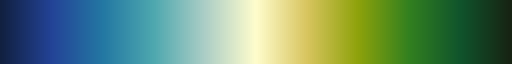

In [46]:
import matplotlib as mpl
from palettable.cmocean.diverging import Balance_11
from palettable.cmocean.diverging import Delta_11

cmap_T = plt.cm.get_cmap(Balance_11.mpl_colormap)
levels_T = np.arange(-1.0, 1.01, 0.05)
cmap_T.set_bad('k')
cmap_T

cmap_S = plt.cm.get_cmap(Delta_11.mpl_colormap)
levels_S = np.arange(-0.3, 0.301, 0.01)
cmap_S.set_bad('k')
cmap_S

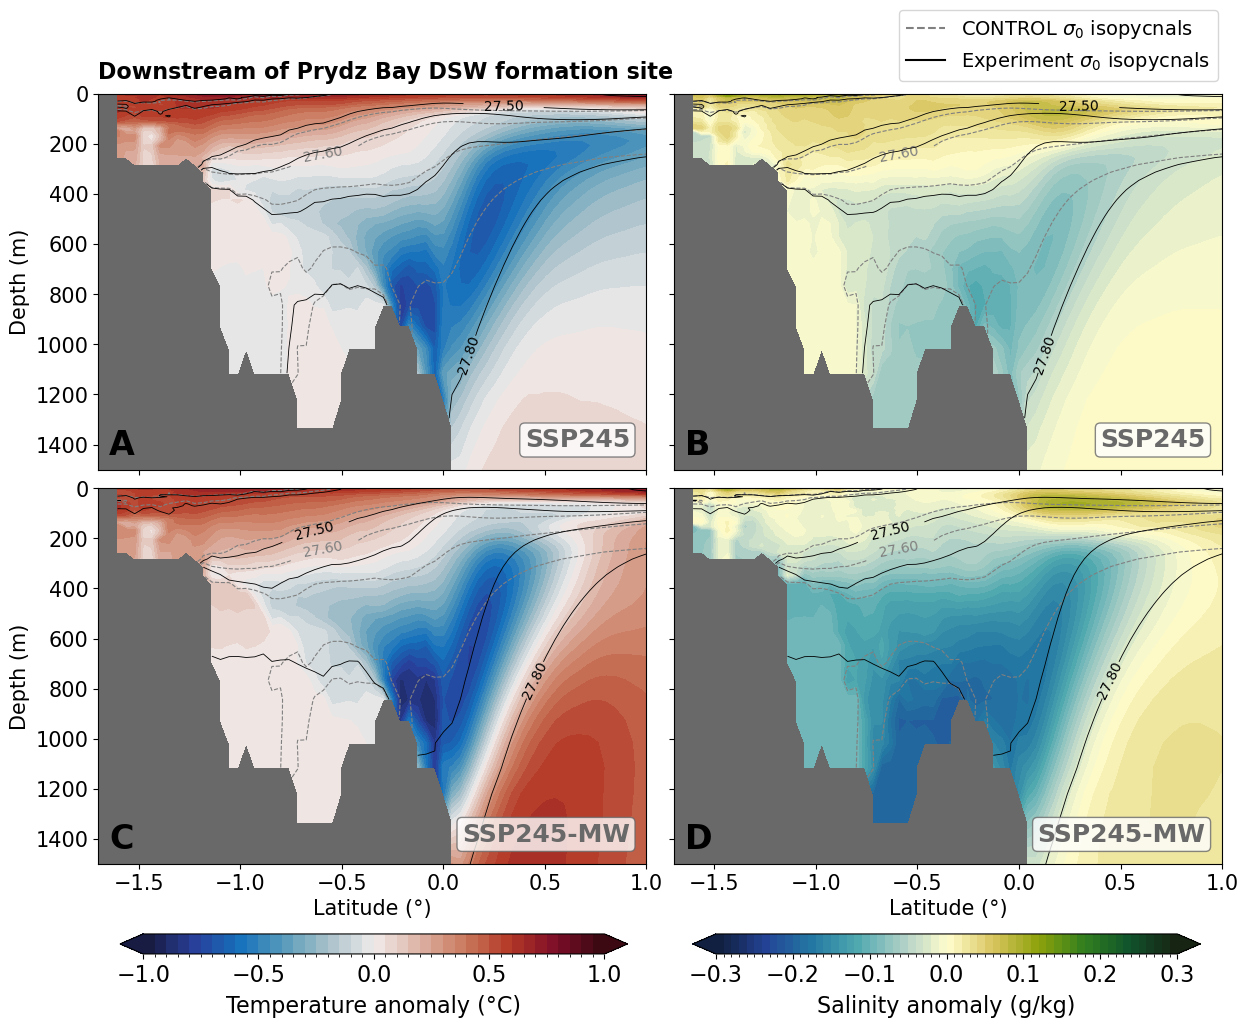

CPU times: user 13 s, sys: 14.9 s, total: 27.9 s
Wall time: 35.1 s


In [47]:
%%time
labels = ['A','B','C','D','','','E','F','G','H','I','J','K']
sim_labels = ['SSP245','SSP245','SSP245-MW','SSP245-MW','','']

plt.rcParams.update({'font.size': 15})
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14.5,10), sharex=True,sharey=True)
plt.subplots_adjust(wspace=0.05, hspace=0.05)

for i, ax in enumerate(axes.flatten()):
    ax.set_facecolor('dimgrey')
    ax.text(0.02, 0.04, f'{labels[i]}',  c='k', fontsize=24, ha='left', fontweight='bold', transform=ax.transAxes)
    ax.text(0.97, 0.06, f'{np.tile(sim_labels,2)[i]}', fontsize=18, fontweight='bold', color='dimgrey', ha='right', transform=ax.transAxes,
            bbox=dict(facecolor='w', alpha=0.8, edgecolor='dimgrey', boxstyle='round,pad=0.2'), zorder=3)

for i, ax in enumerate(axes[:,0]):
    ax.set_ylabel('Depth (m)')
# for i, ax in enumerate(axes[:,1]):
#     ax.set_yticklabels([])
#for i, ax in enumerate(axes[0,:]):
#    ax.set_xticklabels([])

axes[0,0].text(0.0, 1.04, 'Downstream of Prydz Bay DSW formation site',  c='k', fontsize=16, fontweight='bold',transform=axes[0,0].transAxes)


# EAST ANTARCTICA
l1,l2,l3 = 60,30,80
# temp
control_mean_T = control_temp.where(((control_temp.xt_ocean < l1) & (control_temp.xt_ocean >= l2) | (control_temp.xt_ocean  > l3)), np.nan).mean('xt_ocean')
ssp245_mean_T = ssp245_temp.where(((control_temp.xt_ocean < l1) & (control_temp.xt_ocean >= l2) | (control_temp.xt_ocean  > l3)), np.nan).mean('xt_ocean')
ssp245mw_mean_T = ssp245mw_temp.where(((control_temp.xt_ocean < l1) & (control_temp.xt_ocean >= l2) | (control_temp.xt_ocean  > l3)), np.nan).mean('xt_ocean')
# salt
control_mean_S = control_salt.where(((control_salt.xt_ocean < l1) & (control_salt.xt_ocean >= l2) | (control_salt.xt_ocean  > l3)), np.nan).mean('xt_ocean')
ssp245_mean_S = ssp245_salt.where(((control_salt.xt_ocean < l1) & (control_salt.xt_ocean >= l2) | (control_salt.xt_ocean  > l3)), np.nan).mean('xt_ocean')
ssp245mw_mean_S = ssp245mw_salt.where(((control_salt.xt_ocean < l1) & (control_salt.xt_ocean >= l2) | (control_salt.xt_ocean  > l3)), np.nan).mean('xt_ocean')
# sigma1
control_mean_sig1 = control_sig1.where(((control_temp.xt_ocean < l1) & (control_temp.xt_ocean >= l2) | (control_temp.xt_ocean  > l3)), np.nan).mean('xt_ocean')
ssp245_mean_sig1 = ssp245_sig1.where(((control_temp.xt_ocean < l1) & (control_temp.xt_ocean >= l2) | (control_temp.xt_ocean  > l3)), np.nan).mean('xt_ocean')
ssp245mw_mean_sig1 = ssp245mw_sig1.where(((control_temp.xt_ocean < l1) & (control_temp.xt_ocean >= l2) | (control_temp.xt_ocean  > l3)), np.nan).mean('xt_ocean')
# sigma0
control_mean_sig0 = control_sig0.where(((control_temp.xt_ocean < l1) & (control_temp.xt_ocean >= l2) | (control_temp.xt_ocean  > l3)), np.nan).mean('xt_ocean')
ssp245_mean_sig0 = ssp245_sig0.where(((control_temp.xt_ocean < l1) & (control_temp.xt_ocean >= l2) | (control_temp.xt_ocean  > l3)), np.nan).mean('xt_ocean')
ssp245mw_mean_sig0 = ssp245mw_sig0.where(((control_temp.xt_ocean < l1) & (control_temp.xt_ocean >= l2) | (control_temp.xt_ocean  > l3)), np.nan).mean('xt_ocean')


# plot temperature
axes[0,0].contourf(ssp245_mean_T.yt_isobath_rel, ssp245_mean_T.st_ocean, ssp245_mean_T - control_mean_T,
                   cmap=cmap_T, norm=mpl.colors.BoundaryNorm(levels_T,ncolors=cmap_T.N, clip=False), 
                   levels=levels_T, extend='both')
cbT = axes[1,0].contourf(ssp245mw_mean_T.yt_isobath_rel, ssp245mw_mean_T.st_ocean, ssp245mw_mean_T - control_mean_T,
                   cmap=cmap_T, norm=mpl.colors.BoundaryNorm(levels_T,ncolors=cmap_T.N, clip=False), 
                   levels=levels_T, extend='both')
cbar = colorbar_horz(cbT, [0.14, 0.02, 0.35, 0.02],'Temperature anomaly (\u00b0C)')
cbar.ax.set_xticks([-1.0, -0.5, 0,0.5,1.0,])
#cbar.ax.set_xticklabels([-2.0,'',-1.0,'',0,'',1.0,'',2.0])

# plot salinity
axes[0,1].contourf(ssp245_mean_S.yt_isobath_rel, ssp245_mean_S.st_ocean, ssp245_mean_S - control_mean_S,
                   cmap=cmap_S, norm=mpl.colors.BoundaryNorm(levels_S,ncolors=cmap_S.N, clip=False), 
                   levels=levels_S, extend='both')
cbS = axes[1,1].contourf(ssp245mw_mean_S.yt_isobath_rel, ssp245mw_mean_S.st_ocean, ssp245mw_mean_S - control_mean_S,
                   cmap=cmap_S, norm=mpl.colors.BoundaryNorm(levels_S,ncolors=cmap_S.N, clip=False), 
                   levels=levels_S, extend='both')
cbar = colorbar_horz(cbS, [0.535, 0.02, 0.35, 0.02],'Salinity anomaly (g/kg)')
cbar.ax.set_xticks([-0.3,-0.2,-0.1,0,0.1,0.2,0.3])


lvls = [27.2, 27.3, 27.5, 27.6, 27.7, 27.8, 27.85, 27.9]
x_rel = control_mean_sig0.yt_isobath_rel
y = control_mean_sig0.st_ocean
# plot control contours
for i, ax in enumerate(axes.flatten()):
    cs = ax.contour(x_rel, y, control_mean_sig0, 
                    levels=lvls, colors='grey', linewidths=0.8, linestyles='--', zorder=2)
    ax.clabel(cs, lvls,use_clabeltext=True, fontsize=10, inline=True, inline_spacing=-15, zorder=2)
# plot SSP245 contours
for i, ax in enumerate(axes[0,:]):
    cs = ax.contour(x_rel[:-200], y, ssp245_mean_sig0[:,:-200], 
                    levels=lvls, colors='k', linewidths=0.6, zorder=2)
    ax.clabel(cs, lvls,use_clabeltext=True, fontsize=10, inline=True, inline_spacing=-15, zorder=2)
# plot SSP245-MW contours
for i, ax in enumerate(axes[1,:]):
    cs = ax.contour(x_rel[:-220], y, ssp245mw_mean_sig0[:,:-220], 
                     levels=lvls, colors='k', linewidths=0.6, zorder=2)
    ax.clabel(cs, lvls,use_clabeltext=True, fontsize=10, inline=True, inline_spacing=-15, zorder=2)

# add legend
line1 = Line2D([0], [0], color='grey', linestyle='--')
line2 = Line2D([0], [0], color='k', linestyle='-')
legend_labels = [f'CONTROL $\sigma_0$ isopycnals', f'Experiment $\sigma_0$ isopycnals']
axes[0,0].legend([line1, line2],legend_labels, bbox_to_anchor=[2.06, 1.25], loc='upper right', fontsize=14, ncols=1, columnspacing=4)


axes[0,0].set_ylim([1500,0])
axes[0,0].set_xlim([-1.7,1])
axes[1,0].set_xlabel('Latitude (\u00b0)')
axes[1,1].set_xlabel('Latitude (\u00b0)')

plt.show()

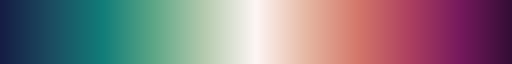

In [19]:
from palettable.cmocean.diverging import Curl_11

cmap_D = plt.cm.get_cmap(Curl_11.mpl_colormap)
levels_D = np.arange(-0.4, 0.401, 0.02)
cmap_D.set_bad('k')
cmap_D

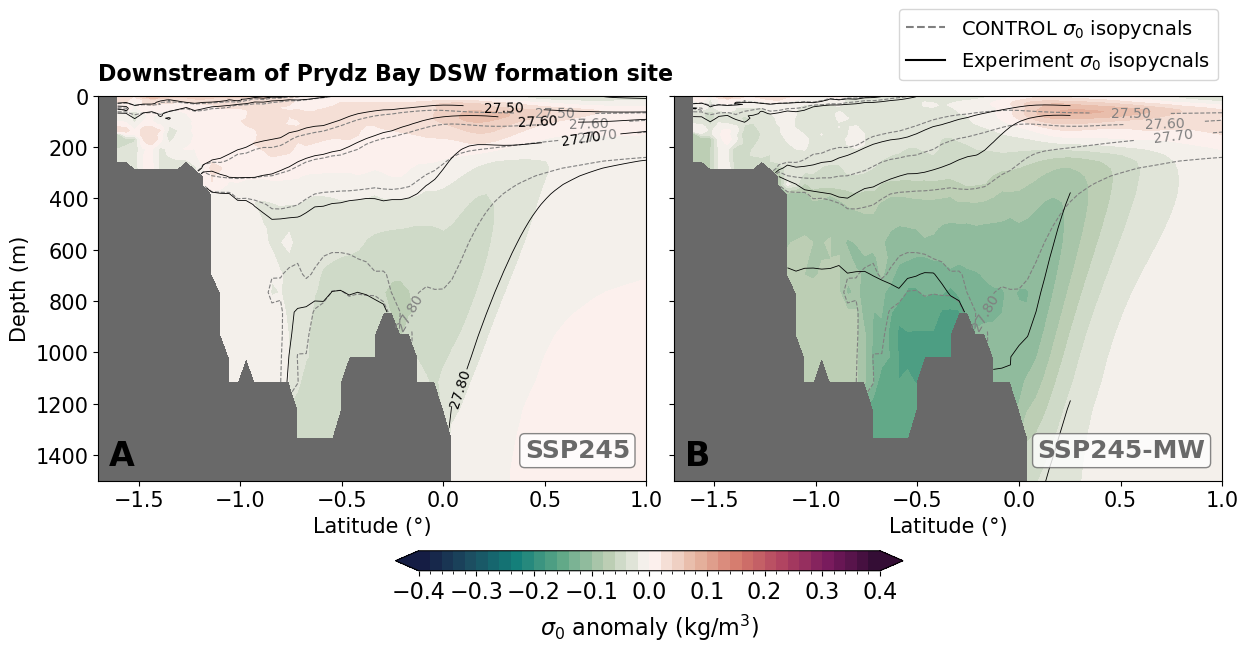

CPU times: user 12.2 s, sys: 7.04 s, total: 19.3 s
Wall time: 17.8 s


In [77]:
%%time
labels = ['A','B','C','D','','','E','F','G','H','I','J','K']
sim_labels = ['SSP245','SSP245-MW',]

plt.rcParams.update({'font.size': 15})
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14.5,5), sharex=True,sharey=True)
plt.subplots_adjust(wspace=0.05, hspace=0.05)

for i, ax in enumerate(axes):
    ax.set_facecolor('dimgrey')
    ax.text(0.02, 0.04, f'{labels[i]}',  c='k', fontsize=24, ha='left', fontweight='bold', transform=ax.transAxes)
    ax.text(0.97, 0.06, f'{np.tile(sim_labels,2)[i]}', fontsize=18, fontweight='bold', color='dimgrey', ha='right', transform=ax.transAxes,
            bbox=dict(facecolor='w', alpha=0.8, edgecolor='dimgrey', boxstyle='round,pad=0.2'), zorder=3)

axes[0].set_ylabel('Depth (m)')
axes[0].text(0.0, 1.04, 'Downstream of Prydz Bay DSW formation site',  c='k', fontsize=16, fontweight='bold',transform=axes[0].transAxes)


# EAST ANTARCTICA
l1,l2,l3 = 60,30,80
# temp
control_mean_T = control_temp.where(((control_temp.xt_ocean < l1) & (control_temp.xt_ocean >= l2) | (control_temp.xt_ocean  > l3)), np.nan).mean('xt_ocean')
ssp245_mean_T = ssp245_temp.where(((control_temp.xt_ocean < l1) & (control_temp.xt_ocean >= l2) | (control_temp.xt_ocean  > l3)), np.nan).mean('xt_ocean')
ssp245mw_mean_T = ssp245mw_temp.where(((control_temp.xt_ocean < l1) & (control_temp.xt_ocean >= l2) | (control_temp.xt_ocean  > l3)), np.nan).mean('xt_ocean')
# salt
control_mean_S = control_salt.where(((control_salt.xt_ocean < l1) & (control_salt.xt_ocean >= l2) | (control_salt.xt_ocean  > l3)), np.nan).mean('xt_ocean')
ssp245_mean_S = ssp245_salt.where(((control_salt.xt_ocean < l1) & (control_salt.xt_ocean >= l2) | (control_salt.xt_ocean  > l3)), np.nan).mean('xt_ocean')
ssp245mw_mean_S = ssp245mw_salt.where(((control_salt.xt_ocean < l1) & (control_salt.xt_ocean >= l2) | (control_salt.xt_ocean  > l3)), np.nan).mean('xt_ocean')
# sigma1
control_mean_sig1 = control_sig1.where(((control_temp.xt_ocean < l1) & (control_temp.xt_ocean >= l2) | (control_temp.xt_ocean  > l3)), np.nan).mean('xt_ocean')
ssp245_mean_sig1 = ssp245_sig1.where(((control_temp.xt_ocean < l1) & (control_temp.xt_ocean >= l2) | (control_temp.xt_ocean  > l3)), np.nan).mean('xt_ocean')
ssp245mw_mean_sig1 = ssp245mw_sig1.where(((control_temp.xt_ocean < l1) & (control_temp.xt_ocean >= l2) | (control_temp.xt_ocean  > l3)), np.nan).mean('xt_ocean')
# sigma0
control_mean_sig0 = control_sig0.where(((control_temp.xt_ocean < l1) & (control_temp.xt_ocean >= l2) | (control_temp.xt_ocean  > l3)), np.nan).mean('xt_ocean')
ssp245_mean_sig0 = ssp245_sig0.where(((control_temp.xt_ocean < l1) & (control_temp.xt_ocean >= l2) | (control_temp.xt_ocean  > l3)), np.nan).mean('xt_ocean')
ssp245mw_mean_sig0 = ssp245mw_sig0.where(((control_temp.xt_ocean < l1) & (control_temp.xt_ocean >= l2) | (control_temp.xt_ocean  > l3)), np.nan).mean('xt_ocean')


# plot density anomaly
axes[0].contourf(ssp245_mean_T.yt_isobath_rel, ssp245_mean_T.st_ocean, ssp245_mean_sig0 - control_mean_sig0,
                   cmap=cmap_D, norm=mpl.colors.BoundaryNorm(levels_D,ncolors=cmap_D.N, clip=False), 
                   levels=levels_D, extend='both')
cbT = axes[1].contourf(ssp245mw_mean_sig0.yt_isobath_rel, ssp245mw_mean_sig0.st_ocean, ssp245mw_mean_sig0 - control_mean_sig0,
                   cmap=cmap_D, norm=mpl.colors.BoundaryNorm(levels_D,ncolors=cmap_D.N, clip=False), 
                   levels=levels_D, extend='both')

cbar = colorbar_horz(cbT, [0.33, -0.07, 0.35, 0.04],'$\sigma_0$ anomaly (kg/m$^3$)')
#cbar.ax.set_xticks([-1.0, -0.5, 0,0.5,1.0,])
#cbar.ax.set_xticklabels([-2.0,'',-1.0,'',0,'',1.0,'',2.0])

lvls = [27.2, 27.3, 27.5, 27.6, 27.7, 27.8, 27.85, 27.9]
x_rel = control_mean_sig0.yt_isobath_rel
y = control_mean_sig0.st_ocean
# plot control contours
for i, ax in enumerate(axes.flatten()):
    cs = ax.contour(x_rel[:-270], y, control_mean_sig0[:,:-270], 
                    levels=lvls, colors='grey', linewidths=0.8, linestyles='--', zorder=2)
    ax.clabel(cs, lvls,use_clabeltext=True, fontsize=10, inline=True, inline_spacing=-15, zorder=2)
# plot SSP245 contours
cs = axes[0].contour(x_rel[:-270], y, ssp245_mean_sig0[:,:-270], 
                levels=lvls, colors='k', linewidths=0.6, zorder=2)
axes[0].clabel(cs, lvls,use_clabeltext=True, fontsize=10, inline=True, inline_spacing=-15, zorder=2)
# plot SSP245-MW contours
cs = axes[1].contour(x_rel[:-300], y, ssp245mw_mean_sig0[:,:-300], 
                 levels=lvls, colors='k', linewidths=0.6, zorder=2)
axes[1].clabel(cs, lvls,use_clabeltext=True, fontsize=10, inline=True, inline_spacing=-15, zorder=2)


# add legend
line1 = Line2D([0], [0], color='grey', linestyle='--')
line2 = Line2D([0], [0], color='k', linestyle='-')
legend_labels = [f'CONTROL $\sigma_0$ isopycnals', f'Experiment $\sigma_0$ isopycnals']
axes[0].legend([line1, line2],legend_labels, bbox_to_anchor=[2.06, 1.25], loc='upper right', fontsize=14, ncols=1, columnspacing=4)


axes[0].set_ylim([1400,0])
axes[0].set_xlim([-1.7,1])
axes[0].set_xlabel('Latitude (\u00b0)')
axes[1].set_xlabel('Latitude (\u00b0)')

plt.show()

At Prydz Bay DSW Formation site. 

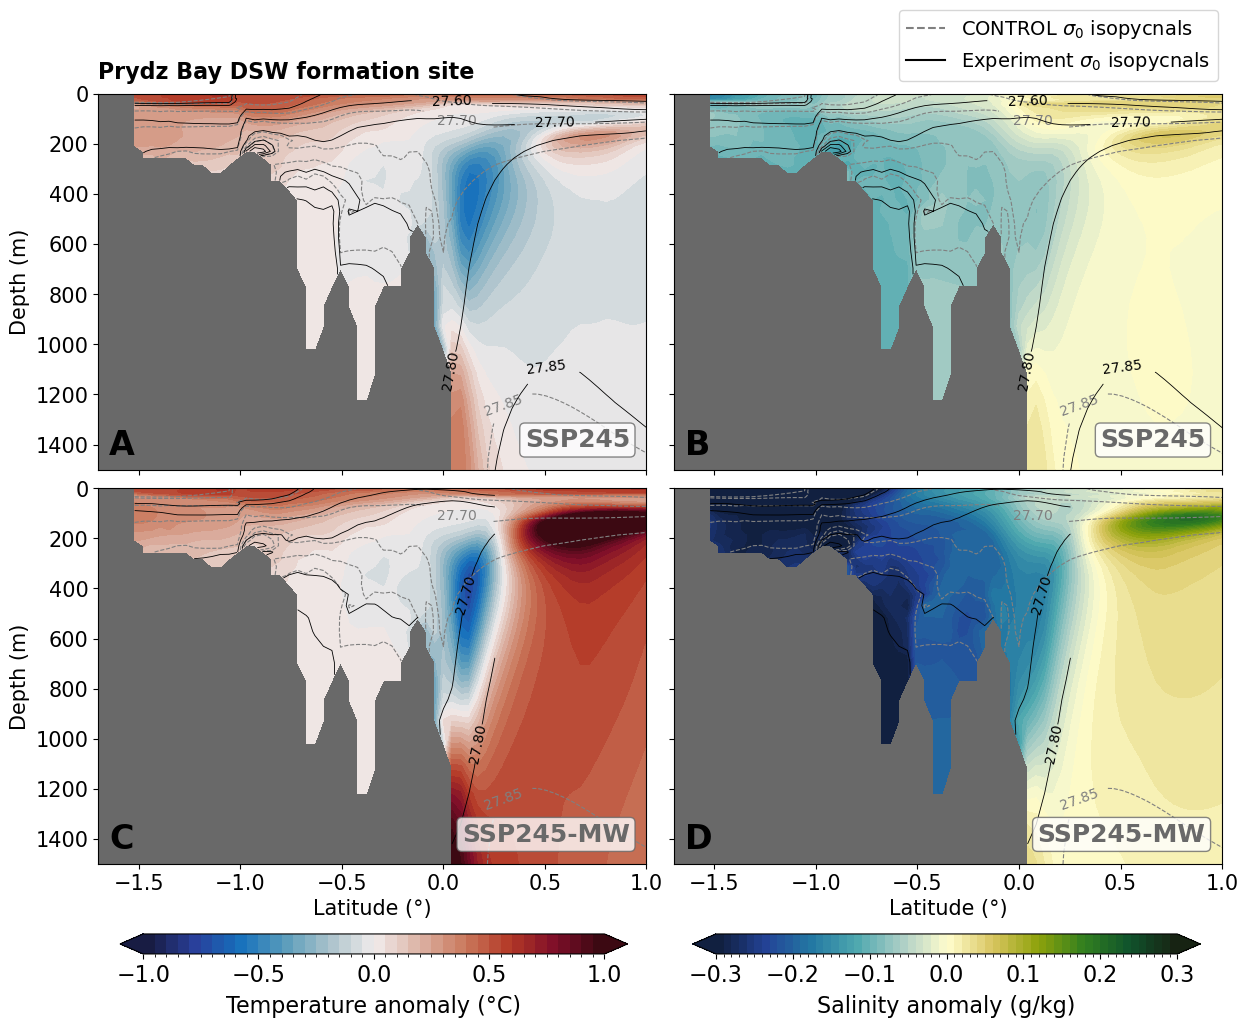

CPU times: user 12.9 s, sys: 6.86 s, total: 19.7 s
Wall time: 18.2 s


In [55]:
%%time
labels = ['A','B','C','D','','','E','F','G','H','I','J','K']
sim_labels = ['SSP245','SSP245','SSP245-MW','SSP245-MW','','']

plt.rcParams.update({'font.size': 15})
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14.5,10), sharex=True,sharey=True)
plt.subplots_adjust(wspace=0.05, hspace=0.05)

for i, ax in enumerate(axes.flatten()):
    ax.set_facecolor('dimgrey')
    ax.text(0.02, 0.04, f'{labels[i]}',  c='k', fontsize=24, ha='left', fontweight='bold', transform=ax.transAxes)
    ax.text(0.97, 0.06, f'{np.tile(sim_labels,2)[i]}', fontsize=18, fontweight='bold', color='dimgrey', ha='right', transform=ax.transAxes,
            bbox=dict(facecolor='w', alpha=0.8, edgecolor='dimgrey', boxstyle='round,pad=0.2'), zorder=3)

for i, ax in enumerate(axes[:,0]):
    ax.set_ylabel('Depth (m)')
# for i, ax in enumerate(axes[:,1]):
#     ax.set_yticklabels([])
#for i, ax in enumerate(axes[0,:]):
#    ax.set_xticklabels([])

axes[0,0].text(0.0, 1.04, 'Prydz Bay DSW formation site',  c='k', fontsize=16, fontweight='bold',transform=axes[0,0].transAxes)


# EAST ANTARCTICA
l1,l2,l3 = 70,60,80
# temp
control_mean_T = control_temp.where(((control_temp.xt_ocean < l1) & (control_temp.xt_ocean >= l2) | (control_temp.xt_ocean  > l3)), np.nan).mean('xt_ocean')
ssp245_mean_T = ssp245_temp.where(((control_temp.xt_ocean < l1) & (control_temp.xt_ocean >= l2) | (control_temp.xt_ocean  > l3)), np.nan).mean('xt_ocean')
ssp245mw_mean_T = ssp245mw_temp.where(((control_temp.xt_ocean < l1) & (control_temp.xt_ocean >= l2) | (control_temp.xt_ocean  > l3)), np.nan).mean('xt_ocean')
# salt
control_mean_S = control_salt.where(((control_salt.xt_ocean < l1) & (control_salt.xt_ocean >= l2) | (control_salt.xt_ocean  > l3)), np.nan).mean('xt_ocean')
ssp245_mean_S = ssp245_salt.where(((control_salt.xt_ocean < l1) & (control_salt.xt_ocean >= l2) | (control_salt.xt_ocean  > l3)), np.nan).mean('xt_ocean')
ssp245mw_mean_S = ssp245mw_salt.where(((control_salt.xt_ocean < l1) & (control_salt.xt_ocean >= l2) | (control_salt.xt_ocean  > l3)), np.nan).mean('xt_ocean')
# sigma1
control_mean_sig1 = control_sig1.where(((control_temp.xt_ocean < l1) & (control_temp.xt_ocean >= l2) | (control_temp.xt_ocean  > l3)), np.nan).mean('xt_ocean')
ssp245_mean_sig1 = ssp245_sig1.where(((control_temp.xt_ocean < l1) & (control_temp.xt_ocean >= l2) | (control_temp.xt_ocean  > l3)), np.nan).mean('xt_ocean')
ssp245mw_mean_sig1 = ssp245mw_sig1.where(((control_temp.xt_ocean < l1) & (control_temp.xt_ocean >= l2) | (control_temp.xt_ocean  > l3)), np.nan).mean('xt_ocean')
# sigma0
control_mean_sig0 = control_sig0.where(((control_temp.xt_ocean < l1) & (control_temp.xt_ocean >= l2) | (control_temp.xt_ocean  > l3)), np.nan).mean('xt_ocean')
ssp245_mean_sig0 = ssp245_sig0.where(((control_temp.xt_ocean < l1) & (control_temp.xt_ocean >= l2) | (control_temp.xt_ocean  > l3)), np.nan).mean('xt_ocean')
ssp245mw_mean_sig0 = ssp245mw_sig0.where(((control_temp.xt_ocean < l1) & (control_temp.xt_ocean >= l2) | (control_temp.xt_ocean  > l3)), np.nan).mean('xt_ocean')


# plot temperature
axes[0,0].contourf(ssp245_mean_T.yt_isobath_rel, ssp245_mean_T.st_ocean, ssp245_mean_T - control_mean_T,
                   cmap=cmap_T, norm=mpl.colors.BoundaryNorm(levels_T,ncolors=cmap_T.N, clip=False), 
                   levels=levels_T, extend='both')
cbT = axes[1,0].contourf(ssp245mw_mean_T.yt_isobath_rel, ssp245mw_mean_T.st_ocean, ssp245mw_mean_T - control_mean_T,
                   cmap=cmap_T, norm=mpl.colors.BoundaryNorm(levels_T,ncolors=cmap_T.N, clip=False), 
                   levels=levels_T, extend='both')
cbar = colorbar_horz(cbT, [0.14, 0.02, 0.35, 0.02],'Temperature anomaly (\u00b0C)')
cbar.ax.set_xticks([-1.0, -0.5, 0,0.5,1.0,])
#cbar.ax.set_xticklabels([-2.0,'',-1.0,'',0,'',1.0,'',2.0])

# plot salinity
axes[0,1].contourf(ssp245_mean_S.yt_isobath_rel, ssp245_mean_S.st_ocean, ssp245_mean_S - control_mean_S,
                   cmap=cmap_S, norm=mpl.colors.BoundaryNorm(levels_S,ncolors=cmap_S.N, clip=False), 
                   levels=levels_S, extend='both')
cbS = axes[1,1].contourf(ssp245mw_mean_S.yt_isobath_rel, ssp245mw_mean_S.st_ocean, ssp245mw_mean_S - control_mean_S,
                   cmap=cmap_S, norm=mpl.colors.BoundaryNorm(levels_S,ncolors=cmap_S.N, clip=False), 
                   levels=levels_S, extend='both')
cbar = colorbar_horz(cbS, [0.535, 0.02, 0.35, 0.02],'Salinity anomaly (g/kg)')
cbar.ax.set_xticks([-0.3,-0.2,-0.1,0,0.1,0.2,0.3])


lvls = [27.2, 27.3, 27.5, 27.6, 27.7, 27.8, 27.85, 27.9]
x_rel = control_mean_sig0.yt_isobath_rel
y = control_mean_sig0.st_ocean
# plot control contours
for i, ax in enumerate(axes.flatten()):
    cs = ax.contour(x_rel[:-270], y, control_mean_sig0[:,:-270], 
                    levels=lvls, colors='grey', linewidths=0.8, linestyles='--', zorder=2)
    ax.clabel(cs, lvls,use_clabeltext=True, fontsize=10, inline=True, inline_spacing=-15, zorder=2)
# plot SSP245 contours
for i, ax in enumerate(axes[0,:]):
    cs = ax.contour(x_rel[:-270], y, ssp245_mean_sig0[:,:-270], 
                    levels=lvls, colors='k', linewidths=0.6, zorder=2)
    ax.clabel(cs, lvls,use_clabeltext=True, fontsize=10, inline=True, inline_spacing=-15, zorder=2)
# plot SSP245-MW contours
for i, ax in enumerate(axes[1,:]):
    cs = ax.contour(x_rel[:-300], y, ssp245mw_mean_sig0[:,:-300], 
                     levels=lvls, colors='k', linewidths=0.6, zorder=2)
    ax.clabel(cs, lvls,use_clabeltext=True, fontsize=10, inline=True, inline_spacing=-15, zorder=2)

# add legend
line1 = Line2D([0], [0], color='grey', linestyle='--')
line2 = Line2D([0], [0], color='k', linestyle='-')
legend_labels = [f'CONTROL $\sigma_0$ isopycnals', f'Experiment $\sigma_0$ isopycnals']
axes[0,0].legend([line1, line2],legend_labels, bbox_to_anchor=[2.06, 1.25], loc='upper right', fontsize=14, ncols=1, columnspacing=4)


axes[0,0].set_ylim([1500,0])
axes[0,0].set_xlim([-1.7,1])
axes[1,0].set_xlabel('Latitude (\u00b0)')
axes[1,1].set_xlabel('Latitude (\u00b0)')

plt.show()

Check density. 

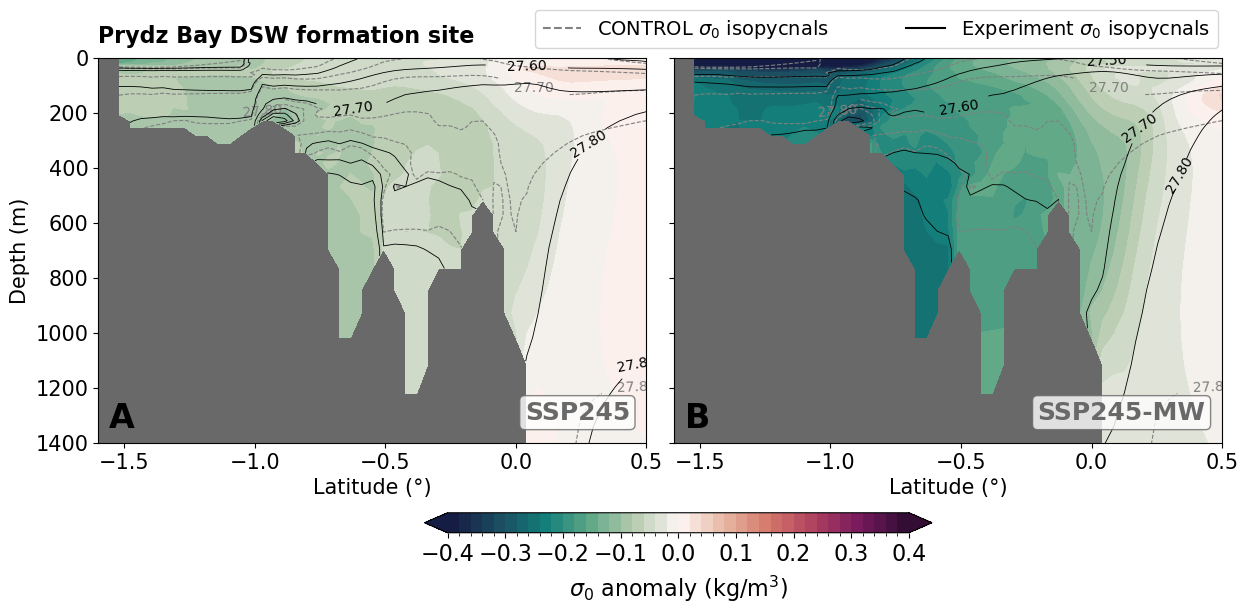

CPU times: user 15.7 s, sys: 9.6 s, total: 25.3 s
Wall time: 23.4 s


In [109]:
%%time
labels = ['A','B','C','D','','','E','F','G','H','I','J','K']
sim_labels = ['SSP245','SSP245-MW',]

plt.rcParams.update({'font.size': 15})
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14.5,5), sharex=True,sharey=True)
plt.subplots_adjust(wspace=0.05, hspace=0.05)

for i, ax in enumerate(axes):
    ax.set_facecolor('dimgrey')
    ax.text(0.02, 0.04, f'{labels[i]}',  c='k', fontsize=24, ha='left', fontweight='bold', transform=ax.transAxes)
    ax.text(0.97, 0.06, f'{np.tile(sim_labels,2)[i]}', fontsize=18, fontweight='bold', color='dimgrey', ha='right', transform=ax.transAxes,
            bbox=dict(facecolor='w', alpha=0.8, edgecolor='dimgrey', boxstyle='round,pad=0.2'), zorder=3)

axes[0].set_ylabel('Depth (m)')
axes[0].text(0.0, 1.04, 'Prydz Bay DSW formation site',  c='k', fontsize=16, fontweight='bold',transform=axes[0].transAxes)


# EAST ANTARCTICA
l1,l2,l3 = 70,60,80
# temp
control_mean_T = control_temp.where(((control_temp.xt_ocean < l1) & (control_temp.xt_ocean >= l2) | (control_temp.xt_ocean  > l3)), np.nan).mean('xt_ocean')
ssp245_mean_T = ssp245_temp.where(((control_temp.xt_ocean < l1) & (control_temp.xt_ocean >= l2) | (control_temp.xt_ocean  > l3)), np.nan).mean('xt_ocean')
ssp245mw_mean_T = ssp245mw_temp.where(((control_temp.xt_ocean < l1) & (control_temp.xt_ocean >= l2) | (control_temp.xt_ocean  > l3)), np.nan).mean('xt_ocean')
# salt
control_mean_S = control_salt.where(((control_salt.xt_ocean < l1) & (control_salt.xt_ocean >= l2) | (control_salt.xt_ocean  > l3)), np.nan).mean('xt_ocean')
ssp245_mean_S = ssp245_salt.where(((control_salt.xt_ocean < l1) & (control_salt.xt_ocean >= l2) | (control_salt.xt_ocean  > l3)), np.nan).mean('xt_ocean')
ssp245mw_mean_S = ssp245mw_salt.where(((control_salt.xt_ocean < l1) & (control_salt.xt_ocean >= l2) | (control_salt.xt_ocean  > l3)), np.nan).mean('xt_ocean')
# sigma1
control_mean_sig1 = control_sig1.where(((control_temp.xt_ocean < l1) & (control_temp.xt_ocean >= l2) | (control_temp.xt_ocean  > l3)), np.nan).mean('xt_ocean')
ssp245_mean_sig1 = ssp245_sig1.where(((control_temp.xt_ocean < l1) & (control_temp.xt_ocean >= l2) | (control_temp.xt_ocean  > l3)), np.nan).mean('xt_ocean')
ssp245mw_mean_sig1 = ssp245mw_sig1.where(((control_temp.xt_ocean < l1) & (control_temp.xt_ocean >= l2) | (control_temp.xt_ocean  > l3)), np.nan).mean('xt_ocean')
# sigma0
control_mean_sig0 = control_sig0.where(((control_temp.xt_ocean < l1) & (control_temp.xt_ocean >= l2) | (control_temp.xt_ocean  > l3)), np.nan).mean('xt_ocean')
ssp245_mean_sig0 = ssp245_sig0.where(((control_temp.xt_ocean < l1) & (control_temp.xt_ocean >= l2) | (control_temp.xt_ocean  > l3)), np.nan).mean('xt_ocean')
ssp245mw_mean_sig0 = ssp245mw_sig0.where(((control_temp.xt_ocean < l1) & (control_temp.xt_ocean >= l2) | (control_temp.xt_ocean  > l3)), np.nan).mean('xt_ocean')


# plot density anomaly
axes[0].contourf(ssp245_mean_T.yt_isobath_rel, ssp245_mean_T.st_ocean, ssp245_mean_sig0 - control_mean_sig0,
                   cmap=cmap_D, norm=mpl.colors.BoundaryNorm(levels_D,ncolors=cmap_D.N, clip=False), 
                   levels=levels_D, extend='both')
cbT = axes[1].contourf(ssp245mw_mean_sig0.yt_isobath_rel, ssp245mw_mean_sig0.st_ocean, ssp245mw_mean_sig0 - control_mean_sig0,
                   cmap=cmap_D, norm=mpl.colors.BoundaryNorm(levels_D,ncolors=cmap_D.N, clip=False), 
                   levels=levels_D, extend='both')

cbar = colorbar_horz(cbT, [0.35, -0.07, 0.35, 0.04],'$\sigma_0$ anomaly (kg/m$^3$)')
#cbar.ax.set_xticks([-1.0, -0.5, 0,0.5,1.0,])
#cbar.ax.set_xticklabels([-2.0,'',-1.0,'',0,'',1.0,'',2.0])

lvls = [27.2, 27.3, 27.5, 27.6, 27.7, 27.8, 27.85, 27.9]
x_rel = control_mean_sig0.yt_isobath_rel
y = control_mean_sig0.st_ocean
# plot control contours
for i, ax in enumerate(axes.flatten()):
    cs = ax.contour(x_rel[:-275], y, control_mean_sig0[:,:-275], 
                    levels=lvls, colors='grey', linewidths=0.8, linestyles='--', zorder=2)
    ax.clabel(cs, lvls,use_clabeltext=True, fontsize=10, inline=True, inline_spacing=-16, zorder=2)
# plot SSP245 contours
cs = axes[0].contour(x_rel[:-280], y, ssp245_mean_sig0[:,:-280], 
                levels=lvls, colors='k', linewidths=0.6, zorder=2)
axes[0].clabel(cs, lvls,use_clabeltext=True, fontsize=10, inline=True, inline_spacing=-16, zorder=2)
# plot SSP245-MW contours
cs = axes[1].contour(x_rel[:-280], y, ssp245mw_mean_sig0[:,:-280], 
                 levels=lvls, colors='k', linewidths=0.6, zorder=2)
axes[1].clabel(cs, lvls,use_clabeltext=True, fontsize=10, inline=True, inline_spacing=-16, zorder=2)


# add legend
line1 = Line2D([0], [0], color='grey', linestyle='--')
line2 = Line2D([0], [0], color='k', linestyle='-')
legend_labels = [f'CONTROL $\sigma_0$ isopycnals', f'Experiment $\sigma_0$ isopycnals']
axes[0].legend([line1, line2],legend_labels, bbox_to_anchor=[2.06, 1.15], loc='upper right', fontsize=14, ncols=2, columnspacing=4)


axes[0].set_ylim([1400,0])
axes[0].set_xlim([-1.6,0.5])
axes[0].set_xlabel('Latitude (\u00b0)')
axes[1].set_xlabel('Latitude (\u00b0)')

plt.show()

Mertz formation site. 

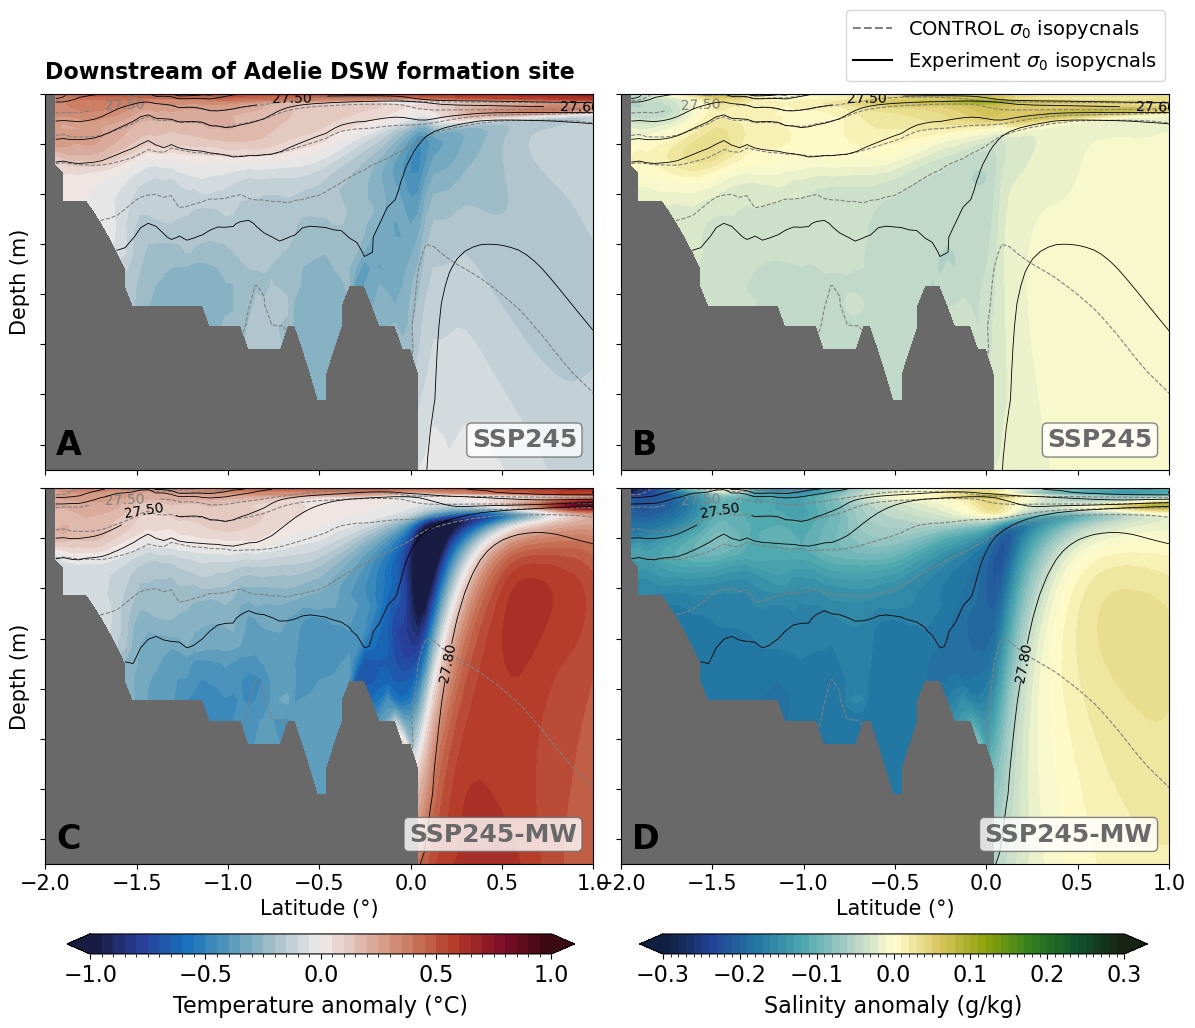

CPU times: user 12.9 s, sys: 6.93 s, total: 19.8 s
Wall time: 18.3 s


In [90]:
%%time
labels = ['A','B','C','D','','','E','F','G','H','I','J','K']
sim_labels = ['SSP245','SSP245','SSP245-MW','SSP245-MW','','']

plt.rcParams.update({'font.size': 15})
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14.5,10), sharex=True,sharey=True)
plt.subplots_adjust(wspace=0.05, hspace=0.05)

for i, ax in enumerate(axes.flatten()):
    ax.set_facecolor('dimgrey')
    ax.text(0.02, 0.04, f'{labels[i]}',  c='k', fontsize=24, ha='left', fontweight='bold', transform=ax.transAxes)
    ax.text(0.97, 0.06, f'{np.tile(sim_labels,2)[i]}', fontsize=18, fontweight='bold', color='dimgrey', ha='right', transform=ax.transAxes,
            bbox=dict(facecolor='w', alpha=0.8, edgecolor='dimgrey', boxstyle='round,pad=0.2'), zorder=3)

for i, ax in enumerate(axes[:,0]):
    ax.set_ylabel('Depth (m)')
for i, ax in enumerate(axes[:,1]):
    ax.set_yticklabels([])
#for i, ax in enumerate(axes[0,:]):
#    ax.set_xticklabels([])

axes[0,0].text(0.0, 1.04, 'Downstream of Adelie DSW formation site',  c='k', fontsize=16, fontweight='bold',transform=axes[0,0].transAxes)


# EAST ANTARCTICA
l1,l2,l3 = -230,-240,80
# temp
control_mean_T = control_temp.where(((control_temp.xt_ocean < l1) & (control_temp.xt_ocean >= l2) | (control_temp.xt_ocean  > l3)), np.nan).mean('xt_ocean')
ssp245_mean_T = ssp245_temp.where(((control_temp.xt_ocean < l1) & (control_temp.xt_ocean >= l2) | (control_temp.xt_ocean  > l3)), np.nan).mean('xt_ocean')
ssp245mw_mean_T = ssp245mw_temp.where(((control_temp.xt_ocean < l1) & (control_temp.xt_ocean >= l2) | (control_temp.xt_ocean  > l3)), np.nan).mean('xt_ocean')
# salt
control_mean_S = control_salt.where(((control_salt.xt_ocean < l1) & (control_salt.xt_ocean >= l2) | (control_salt.xt_ocean  > l3)), np.nan).mean('xt_ocean')
ssp245_mean_S = ssp245_salt.where(((control_salt.xt_ocean < l1) & (control_salt.xt_ocean >= l2) | (control_salt.xt_ocean  > l3)), np.nan).mean('xt_ocean')
ssp245mw_mean_S = ssp245mw_salt.where(((control_salt.xt_ocean < l1) & (control_salt.xt_ocean >= l2) | (control_salt.xt_ocean  > l3)), np.nan).mean('xt_ocean')
# sigma1
control_mean_sig1 = control_sig1.where(((control_temp.xt_ocean < l1) & (control_temp.xt_ocean >= l2) | (control_temp.xt_ocean  > l3)), np.nan).mean('xt_ocean')
ssp245_mean_sig1 = ssp245_sig1.where(((control_temp.xt_ocean < l1) & (control_temp.xt_ocean >= l2) | (control_temp.xt_ocean  > l3)), np.nan).mean('xt_ocean')
ssp245mw_mean_sig1 = ssp245mw_sig1.where(((control_temp.xt_ocean < l1) & (control_temp.xt_ocean >= l2) | (control_temp.xt_ocean  > l3)), np.nan).mean('xt_ocean')
# sigma0
control_mean_sig0 = control_sig0.where(((control_temp.xt_ocean < l1) & (control_temp.xt_ocean >= l2) | (control_temp.xt_ocean  > l3)), np.nan).mean('xt_ocean')
ssp245_mean_sig0 = ssp245_sig0.where(((control_temp.xt_ocean < l1) & (control_temp.xt_ocean >= l2) | (control_temp.xt_ocean  > l3)), np.nan).mean('xt_ocean')
ssp245mw_mean_sig0 = ssp245mw_sig0.where(((control_temp.xt_ocean < l1) & (control_temp.xt_ocean >= l2) | (control_temp.xt_ocean  > l3)), np.nan).mean('xt_ocean')


# plot temperature
axes[0,0].contourf(ssp245_mean_T.yt_isobath_rel, ssp245_mean_T.st_ocean, ssp245_mean_T - control_mean_T,
                   cmap=cmap_T, norm=mpl.colors.BoundaryNorm(levels_T,ncolors=cmap_T.N, clip=False), 
                   levels=levels_T, extend='both')
cbT = axes[1,0].contourf(ssp245mw_mean_T.yt_isobath_rel, ssp245mw_mean_T.st_ocean, ssp245mw_mean_T - control_mean_T,
                   cmap=cmap_T, norm=mpl.colors.BoundaryNorm(levels_T,ncolors=cmap_T.N, clip=False), 
                   levels=levels_T, extend='both')
cbar = colorbar_horz(cbT, [0.14, 0.02, 0.35, 0.02],'Temperature anomaly (\u00b0C)')
cbar.ax.set_xticks([-1.0, -0.5, 0,0.5,1.0,])
#cbar.ax.set_xticklabels([-2.0,'',-1.0,'',0,'',1.0,'',2.0])

# plot salinity
axes[0,1].contourf(ssp245_mean_S.yt_isobath_rel, ssp245_mean_S.st_ocean, ssp245_mean_S - control_mean_S,
                   cmap=cmap_S, norm=mpl.colors.BoundaryNorm(levels_S,ncolors=cmap_S.N, clip=False), 
                   levels=levels_S, extend='both')
cbS = axes[1,1].contourf(ssp245mw_mean_S.yt_isobath_rel, ssp245mw_mean_S.st_ocean, ssp245mw_mean_S - control_mean_S,
                   cmap=cmap_S, norm=mpl.colors.BoundaryNorm(levels_S,ncolors=cmap_S.N, clip=False), 
                   levels=levels_S, extend='both')
cbar = colorbar_horz(cbS, [0.535, 0.02, 0.35, 0.02],'Salinity anomaly (g/kg)')
cbar.ax.set_xticks([-0.3,-0.2,-0.1,0,0.1,0.2,0.3])


lvls = [27.2, 27.3, 27.5, 27.6, 27.7, 27.8, 27.85, 27.9]
x_rel = control_mean_sig0.yt_isobath_rel
y = control_mean_sig0.st_ocean
# plot control contours
for i, ax in enumerate(axes.flatten()):
    cs = ax.contour(x_rel, y, control_mean_sig0, 
                    levels=lvls, colors='grey', linewidths=0.8, linestyles='--', zorder=2)
    ax.clabel(cs, lvls,use_clabeltext=True, fontsize=10, inline=True, inline_spacing=-15, zorder=2)
# plot SSP245 contours
for i, ax in enumerate(axes[0,:]):
    cs = ax.contour(x_rel[:-200], y, ssp245_mean_sig0[:,:-200], 
                    levels=lvls, colors='k', linewidths=0.6, zorder=2)
    ax.clabel(cs, lvls,use_clabeltext=True, fontsize=10, inline=True, inline_spacing=-15, zorder=2)
# plot SSP245-MW contours
for i, ax in enumerate(axes[1,:]):
    cs = ax.contour(x_rel[:-220], y, ssp245mw_mean_sig0[:,:-220], 
                     levels=lvls, colors='k', linewidths=0.6, zorder=2)
    ax.clabel(cs, lvls,use_clabeltext=True, fontsize=10, inline=True, inline_spacing=-15, zorder=2)

# add legend
line1 = Line2D([0], [0], color='grey', linestyle='--')
line2 = Line2D([0], [0], color='k', linestyle='-')
legend_labels = [f'CONTROL $\sigma_0$ isopycnals', f'Experiment $\sigma_0$ isopycnals']
axes[0,0].legend([line1, line2],legend_labels, bbox_to_anchor=[2.06, 1.25], loc='upper right', fontsize=14, ncols=1, columnspacing=4)


axes[0,0].set_ylim([1500,0])
axes[0,0].set_xlim([-2,1])
axes[1,0].set_xlabel('Latitude (\u00b0)')
axes[1,1].set_xlabel('Latitude (\u00b0)')

plt.show()

Adelie DSW formation site

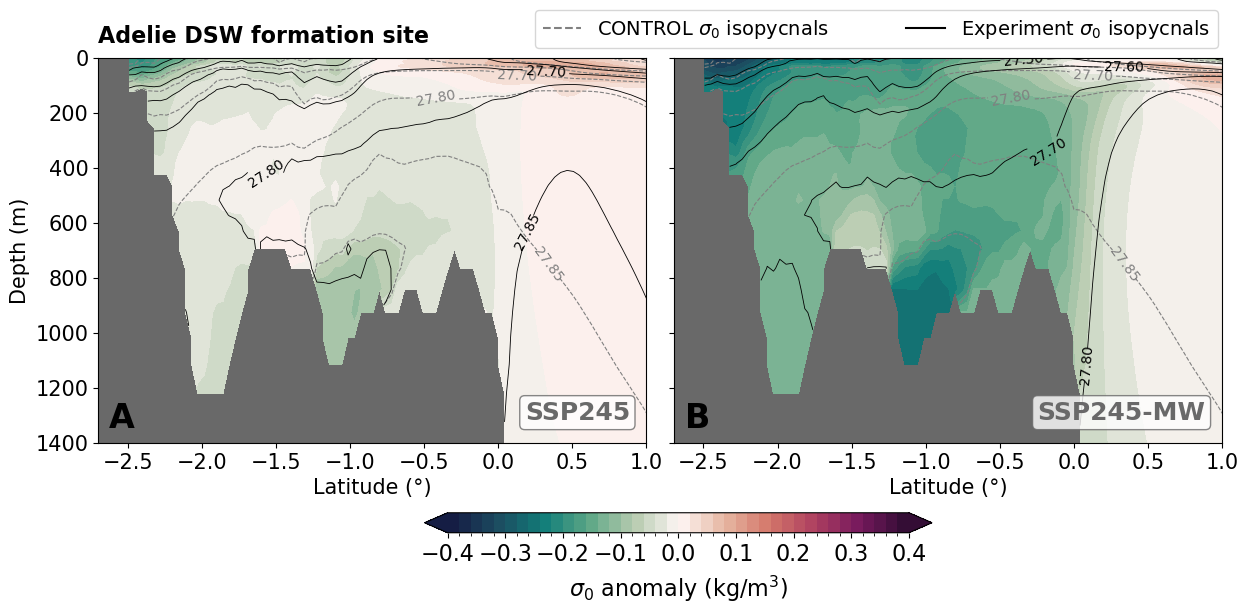

CPU times: user 11.9 s, sys: 6.83 s, total: 18.7 s
Wall time: 17.3 s


In [93]:
%%time
labels = ['A','B','C','D','','','E','F','G','H','I','J','K']
sim_labels = ['SSP245','SSP245-MW',]

plt.rcParams.update({'font.size': 15})
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14.5,5), sharex=True,sharey=True)
plt.subplots_adjust(wspace=0.05, hspace=0.05)

for i, ax in enumerate(axes):
    ax.set_facecolor('dimgrey')
    ax.text(0.02, 0.04, f'{labels[i]}',  c='k', fontsize=24, ha='left', fontweight='bold', transform=ax.transAxes)
    ax.text(0.97, 0.06, f'{np.tile(sim_labels,2)[i]}', fontsize=18, fontweight='bold', color='dimgrey', ha='right', transform=ax.transAxes,
            bbox=dict(facecolor='w', alpha=0.8, edgecolor='dimgrey', boxstyle='round,pad=0.2'), zorder=3)

axes[0].set_ylabel('Depth (m)')
axes[0].text(0.0, 1.04, 'Adelie DSW formation site',  c='k', fontsize=16, fontweight='bold',transform=axes[0].transAxes)


# Mertz Polynya
l1,l2,l3 = -210,-230,80
# temp
control_mean_T = control_temp.where(((control_temp.xt_ocean < l1) & (control_temp.xt_ocean >= l2) | (control_temp.xt_ocean  > l3)), np.nan).mean('xt_ocean')
ssp245_mean_T = ssp245_temp.where(((control_temp.xt_ocean < l1) & (control_temp.xt_ocean >= l2) | (control_temp.xt_ocean  > l3)), np.nan).mean('xt_ocean')
ssp245mw_mean_T = ssp245mw_temp.where(((control_temp.xt_ocean < l1) & (control_temp.xt_ocean >= l2) | (control_temp.xt_ocean  > l3)), np.nan).mean('xt_ocean')
# salt
control_mean_S = control_salt.where(((control_salt.xt_ocean < l1) & (control_salt.xt_ocean >= l2) | (control_salt.xt_ocean  > l3)), np.nan).mean('xt_ocean')
ssp245_mean_S = ssp245_salt.where(((control_salt.xt_ocean < l1) & (control_salt.xt_ocean >= l2) | (control_salt.xt_ocean  > l3)), np.nan).mean('xt_ocean')
ssp245mw_mean_S = ssp245mw_salt.where(((control_salt.xt_ocean < l1) & (control_salt.xt_ocean >= l2) | (control_salt.xt_ocean  > l3)), np.nan).mean('xt_ocean')
# sigma1
control_mean_sig1 = control_sig1.where(((control_temp.xt_ocean < l1) & (control_temp.xt_ocean >= l2) | (control_temp.xt_ocean  > l3)), np.nan).mean('xt_ocean')
ssp245_mean_sig1 = ssp245_sig1.where(((control_temp.xt_ocean < l1) & (control_temp.xt_ocean >= l2) | (control_temp.xt_ocean  > l3)), np.nan).mean('xt_ocean')
ssp245mw_mean_sig1 = ssp245mw_sig1.where(((control_temp.xt_ocean < l1) & (control_temp.xt_ocean >= l2) | (control_temp.xt_ocean  > l3)), np.nan).mean('xt_ocean')
# sigma0
control_mean_sig0 = control_sig0.where(((control_temp.xt_ocean < l1) & (control_temp.xt_ocean >= l2) | (control_temp.xt_ocean  > l3)), np.nan).mean('xt_ocean')
ssp245_mean_sig0 = ssp245_sig0.where(((control_temp.xt_ocean < l1) & (control_temp.xt_ocean >= l2) | (control_temp.xt_ocean  > l3)), np.nan).mean('xt_ocean')
ssp245mw_mean_sig0 = ssp245mw_sig0.where(((control_temp.xt_ocean < l1) & (control_temp.xt_ocean >= l2) | (control_temp.xt_ocean  > l3)), np.nan).mean('xt_ocean')


# plot density anomaly
axes[0].contourf(ssp245_mean_T.yt_isobath_rel, ssp245_mean_T.st_ocean, ssp245_mean_sig0 - control_mean_sig0,
                   cmap=cmap_D, norm=mpl.colors.BoundaryNorm(levels_D,ncolors=cmap_D.N, clip=False), 
                   levels=levels_D, extend='both')
cbT = axes[1].contourf(ssp245mw_mean_sig0.yt_isobath_rel, ssp245mw_mean_sig0.st_ocean, ssp245mw_mean_sig0 - control_mean_sig0,
                   cmap=cmap_D, norm=mpl.colors.BoundaryNorm(levels_D,ncolors=cmap_D.N, clip=False), 
                   levels=levels_D, extend='both')

cbar = colorbar_horz(cbT, [0.35, -0.07, 0.35, 0.04],'$\sigma_0$ anomaly (kg/m$^3$)')
#cbar.ax.set_xticks([-1.0, -0.5, 0,0.5,1.0,])
#cbar.ax.set_xticklabels([-2.0,'',-1.0,'',0,'',1.0,'',2.0])

lvls = [27.2, 27.3, 27.5, 27.6, 27.7, 27.8, 27.85, 27.9]
x_rel = control_mean_sig0.yt_isobath_rel
y = control_mean_sig0.st_ocean
# plot control contours
for i, ax in enumerate(axes.flatten()):
    cs = ax.contour(x_rel[:-275], y, control_mean_sig0[:,:-275], 
                    levels=lvls, colors='grey', linewidths=0.8, linestyles='--', zorder=2)
    ax.clabel(cs, lvls,use_clabeltext=True, fontsize=10, inline=True, inline_spacing=-16, zorder=2)
# plot SSP245 contours
cs = axes[0].contour(x_rel[:-280], y, ssp245_mean_sig0[:,:-280], 
                levels=lvls, colors='k', linewidths=0.6, zorder=2)
axes[0].clabel(cs, lvls,use_clabeltext=True, fontsize=10, inline=True, inline_spacing=-16, zorder=2)
# plot SSP245-MW contours
cs = axes[1].contour(x_rel[:-280], y, ssp245mw_mean_sig0[:,:-280], 
                 levels=lvls, colors='k', linewidths=0.6, zorder=2)
axes[1].clabel(cs, lvls,use_clabeltext=True, fontsize=10, inline=True, inline_spacing=-16, zorder=2)


# add legend
line1 = Line2D([0], [0], color='grey', linestyle='--')
line2 = Line2D([0], [0], color='k', linestyle='-')
legend_labels = [f'CONTROL $\sigma_0$ isopycnals', f'Experiment $\sigma_0$ isopycnals']
axes[0].legend([line1, line2],legend_labels, bbox_to_anchor=[2.06, 1.15], loc='upper right', fontsize=14, ncols=2, columnspacing=4)


axes[0].set_ylim([1400,0])
axes[0].set_xlim([-2.7,1])
axes[0].set_xlabel('Latitude (\u00b0)')
axes[1].set_xlabel('Latitude (\u00b0)')

plt.show()

Ross DSW Formation site

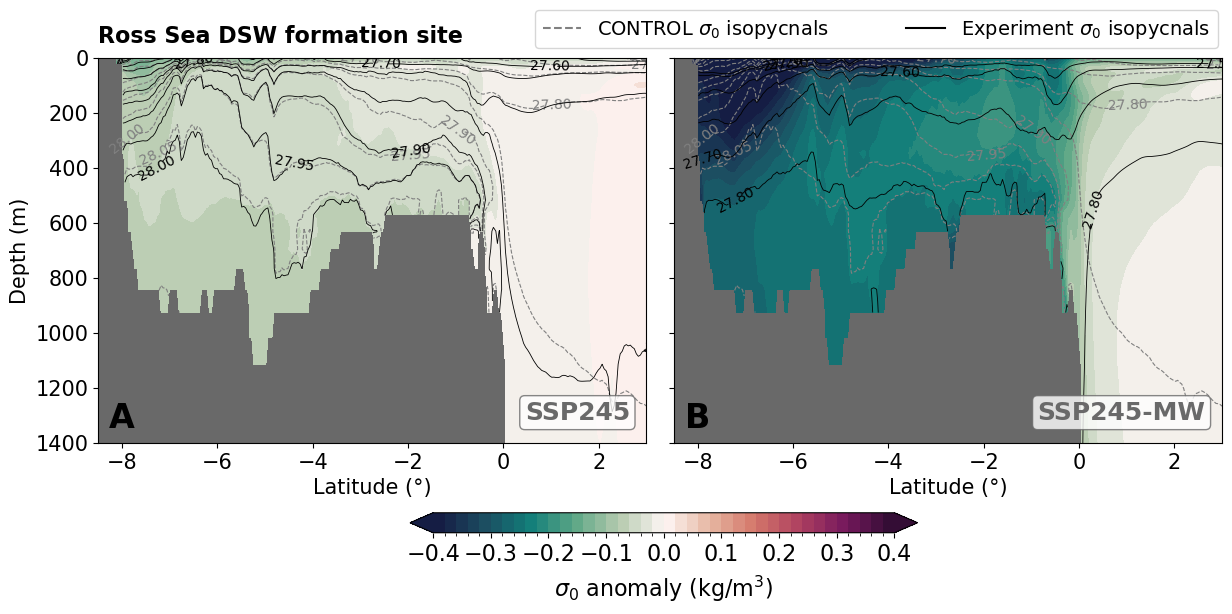

CPU times: user 12 s, sys: 6.97 s, total: 19 s
Wall time: 17.6 s


In [104]:
%%time
labels = ['A','B','C','D','','','E','F','G','H','I','J','K']
sim_labels = ['SSP245','SSP245-MW',]

plt.rcParams.update({'font.size': 15})
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14.5,5), sharex=True,sharey=True)
plt.subplots_adjust(wspace=0.05, hspace=0.05)

for i, ax in enumerate(axes):
    ax.set_facecolor('dimgrey')
    ax.text(0.02, 0.04, f'{labels[i]}',  c='k', fontsize=24, ha='left', fontweight='bold', transform=ax.transAxes)
    ax.text(0.97, 0.06, f'{np.tile(sim_labels,2)[i]}', fontsize=18, fontweight='bold', color='dimgrey', ha='right', transform=ax.transAxes,
            bbox=dict(facecolor='w', alpha=0.8, edgecolor='dimgrey', boxstyle='round,pad=0.2'), zorder=3)

axes[0].set_ylabel('Depth (m)')
axes[0].text(0.0, 1.04, 'Ross Sea DSW formation site',  c='k', fontsize=16, fontweight='bold',transform=axes[0].transAxes)


# Ross Sea
l1,l2,l3 = -180,-195,80
# temp
control_mean_T = control_temp.where(((control_temp.xt_ocean < l1) & (control_temp.xt_ocean >= l2) | (control_temp.xt_ocean  > l3)), np.nan).mean('xt_ocean')
ssp245_mean_T = ssp245_temp.where(((control_temp.xt_ocean < l1) & (control_temp.xt_ocean >= l2) | (control_temp.xt_ocean  > l3)), np.nan).mean('xt_ocean')
ssp245mw_mean_T = ssp245mw_temp.where(((control_temp.xt_ocean < l1) & (control_temp.xt_ocean >= l2) | (control_temp.xt_ocean  > l3)), np.nan).mean('xt_ocean')
# salt
control_mean_S = control_salt.where(((control_salt.xt_ocean < l1) & (control_salt.xt_ocean >= l2) | (control_salt.xt_ocean  > l3)), np.nan).mean('xt_ocean')
ssp245_mean_S = ssp245_salt.where(((control_salt.xt_ocean < l1) & (control_salt.xt_ocean >= l2) | (control_salt.xt_ocean  > l3)), np.nan).mean('xt_ocean')
ssp245mw_mean_S = ssp245mw_salt.where(((control_salt.xt_ocean < l1) & (control_salt.xt_ocean >= l2) | (control_salt.xt_ocean  > l3)), np.nan).mean('xt_ocean')
# sigma1
control_mean_sig1 = control_sig1.where(((control_temp.xt_ocean < l1) & (control_temp.xt_ocean >= l2) | (control_temp.xt_ocean  > l3)), np.nan).mean('xt_ocean')
ssp245_mean_sig1 = ssp245_sig1.where(((control_temp.xt_ocean < l1) & (control_temp.xt_ocean >= l2) | (control_temp.xt_ocean  > l3)), np.nan).mean('xt_ocean')
ssp245mw_mean_sig1 = ssp245mw_sig1.where(((control_temp.xt_ocean < l1) & (control_temp.xt_ocean >= l2) | (control_temp.xt_ocean  > l3)), np.nan).mean('xt_ocean')
# sigma0
control_mean_sig0 = control_sig0.where(((control_temp.xt_ocean < l1) & (control_temp.xt_ocean >= l2) | (control_temp.xt_ocean  > l3)), np.nan).mean('xt_ocean')
ssp245_mean_sig0 = ssp245_sig0.where(((control_temp.xt_ocean < l1) & (control_temp.xt_ocean >= l2) | (control_temp.xt_ocean  > l3)), np.nan).mean('xt_ocean')
ssp245mw_mean_sig0 = ssp245mw_sig0.where(((control_temp.xt_ocean < l1) & (control_temp.xt_ocean >= l2) | (control_temp.xt_ocean  > l3)), np.nan).mean('xt_ocean')


# plot density anomaly
axes[0].contourf(ssp245_mean_T.yt_isobath_rel, ssp245_mean_T.st_ocean, ssp245_mean_sig0 - control_mean_sig0,
                   cmap=cmap_D, norm=mpl.colors.BoundaryNorm(levels_D,ncolors=cmap_D.N, clip=False), 
                   levels=levels_D, extend='both')
cbT = axes[1].contourf(ssp245mw_mean_sig0.yt_isobath_rel, ssp245mw_mean_sig0.st_ocean, ssp245mw_mean_sig0 - control_mean_sig0,
                   cmap=cmap_D, norm=mpl.colors.BoundaryNorm(levels_D,ncolors=cmap_D.N, clip=False), 
                   levels=levels_D, extend='both')

cbar = colorbar_horz(cbT, [0.34, -0.07, 0.35, 0.04],'$\sigma_0$ anomaly (kg/m$^3$)')
#cbar.ax.set_xticks([-1.0, -0.5, 0,0.5,1.0,])
#cbar.ax.set_xticklabels([-2.0,'',-1.0,'',0,'',1.0,'',2.0])

lvls = [27.2, 27.3, 27.5, 27.6, 27.7, 27.8, 27.85, 27.9, 27.95, 28.0, 28.05, 28.1]
x_rel = control_mean_sig0.yt_isobath_rel
y = control_mean_sig0.st_ocean
# plot control contours
for i, ax in enumerate(axes.flatten()):
    cs = ax.contour(x_rel[:-205], y, control_mean_sig0[:,:-205], 
                    levels=lvls, colors='grey', linewidths=0.8, linestyles='--', zorder=2)
    ax.clabel(cs, lvls,use_clabeltext=True, fontsize=10, inline=True, inline_spacing=-16, zorder=2)
# plot SSP245 contours
cs = axes[0].contour(x_rel[:-200], y, ssp245_mean_sig0[:,:-200], 
                levels=lvls, colors='k', linewidths=0.6, zorder=2)
axes[0].clabel(cs, lvls,use_clabeltext=True, fontsize=10, inline=True, inline_spacing=-16, zorder=2)
# plot SSP245-MW contours
cs = axes[1].contour(x_rel[:-200], y, ssp245mw_mean_sig0[:,:-200], 
                 levels=lvls, colors='k', linewidths=0.6, zorder=2)
axes[1].clabel(cs, lvls,use_clabeltext=True, fontsize=10, inline=True, inline_spacing=-16, zorder=2)


# add legend
line1 = Line2D([0], [0], color='grey', linestyle='--')
line2 = Line2D([0], [0], color='k', linestyle='-')
legend_labels = [f'CONTROL $\sigma_0$ isopycnals', f'Experiment $\sigma_0$ isopycnals']
axes[0].legend([line1, line2],legend_labels, bbox_to_anchor=[2.06, 1.15], loc='upper right', fontsize=14, ncols=2, columnspacing=4)


axes[0].set_ylim([1400,0])
axes[0].set_xlim([-8.5,3])
axes[0].set_xlabel('Latitude (\u00b0)')
axes[1].set_xlabel('Latitude (\u00b0)')

plt.show()

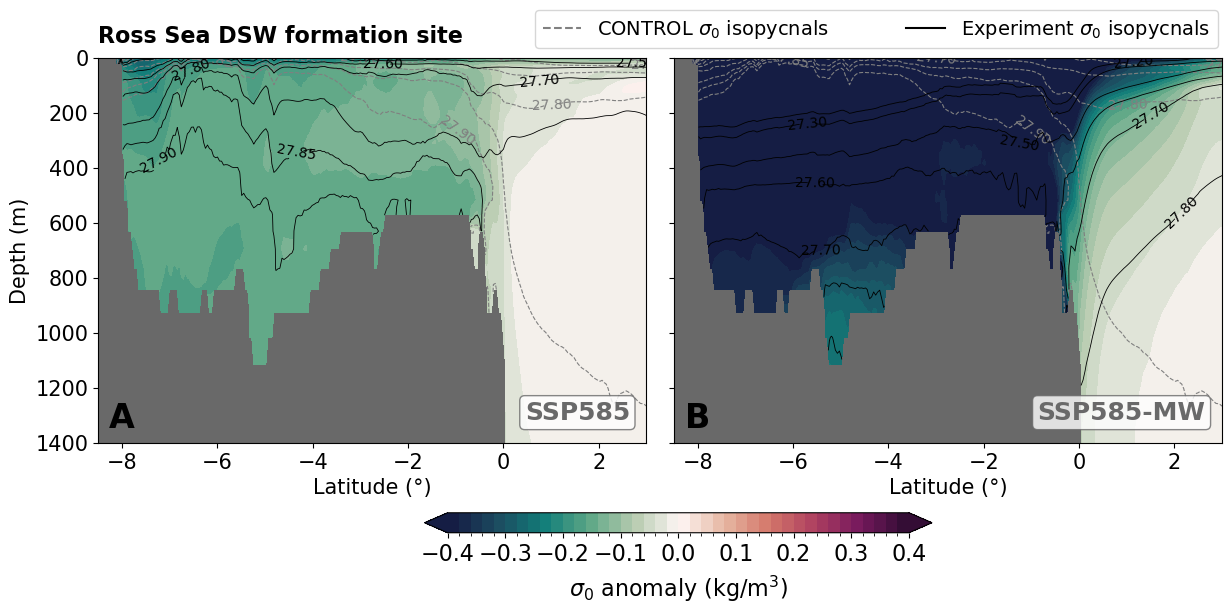

CPU times: user 14.9 s, sys: 9.35 s, total: 24.3 s
Wall time: 22.4 s


In [108]:
%%time
labels = ['A','B','C','D','','','E','F','G','H','I','J','K']
sim_labels = ['SSP585','SSP585-MW',]

plt.rcParams.update({'font.size': 15})
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14.5,5), sharex=True,sharey=True)
plt.subplots_adjust(wspace=0.05, hspace=0.05)

for i, ax in enumerate(axes):
    ax.set_facecolor('dimgrey')
    ax.text(0.02, 0.04, f'{labels[i]}',  c='k', fontsize=24, ha='left', fontweight='bold', transform=ax.transAxes)
    ax.text(0.97, 0.06, f'{np.tile(sim_labels,2)[i]}', fontsize=18, fontweight='bold', color='dimgrey', ha='right', transform=ax.transAxes,
            bbox=dict(facecolor='w', alpha=0.8, edgecolor='dimgrey', boxstyle='round,pad=0.2'), zorder=3)

axes[0].set_ylabel('Depth (m)')
axes[0].text(0.0, 1.04, 'Ross Sea DSW formation site',  c='k', fontsize=16, fontweight='bold',transform=axes[0].transAxes)


# Ross Sea
l1,l2,l3 = -180,-195,80
# temp
control_mean_T = control_temp.where(((control_temp.xt_ocean < l1) & (control_temp.xt_ocean >= l2) | (control_temp.xt_ocean  > l3)), np.nan).mean('xt_ocean')
ssp245_mean_T = ssp585_temp.where(((control_temp.xt_ocean < l1) & (control_temp.xt_ocean >= l2) | (control_temp.xt_ocean  > l3)), np.nan).mean('xt_ocean')
ssp245mw_mean_T = ssp585mw_temp.where(((control_temp.xt_ocean < l1) & (control_temp.xt_ocean >= l2) | (control_temp.xt_ocean  > l3)), np.nan).mean('xt_ocean')
# salt
control_mean_S = control_salt.where(((control_salt.xt_ocean < l1) & (control_salt.xt_ocean >= l2) | (control_salt.xt_ocean  > l3)), np.nan).mean('xt_ocean')
ssp245_mean_S = ssp585_salt.where(((control_salt.xt_ocean < l1) & (control_salt.xt_ocean >= l2) | (control_salt.xt_ocean  > l3)), np.nan).mean('xt_ocean')
ssp245mw_mean_S = ssp585mw_salt.where(((control_salt.xt_ocean < l1) & (control_salt.xt_ocean >= l2) | (control_salt.xt_ocean  > l3)), np.nan).mean('xt_ocean')
# sigma1
control_mean_sig1 = control_sig1.where(((control_temp.xt_ocean < l1) & (control_temp.xt_ocean >= l2) | (control_temp.xt_ocean  > l3)), np.nan).mean('xt_ocean')
ssp245_mean_sig1 = ssp585_sig1.where(((control_temp.xt_ocean < l1) & (control_temp.xt_ocean >= l2) | (control_temp.xt_ocean  > l3)), np.nan).mean('xt_ocean')
ssp245mw_mean_sig1 = ssp245mw_sig1.where(((control_temp.xt_ocean < l1) & (control_temp.xt_ocean >= l2) | (control_temp.xt_ocean  > l3)), np.nan).mean('xt_ocean')
# sigma0
control_mean_sig0 = control_sig0.where(((control_temp.xt_ocean < l1) & (control_temp.xt_ocean >= l2) | (control_temp.xt_ocean  > l3)), np.nan).mean('xt_ocean')
ssp245_mean_sig0 = ssp585_sig0.where(((control_temp.xt_ocean < l1) & (control_temp.xt_ocean >= l2) | (control_temp.xt_ocean  > l3)), np.nan).mean('xt_ocean')
ssp245mw_mean_sig0 = ssp585mw_sig0.where(((control_temp.xt_ocean < l1) & (control_temp.xt_ocean >= l2) | (control_temp.xt_ocean  > l3)), np.nan).mean('xt_ocean')


# plot density anomaly
axes[0].contourf(ssp245_mean_T.yt_isobath_rel, ssp245_mean_T.st_ocean, ssp245_mean_sig0 - control_mean_sig0,
                   cmap=cmap_D, norm=mpl.colors.BoundaryNorm(levels_D,ncolors=cmap_D.N, clip=False), 
                   levels=levels_D, extend='both')
cbT = axes[1].contourf(ssp245mw_mean_sig0.yt_isobath_rel, ssp245mw_mean_sig0.st_ocean, ssp245mw_mean_sig0 - control_mean_sig0,
                   cmap=cmap_D, norm=mpl.colors.BoundaryNorm(levels_D,ncolors=cmap_D.N, clip=False), 
                   levels=levels_D, extend='both')

cbar = colorbar_horz(cbT, [0.35, -0.07, 0.35, 0.04],'$\sigma_0$ anomaly (kg/m$^3$)')
#cbar.ax.set_xticks([-1.0, -0.5, 0,0.5,1.0,])
#cbar.ax.set_xticklabels([-2.0,'',-1.0,'',0,'',1.0,'',2.0])

lvls = [27.2, 27.3, 27.5, 27.6, 27.7, 27.8, 27.85, 27.9]
x_rel = control_mean_sig0.yt_isobath_rel
y = control_mean_sig0.st_ocean
# plot control contours
for i, ax in enumerate(axes.flatten()):
    cs = ax.contour(x_rel[:-205], y, control_mean_sig0[:,:-205], 
                    levels=lvls, colors='grey', linewidths=0.8, linestyles='--', zorder=2)
    ax.clabel(cs, lvls,use_clabeltext=True, fontsize=10, inline=True, inline_spacing=-16, zorder=2)
# plot SSP245 contours
cs = axes[0].contour(x_rel[:-200], y, ssp245_mean_sig0[:,:-200], 
                levels=lvls, colors='k', linewidths=0.6, zorder=2)
axes[0].clabel(cs, lvls,use_clabeltext=True, fontsize=10, inline=True, inline_spacing=-16, zorder=2)
# plot SSP245-MW contours
cs = axes[1].contour(x_rel[:-200], y, ssp245mw_mean_sig0[:,:-200], 
                 levels=lvls, colors='k', linewidths=0.6, zorder=2)
axes[1].clabel(cs, lvls,use_clabeltext=True, fontsize=10, inline=True, inline_spacing=-16, zorder=2)


# add legend
line1 = Line2D([0], [0], color='grey', linestyle='--')
line2 = Line2D([0], [0], color='k', linestyle='-')
legend_labels = [f'CONTROL $\sigma_0$ isopycnals', f'Experiment $\sigma_0$ isopycnals']
axes[0].legend([line1, line2],legend_labels, bbox_to_anchor=[2.06, 1.15], loc='upper right', fontsize=14, ncols=2, columnspacing=4)


axes[0].set_ylim([1400,0])
axes[0].set_xlim([-8.5,3])
axes[0].set_xlabel('Latitude (\u00b0)')
axes[1].set_xlabel('Latitude (\u00b0)')

plt.show()

Weddell Sea DSW Formation site

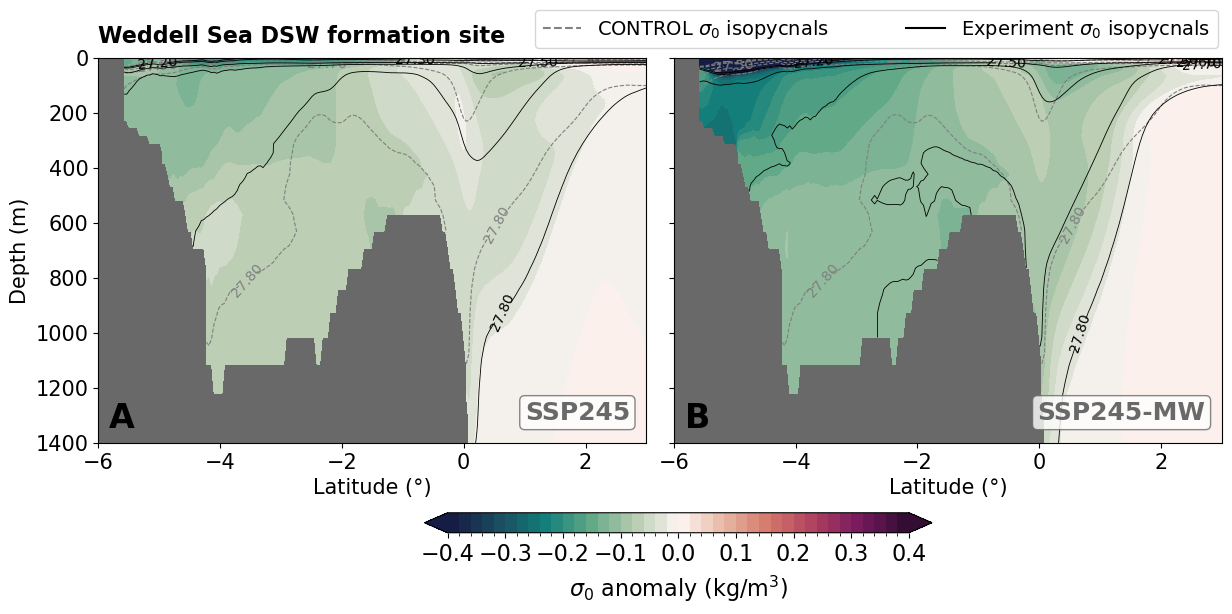

CPU times: user 12.7 s, sys: 7.14 s, total: 19.8 s
Wall time: 18.3 s


In [105]:
%%time
labels = ['A','B','C','D','','','E','F','G','H','I','J','K']
sim_labels = ['SSP245','SSP245-MW',]

plt.rcParams.update({'font.size': 15})
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14.5,5), sharex=True,sharey=True)
plt.subplots_adjust(wspace=0.05, hspace=0.05)

for i, ax in enumerate(axes):
    ax.set_facecolor('dimgrey')
    ax.text(0.02, 0.04, f'{labels[i]}',  c='k', fontsize=24, ha='left', fontweight='bold', transform=ax.transAxes)
    ax.text(0.97, 0.06, f'{np.tile(sim_labels,2)[i]}', fontsize=18, fontweight='bold', color='dimgrey', ha='right', transform=ax.transAxes,
            bbox=dict(facecolor='w', alpha=0.8, edgecolor='dimgrey', boxstyle='round,pad=0.2'), zorder=3)

axes[0].set_ylabel('Depth (m)')
axes[0].text(0.0, 1.04, 'Weddell Sea DSW formation site',  c='k', fontsize=16, fontweight='bold',transform=axes[0].transAxes)


# Ross Sea
l1,l2,l3 = -35,-55,80
# temp
control_mean_T = control_temp.where(((control_temp.xt_ocean < l1) & (control_temp.xt_ocean >= l2) | (control_temp.xt_ocean  > l3)), np.nan).mean('xt_ocean')
ssp245_mean_T = ssp245_temp.where(((control_temp.xt_ocean < l1) & (control_temp.xt_ocean >= l2) | (control_temp.xt_ocean  > l3)), np.nan).mean('xt_ocean')
ssp245mw_mean_T = ssp245mw_temp.where(((control_temp.xt_ocean < l1) & (control_temp.xt_ocean >= l2) | (control_temp.xt_ocean  > l3)), np.nan).mean('xt_ocean')
# salt
control_mean_S = control_salt.where(((control_salt.xt_ocean < l1) & (control_salt.xt_ocean >= l2) | (control_salt.xt_ocean  > l3)), np.nan).mean('xt_ocean')
ssp245_mean_S = ssp245_salt.where(((control_salt.xt_ocean < l1) & (control_salt.xt_ocean >= l2) | (control_salt.xt_ocean  > l3)), np.nan).mean('xt_ocean')
ssp245mw_mean_S = ssp245mw_salt.where(((control_salt.xt_ocean < l1) & (control_salt.xt_ocean >= l2) | (control_salt.xt_ocean  > l3)), np.nan).mean('xt_ocean')
# sigma1
control_mean_sig1 = control_sig1.where(((control_temp.xt_ocean < l1) & (control_temp.xt_ocean >= l2) | (control_temp.xt_ocean  > l3)), np.nan).mean('xt_ocean')
ssp245_mean_sig1 = ssp245_sig1.where(((control_temp.xt_ocean < l1) & (control_temp.xt_ocean >= l2) | (control_temp.xt_ocean  > l3)), np.nan).mean('xt_ocean')
ssp245mw_mean_sig1 = ssp245mw_sig1.where(((control_temp.xt_ocean < l1) & (control_temp.xt_ocean >= l2) | (control_temp.xt_ocean  > l3)), np.nan).mean('xt_ocean')
# sigma0
control_mean_sig0 = control_sig0.where(((control_temp.xt_ocean < l1) & (control_temp.xt_ocean >= l2) | (control_temp.xt_ocean  > l3)), np.nan).mean('xt_ocean')
ssp245_mean_sig0 = ssp245_sig0.where(((control_temp.xt_ocean < l1) & (control_temp.xt_ocean >= l2) | (control_temp.xt_ocean  > l3)), np.nan).mean('xt_ocean')
ssp245mw_mean_sig0 = ssp245mw_sig0.where(((control_temp.xt_ocean < l1) & (control_temp.xt_ocean >= l2) | (control_temp.xt_ocean  > l3)), np.nan).mean('xt_ocean')


# plot density anomaly
axes[0].contourf(ssp245_mean_T.yt_isobath_rel, ssp245_mean_T.st_ocean, ssp245_mean_sig0 - control_mean_sig0,
                   cmap=cmap_D, norm=mpl.colors.BoundaryNorm(levels_D,ncolors=cmap_D.N, clip=False), 
                   levels=levels_D, extend='both')
cbT = axes[1].contourf(ssp245mw_mean_sig0.yt_isobath_rel, ssp245mw_mean_sig0.st_ocean, ssp245mw_mean_sig0 - control_mean_sig0,
                   cmap=cmap_D, norm=mpl.colors.BoundaryNorm(levels_D,ncolors=cmap_D.N, clip=False), 
                   levels=levels_D, extend='both')

cbar = colorbar_horz(cbT, [0.35, -0.07, 0.35, 0.04],'$\sigma_0$ anomaly (kg/m$^3$)')
#cbar.ax.set_xticks([-1.0, -0.5, 0,0.5,1.0,])
#cbar.ax.set_xticklabels([-2.0,'',-1.0,'',0,'',1.0,'',2.0])

lvls = [27.2, 27.3, 27.5, 27.6, 27.7, 27.8, 27.85, 27.9]
x_rel = control_mean_sig0.yt_isobath_rel
y = control_mean_sig0.st_ocean
# plot control contours
for i, ax in enumerate(axes.flatten()):
    cs = ax.contour(x_rel[:-205], y, control_mean_sig0[:,:-205], 
                    levels=lvls, colors='grey', linewidths=0.8, linestyles='--', zorder=2)
    ax.clabel(cs, lvls,use_clabeltext=True, fontsize=10, inline=True, inline_spacing=-16, zorder=2)
# plot SSP245 contours
cs = axes[0].contour(x_rel[:-200], y, ssp245_mean_sig0[:,:-200], 
                levels=lvls, colors='k', linewidths=0.6, zorder=2)
axes[0].clabel(cs, lvls,use_clabeltext=True, fontsize=10, inline=True, inline_spacing=-16, zorder=2)
# plot SSP245-MW contours
cs = axes[1].contour(x_rel[:-200], y, ssp245mw_mean_sig0[:,:-200], 
                 levels=lvls, colors='k', linewidths=0.6, zorder=2)
axes[1].clabel(cs, lvls,use_clabeltext=True, fontsize=10, inline=True, inline_spacing=-16, zorder=2)


# add legend
line1 = Line2D([0], [0], color='grey', linestyle='--')
line2 = Line2D([0], [0], color='k', linestyle='-')
legend_labels = [f'CONTROL $\sigma_0$ isopycnals', f'Experiment $\sigma_0$ isopycnals']
axes[0].legend([line1, line2],legend_labels, bbox_to_anchor=[2.06, 1.15], loc='upper right', fontsize=14, ncols=2, columnspacing=4)


axes[0].set_ylim([1400,0])
axes[0].set_xlim([-6,3])
axes[0].set_xlabel('Latitude (\u00b0)')
axes[1].set_xlabel('Latitude (\u00b0)')

plt.show()

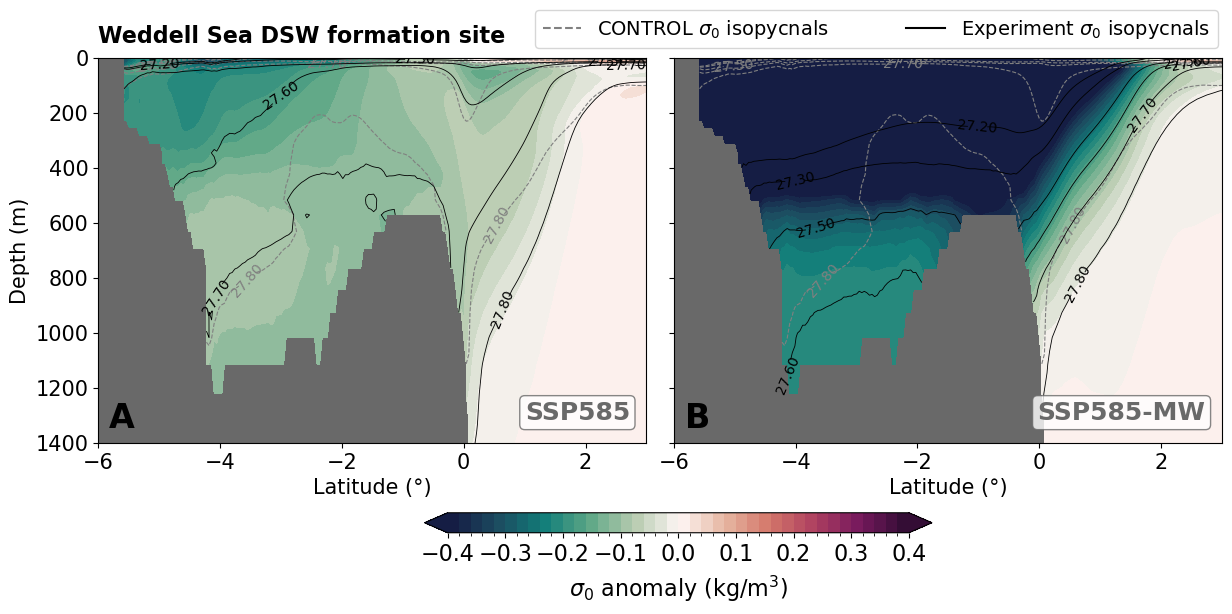

CPU times: user 11.9 s, sys: 11.2 s, total: 23.1 s
Wall time: 25.3 s


In [106]:
%%time
labels = ['A','B','C','D','','','E','F','G','H','I','J','K']
sim_labels = ['SSP585','SSP585-MW',]

plt.rcParams.update({'font.size': 15})
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14.5,5), sharex=True,sharey=True)
plt.subplots_adjust(wspace=0.05, hspace=0.05)

for i, ax in enumerate(axes):
    ax.set_facecolor('dimgrey')
    ax.text(0.02, 0.04, f'{labels[i]}',  c='k', fontsize=24, ha='left', fontweight='bold', transform=ax.transAxes)
    ax.text(0.97, 0.06, f'{np.tile(sim_labels,2)[i]}', fontsize=18, fontweight='bold', color='dimgrey', ha='right', transform=ax.transAxes,
            bbox=dict(facecolor='w', alpha=0.8, edgecolor='dimgrey', boxstyle='round,pad=0.2'), zorder=3)

axes[0].set_ylabel('Depth (m)')
axes[0].text(0.0, 1.04, 'Weddell Sea DSW formation site',  c='k', fontsize=16, fontweight='bold',transform=axes[0].transAxes)


# Ross Sea
l1,l2,l3 = -35,-55,80
# temp
control_mean_T = control_temp.where(((control_temp.xt_ocean < l1) & (control_temp.xt_ocean >= l2) | (control_temp.xt_ocean  > l3)), np.nan).mean('xt_ocean')
ssp245_mean_T = ssp585_temp.where(((control_temp.xt_ocean < l1) & (control_temp.xt_ocean >= l2) | (control_temp.xt_ocean  > l3)), np.nan).mean('xt_ocean')
ssp245mw_mean_T = ssp585mw_temp.where(((control_temp.xt_ocean < l1) & (control_temp.xt_ocean >= l2) | (control_temp.xt_ocean  > l3)), np.nan).mean('xt_ocean')
# salt
control_mean_S = control_salt.where(((control_salt.xt_ocean < l1) & (control_salt.xt_ocean >= l2) | (control_salt.xt_ocean  > l3)), np.nan).mean('xt_ocean')
ssp245_mean_S = ssp585_salt.where(((control_salt.xt_ocean < l1) & (control_salt.xt_ocean >= l2) | (control_salt.xt_ocean  > l3)), np.nan).mean('xt_ocean')
ssp245mw_mean_S = ssp585mw_salt.where(((control_salt.xt_ocean < l1) & (control_salt.xt_ocean >= l2) | (control_salt.xt_ocean  > l3)), np.nan).mean('xt_ocean')
# sigma1
control_mean_sig1 = control_sig1.where(((control_temp.xt_ocean < l1) & (control_temp.xt_ocean >= l2) | (control_temp.xt_ocean  > l3)), np.nan).mean('xt_ocean')
ssp245_mean_sig1 = ssp585_sig1.where(((control_temp.xt_ocean < l1) & (control_temp.xt_ocean >= l2) | (control_temp.xt_ocean  > l3)), np.nan).mean('xt_ocean')
ssp245mw_mean_sig1 = ssp245mw_sig1.where(((control_temp.xt_ocean < l1) & (control_temp.xt_ocean >= l2) | (control_temp.xt_ocean  > l3)), np.nan).mean('xt_ocean')
# sigma0
control_mean_sig0 = control_sig0.where(((control_temp.xt_ocean < l1) & (control_temp.xt_ocean >= l2) | (control_temp.xt_ocean  > l3)), np.nan).mean('xt_ocean')
ssp245_mean_sig0 = ssp585_sig0.where(((control_temp.xt_ocean < l1) & (control_temp.xt_ocean >= l2) | (control_temp.xt_ocean  > l3)), np.nan).mean('xt_ocean')
ssp245mw_mean_sig0 = ssp585mw_sig0.where(((control_temp.xt_ocean < l1) & (control_temp.xt_ocean >= l2) | (control_temp.xt_ocean  > l3)), np.nan).mean('xt_ocean')


# plot density anomaly
axes[0].contourf(ssp245_mean_T.yt_isobath_rel, ssp245_mean_T.st_ocean, ssp245_mean_sig0 - control_mean_sig0,
                   cmap=cmap_D, norm=mpl.colors.BoundaryNorm(levels_D,ncolors=cmap_D.N, clip=False), 
                   levels=levels_D, extend='both')
cbT = axes[1].contourf(ssp245mw_mean_sig0.yt_isobath_rel, ssp245mw_mean_sig0.st_ocean, ssp245mw_mean_sig0 - control_mean_sig0,
                   cmap=cmap_D, norm=mpl.colors.BoundaryNorm(levels_D,ncolors=cmap_D.N, clip=False), 
                   levels=levels_D, extend='both')

cbar = colorbar_horz(cbT, [0.35, -0.07, 0.35, 0.04],'$\sigma_0$ anomaly (kg/m$^3$)')
#cbar.ax.set_xticks([-1.0, -0.5, 0,0.5,1.0,])
#cbar.ax.set_xticklabels([-2.0,'',-1.0,'',0,'',1.0,'',2.0])

lvls = [27.2, 27.3, 27.5, 27.6, 27.7, 27.8, 27.85, 27.9]
x_rel = control_mean_sig0.yt_isobath_rel
y = control_mean_sig0.st_ocean
# plot control contours
for i, ax in enumerate(axes.flatten()):
    cs = ax.contour(x_rel[:-205], y, control_mean_sig0[:,:-205], 
                    levels=lvls, colors='grey', linewidths=0.8, linestyles='--', zorder=2)
    ax.clabel(cs, lvls,use_clabeltext=True, fontsize=10, inline=True, inline_spacing=-16, zorder=2)
# plot SSP245 contours
cs = axes[0].contour(x_rel[:-200], y, ssp245_mean_sig0[:,:-200], 
                levels=lvls, colors='k', linewidths=0.6, zorder=2)
axes[0].clabel(cs, lvls,use_clabeltext=True, fontsize=10, inline=True, inline_spacing=-16, zorder=2)
# plot SSP245-MW contours
cs = axes[1].contour(x_rel[:-200], y, ssp245mw_mean_sig0[:,:-200], 
                 levels=lvls, colors='k', linewidths=0.6, zorder=2)
axes[1].clabel(cs, lvls,use_clabeltext=True, fontsize=10, inline=True, inline_spacing=-16, zorder=2)


# add legend
line1 = Line2D([0], [0], color='grey', linestyle='--')
line2 = Line2D([0], [0], color='k', linestyle='-')
legend_labels = [f'CONTROL $\sigma_0$ isopycnals', f'Experiment $\sigma_0$ isopycnals']
axes[0].legend([line1, line2],legend_labels, bbox_to_anchor=[2.06, 1.15], loc='upper right', fontsize=14, ncols=2, columnspacing=4)


axes[0].set_ylim([1400,0])
axes[0].set_xlim([-6,3])
axes[0].set_xlabel('Latitude (\u00b0)')
axes[1].set_xlabel('Latitude (\u00b0)')

plt.show()

In [74]:
region = 'east_antarctica'
l1 = -250
l2 = -280
l3 = 80

control_mean_plot = control.where(((control.xt_ocean < l1) & (control.xt_ocean >= l2) | (control.xt_ocean  > l3)), np.nan)
control_mean = control.where(((control.xt_ocean < l1) & (control.xt_ocean >= l2) | (control.xt_ocean  > l3)), np.nan).mean('xt_ocean')
ssp245_mean = ssp245.where(((control.xt_ocean < l1) & (control.xt_ocean >= l2) | (control.xt_ocean  > l3)), np.nan).mean('xt_ocean')
ssp245mw_mean = ssp245mw.where(((control.xt_ocean < l1) & (control.xt_ocean >= l2) | (control.xt_ocean  > l3)), np.nan).mean('xt_ocean')
ssp585_mean = ssp585.where(((control.xt_ocean < l1) & (control.xt_ocean >= l2) | (control.xt_ocean  > l3)), np.nan).mean('xt_ocean')
ssp585mw_mean = ssp585mw.where(((control.xt_ocean < l1) & (control.xt_ocean >= l2) | (control.xt_ocean  > l3)), np.nan).mean('xt_ocean')

# sigma1
control_mean_sig1 = control_sig1.where(((control.xt_ocean < l1) & (control.xt_ocean >= l2) | (control.xt_ocean  > l3)), np.nan).mean('xt_ocean')
ssp245_mean_sig1 = ssp245_sig1.where(((control.xt_ocean < l1) & (control.xt_ocean >= l2) | (control.xt_ocean  > l3)), np.nan).mean('xt_ocean')
ssp245mw_mean_sig1 = ssp245mw_sig1.where(((control.xt_ocean < l1) & (control.xt_ocean >= l2) | (control.xt_ocean  > l3)), np.nan).mean('xt_ocean')
ssp585_mean_sig1 = ssp585_sig1.where(((control.xt_ocean < l1) & (control.xt_ocean >= l2) | (control.xt_ocean  > l3)), np.nan).mean('xt_ocean')
ssp585mw_mean_sig1 = ssp585mw_sig1.where(((control.xt_ocean < l1) & (control.xt_ocean >= l2) | (control.xt_ocean  > l3)), np.nan).mean('xt_ocean')

In [13]:
print(-250+360, -280+360)

110 80


Plot figure. 

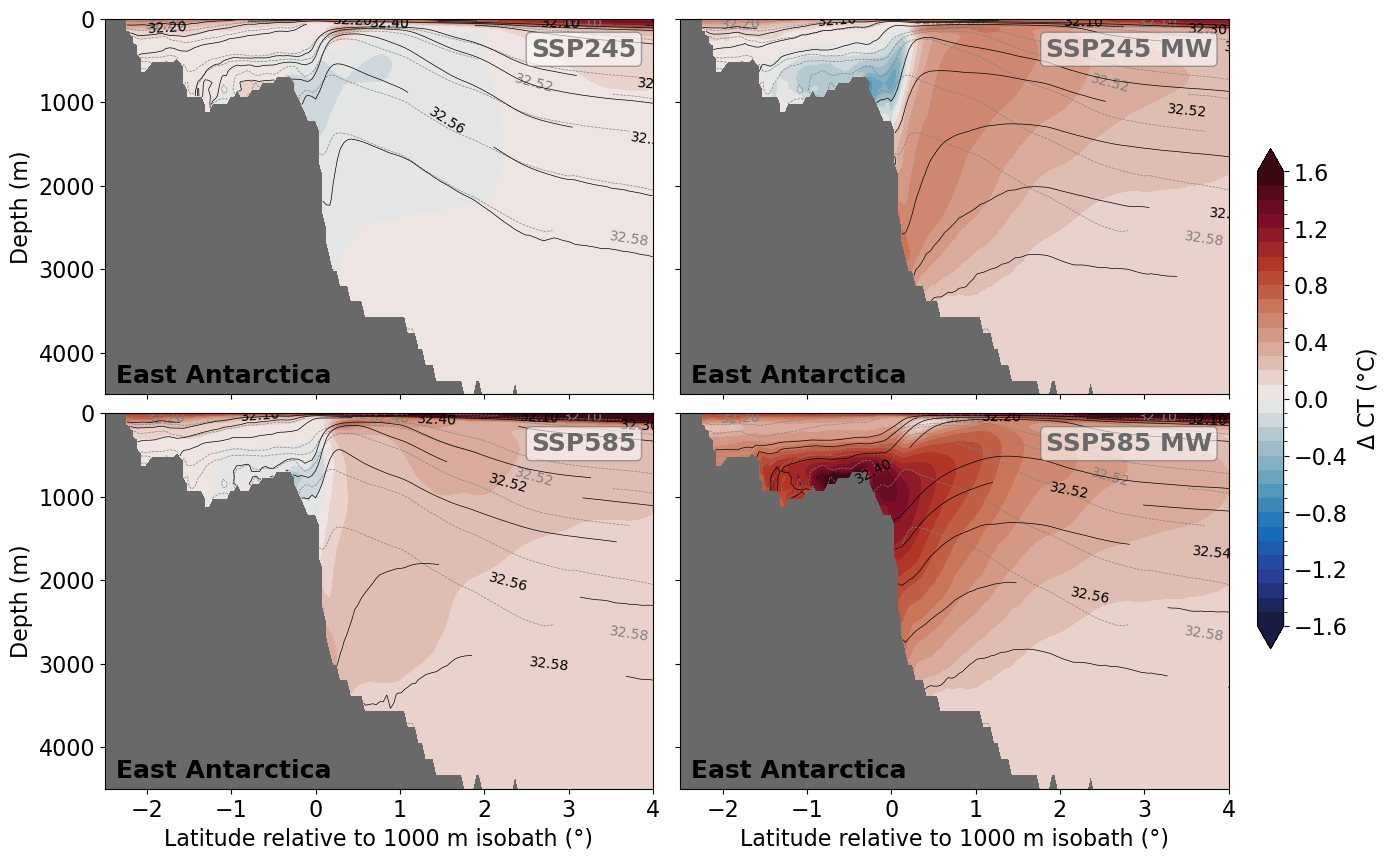

In [76]:
plt.rcParams.update({'font.size': 16})
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14.5,10), sharex=True, sharey=True)
plt.subplots_adjust(wspace=0.05, hspace=0.05)

# shade temperature
axes[0,0].contourf(ssp245_mean.yt_isobath_rel, ssp245_mean.st_ocean, ssp245_mean - control_mean,
                   cmap=cmap, norm=mpl.colors.BoundaryNorm(levels,ncolors=cmap.N, clip=False), 
                   levels=levels, extend='both')
axes[0,1].contourf(ssp245mw_mean.yt_isobath_rel, ssp245mw_mean.st_ocean, ssp245mw_mean - control_mean,
                   cmap=cmap, norm=mpl.colors.BoundaryNorm(levels,ncolors=cmap.N, clip=False), 
                   levels=levels, extend='both')
axes[1,0].contourf(ssp585_mean.yt_isobath_rel, ssp585_mean.st_ocean, ssp585_mean - control_mean,
                   cmap=cmap, norm=mpl.colors.BoundaryNorm(levels,ncolors=cmap.N, clip=False), 
                   levels=levels, extend='both')
cb = axes[1,1].contourf(ssp585mw_mean.yt_isobath_rel, ssp585mw_mean.st_ocean, ssp585mw_mean - control_mean,
                   cmap=cmap, norm=mpl.colors.BoundaryNorm(levels,ncolors=cmap.N, clip=False), 
                   levels=levels, extend='both')
colorbar_vert(cb, [0.92, 0.25, 0.018, 0.5], '$\Delta$ CT (\u00b0C)')

# plot contours
lvls = np.concatenate((np.arange(32.1, 32.5, 0.1), np.arange(32.5,34,0.02)))
for i, ax in enumerate(axes.flatten()):
    cs = ax.contour(control_mean_sig1.yt_isobath_rel, control_mean_sig1.st_ocean, 
                    control_mean_sig1, levels=lvls, colors='grey', linewidths=0.5, linestyles='--', zorder=2)
    ax.clabel(cs, lvls,use_clabeltext=True, fontsize=10, zorder=2)
cs = axes[0,0].contour(ssp245_mean_sig1.yt_isobath_rel, ssp245_mean_sig1.st_ocean, 
                       ssp245_mean_sig1, levels=lvls, colors='k', linewidths=0.5, zorder=2)
axes[0,0].clabel(cs, lvls,use_clabeltext=True, fontsize=10, zorder=2)
cs = axes[0,1].contour(ssp245mw_mean_sig1.yt_isobath_rel, ssp245mw_mean_sig1.st_ocean, 
                       ssp245mw_mean_sig1, levels=lvls, colors='k', linewidths=0.5, zorder=2)
axes[0,1].clabel(cs, lvls,use_clabeltext=True, fontsize=10, zorder=2)
cs = axes[1,0].contour(ssp585_mean_sig1.yt_isobath_rel, ssp585_mean_sig1.st_ocean, 
                       ssp585_mean_sig1, levels=lvls, colors='k', linewidths=0.5, zorder=2)
axes[1,0].clabel(cs, lvls,use_clabeltext=True, fontsize=10, zorder=2)
cs = axes[1,1].contour(ssp585mw_mean_sig1.yt_isobath_rel, ssp585mw_mean_sig1.st_ocean, 
                       ssp585mw_mean_sig1, levels=lvls, colors='k', linewidths=0.5, zorder=2)
axes[1,1].clabel(cs, lvls,use_clabeltext=True, fontsize=10, zorder=2)

axes[0,0].invert_yaxis()
axes[0,0].set_ylim([4500,0])
axes[0,0].set_xlim([-2.5,4])
axes[0,0].set_facecolor('dimgrey')
axes[0,1].set_facecolor('dimgrey')
axes[1,0].set_facecolor('dimgrey')
axes[1,1].set_facecolor('dimgrey')

axes[0,0].set_ylabel('Depth (m)')
axes[1,0].set_ylabel('Depth (m)')
axes[1,0].set_xlabel('Latitude relative to 1000 m isobath (\u00b0)')
axes[1,1].set_xlabel('Latitude relative to 1000 m isobath (\u00b0)')

labels = ['SSP245','SSP245 MW','SSP585','SSP585 MW']
for i, ax in enumerate(axes.flatten()):
    ax.text(0.02, 0.03, f'East Antarctica',  c='k', fontsize=18, ha='left', fontweight='bold', transform=ax.transAxes)
    ax.text(0.97, 0.9, f'{labels[i]}', fontsize=18, fontweight='bold', color='dimgrey', ha='right', transform=ax.transAxes,
            bbox=dict(facecolor='w', alpha=0.6, edgecolor='dimgrey', boxstyle='round,pad=0.2'), zorder=3)

# save to file
save_flag = 1
figfile = f'../figs/SuppFig_temp_anomaly_transect_isobath_adjusted_{region}.jpg'
if save_flag == 1:
    fig.savefig(figfile, bbox_inches='tight', dpi=300)


plt.show()

In [17]:
region = 'east_antarctica'
l1 = -230
l2 = -250
l3 = 80

control_mean_plot = control.where(((control.xt_ocean < l1) & (control.xt_ocean >= l2) | (control.xt_ocean  > l3)), np.nan)
control_mean = control.where(((control.xt_ocean < l1) & (control.xt_ocean >= l2) | (control.xt_ocean  > l3)), np.nan).mean('xt_ocean')
ssp245_mean = ssp245.where(((control.xt_ocean < l1) & (control.xt_ocean >= l2) | (control.xt_ocean  > l3)), np.nan).mean('xt_ocean')
ssp245mw_mean = ssp245mw.where(((control.xt_ocean < l1) & (control.xt_ocean >= l2) | (control.xt_ocean  > l3)), np.nan).mean('xt_ocean')
ssp585_mean = ssp585.where(((control.xt_ocean < l1) & (control.xt_ocean >= l2) | (control.xt_ocean  > l3)), np.nan).mean('xt_ocean')
ssp585mw_mean = ssp585mw.where(((control.xt_ocean < l1) & (control.xt_ocean >= l2) | (control.xt_ocean  > l3)), np.nan).mean('xt_ocean')

# sigma1
control_mean_sig1 = control_sig1.where(((control.xt_ocean < l1) & (control.xt_ocean >= l2) | (control.xt_ocean  > l3)), np.nan).mean('xt_ocean')
ssp245_mean_sig1 = ssp245_sig1.where(((control.xt_ocean < l1) & (control.xt_ocean >= l2) | (control.xt_ocean  > l3)), np.nan).mean('xt_ocean')
ssp245mw_mean_sig1 = ssp245mw_sig1.where(((control.xt_ocean < l1) & (control.xt_ocean >= l2) | (control.xt_ocean  > l3)), np.nan).mean('xt_ocean')
ssp585_mean_sig1 = ssp585_sig1.where(((control.xt_ocean < l1) & (control.xt_ocean >= l2) | (control.xt_ocean  > l3)), np.nan).mean('xt_ocean')
ssp585mw_mean_sig1 = ssp585mw_sig1.where(((control.xt_ocean < l1) & (control.xt_ocean >= l2) | (control.xt_ocean  > l3)), np.nan).mean('xt_ocean')

In [16]:
print(-230+360, -250+360)

130 110


Plot figure. 

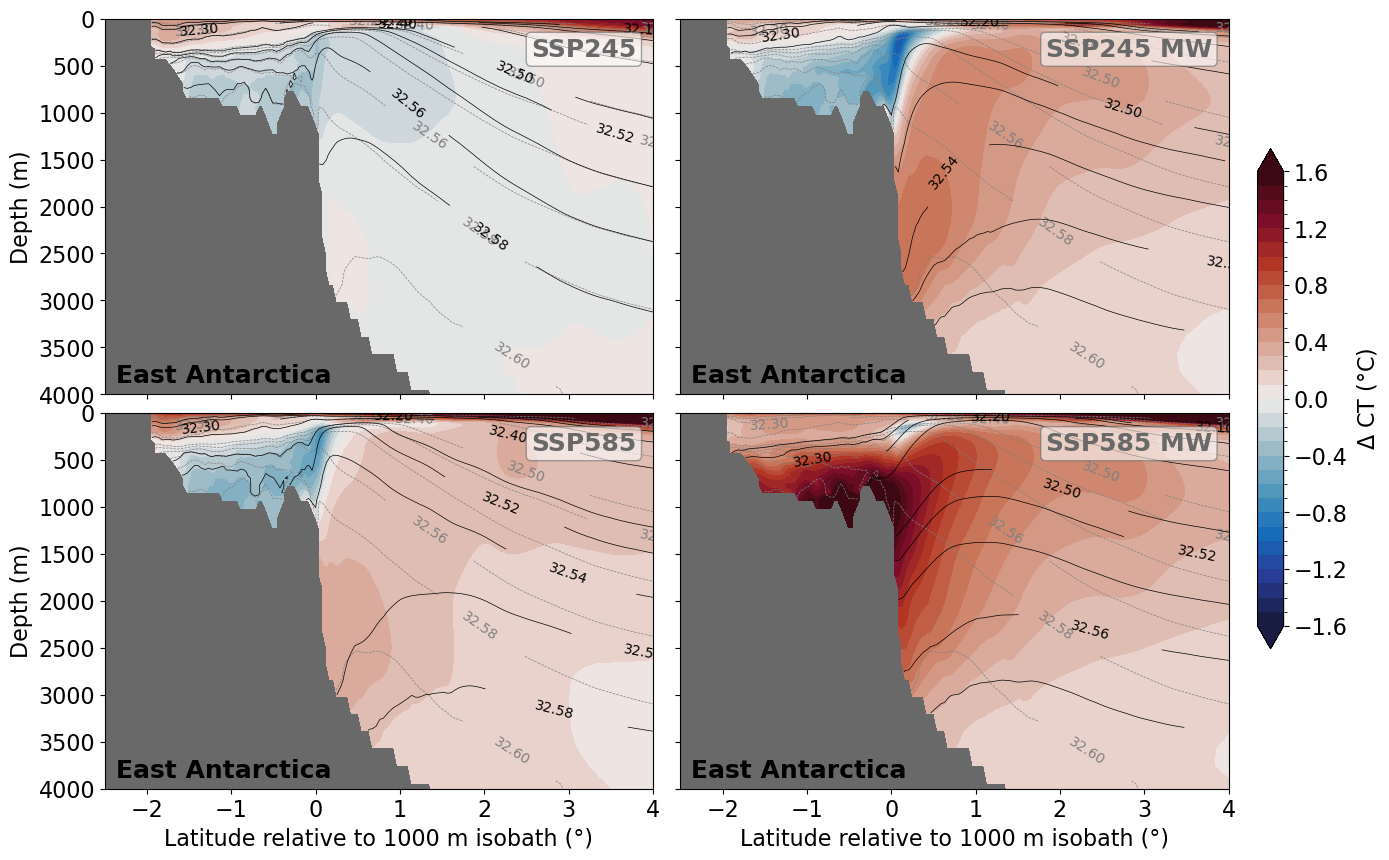

In [18]:
plt.rcParams.update({'font.size': 16})
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14.5,10), sharex=True, sharey=True)
plt.subplots_adjust(wspace=0.05, hspace=0.05)

# shade temperature
axes[0,0].contourf(ssp245_mean.yt_isobath_rel, ssp245_mean.st_ocean, ssp245_mean - control_mean,
                   cmap=cmap, norm=mpl.colors.BoundaryNorm(levels,ncolors=cmap.N, clip=False), 
                   levels=levels, extend='both')
axes[0,1].contourf(ssp245mw_mean.yt_isobath_rel, ssp245mw_mean.st_ocean, ssp245mw_mean - control_mean,
                   cmap=cmap, norm=mpl.colors.BoundaryNorm(levels,ncolors=cmap.N, clip=False), 
                   levels=levels, extend='both')
axes[1,0].contourf(ssp585_mean.yt_isobath_rel, ssp585_mean.st_ocean, ssp585_mean - control_mean,
                   cmap=cmap, norm=mpl.colors.BoundaryNorm(levels,ncolors=cmap.N, clip=False), 
                   levels=levels, extend='both')
cb = axes[1,1].contourf(ssp585mw_mean.yt_isobath_rel, ssp585mw_mean.st_ocean, ssp585mw_mean - control_mean,
                   cmap=cmap, norm=mpl.colors.BoundaryNorm(levels,ncolors=cmap.N, clip=False), 
                   levels=levels, extend='both')
colorbar_vert(cb, [0.92, 0.25, 0.018, 0.5], '$\Delta$ CT (\u00b0C)')

# plot contours
lvls = np.concatenate((np.arange(32.1, 32.5, 0.1), np.arange(32.5,34,0.02)))
for i, ax in enumerate(axes.flatten()):
    cs = ax.contour(control_mean_sig1.yt_isobath_rel, control_mean_sig1.st_ocean, 
                    control_mean_sig1, levels=lvls, colors='grey', linewidths=0.5, linestyles='--', zorder=2)
    ax.clabel(cs, lvls,use_clabeltext=True, fontsize=10, zorder=2)
cs = axes[0,0].contour(ssp245_mean_sig1.yt_isobath_rel, ssp245_mean_sig1.st_ocean, 
                       ssp245_mean_sig1, levels=lvls, colors='k', linewidths=0.5, zorder=2)
axes[0,0].clabel(cs, lvls,use_clabeltext=True, fontsize=10, zorder=2)
cs = axes[0,1].contour(ssp245mw_mean_sig1.yt_isobath_rel, ssp245mw_mean_sig1.st_ocean, 
                       ssp245mw_mean_sig1, levels=lvls, colors='k', linewidths=0.5, zorder=2)
axes[0,1].clabel(cs, lvls,use_clabeltext=True, fontsize=10, zorder=2)
cs = axes[1,0].contour(ssp585_mean_sig1.yt_isobath_rel, ssp585_mean_sig1.st_ocean, 
                       ssp585_mean_sig1, levels=lvls, colors='k', linewidths=0.5, zorder=2)
axes[1,0].clabel(cs, lvls,use_clabeltext=True, fontsize=10, zorder=2)
cs = axes[1,1].contour(ssp585mw_mean_sig1.yt_isobath_rel, ssp585mw_mean_sig1.st_ocean, 
                       ssp585mw_mean_sig1, levels=lvls, colors='k', linewidths=0.5, zorder=2)
axes[1,1].clabel(cs, lvls,use_clabeltext=True, fontsize=10, zorder=2)

axes[0,0].invert_yaxis()
axes[0,0].set_ylim([4000,0])
axes[0,0].set_xlim([-2.5,4])
axes[0,0].set_facecolor('dimgrey')
axes[0,1].set_facecolor('dimgrey')
axes[1,0].set_facecolor('dimgrey')
axes[1,1].set_facecolor('dimgrey')

axes[0,0].set_ylabel('Depth (m)')
axes[1,0].set_ylabel('Depth (m)')
axes[1,0].set_xlabel('Latitude relative to 1000 m isobath (\u00b0)')
axes[1,1].set_xlabel('Latitude relative to 1000 m isobath (\u00b0)')

labels = ['SSP245','SSP245 MW','SSP585','SSP585 MW']
for i, ax in enumerate(axes.flatten()):
    ax.text(0.02, 0.03, f'East Antarctica',  c='k', fontsize=18, ha='left', fontweight='bold', transform=ax.transAxes)
    ax.text(0.97, 0.9, f'{labels[i]}', fontsize=18, fontweight='bold', color='dimgrey', ha='right', transform=ax.transAxes,
            bbox=dict(facecolor='w', alpha=0.6, edgecolor='dimgrey', boxstyle='round,pad=0.2'), zorder=3)

# save to file
save_flag = 1
figfile = f'../figs/SuppFig_temp_anomaly_transect_isobath_adjusted_{region}_110-130E.jpg'
if save_flag == 1:
    fig.savefig(figfile, bbox_inches='tight', dpi=300)


plt.show()

In [55]:
region = 'ross'
control_mean = control.where(((control.xt_ocean < -155) & ((control.xt_ocean  > -198))), np.nan).mean('xt_ocean')
ssp245_mean = ssp245.where(((ssp245.xt_ocean < -155) & ((ssp245.xt_ocean  > -198))), np.nan).mean('xt_ocean')
ssp245mw_mean = ssp245mw.where(((ssp245.xt_ocean < -155) & ((ssp245.xt_ocean  > -198))), np.nan).mean('xt_ocean')
ssp585_mean = ssp585.where(((ssp245.xt_ocean < -155) & ((ssp245.xt_ocean  > -198))), np.nan).mean('xt_ocean')
ssp585mw_mean = ssp585mw.where(((ssp245.xt_ocean < -155) & ((ssp245.xt_ocean  > -198))), np.nan).mean('xt_ocean')

control_mean_sig1 = control_sig1.where(((control.xt_ocean < -155) & ((control.xt_ocean  > -198))), np.nan).mean('xt_ocean')
ssp245_mean_sig1 = ssp245_sig1.where(((ssp245.xt_ocean < -155) & ((ssp245.xt_ocean  > -198))), np.nan).mean('xt_ocean')
ssp245mw_mean_sig1 = ssp245mw_sig1.where(((ssp245.xt_ocean < -155) & ((ssp245.xt_ocean  > -198))), np.nan).mean('xt_ocean')
ssp585_mean_sig1 = ssp585_sig1.where(((ssp245.xt_ocean < -155) & ((ssp245.xt_ocean  > -198))), np.nan).mean('xt_ocean')
ssp585mw_mean_sig1 = ssp585mw_sig1.where(((ssp245.xt_ocean < -155) & ((ssp245.xt_ocean  > -198))), np.nan).mean('xt_ocean')

Plot figure. 

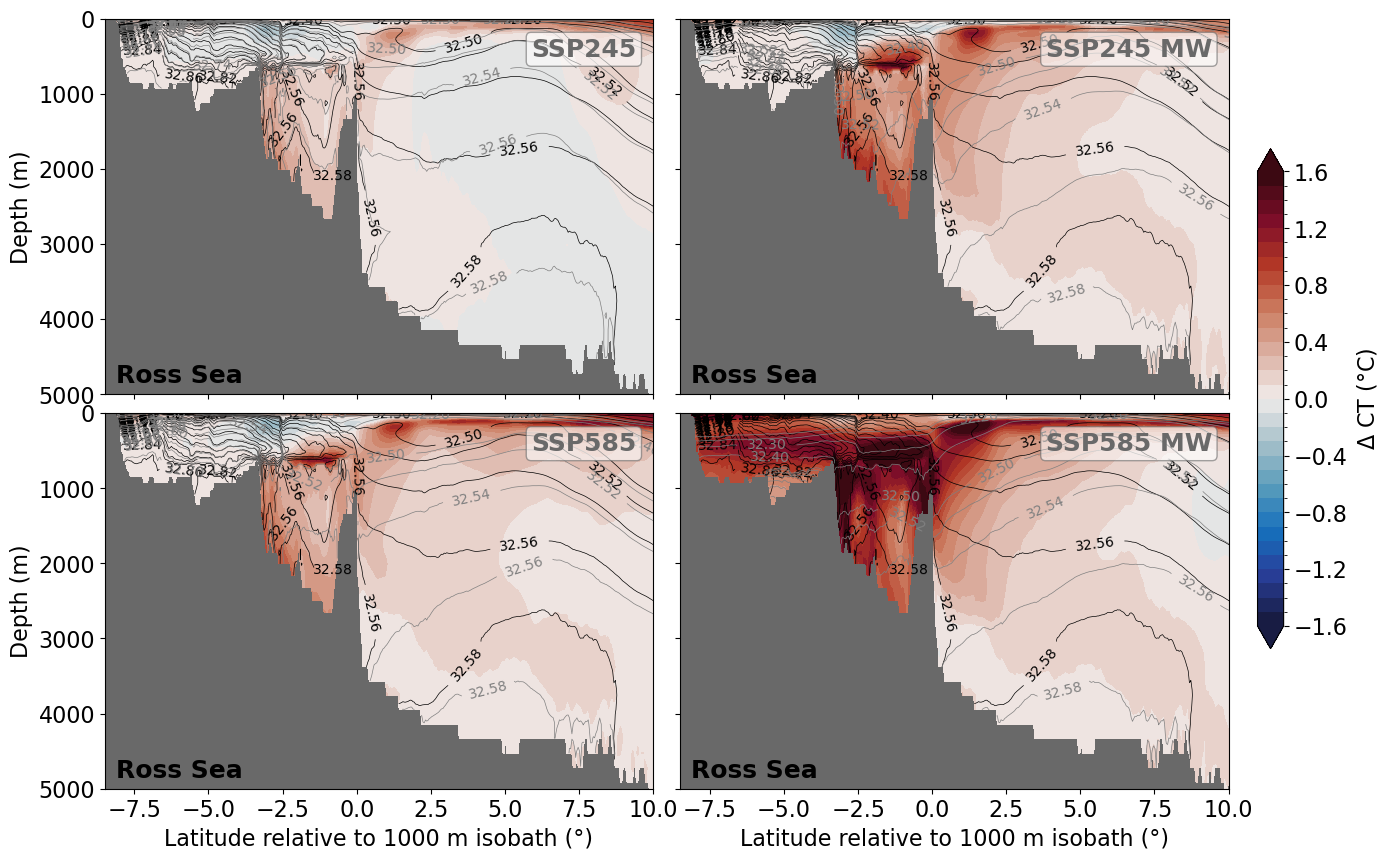

In [56]:
plt.rcParams.update({'font.size': 16})
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14.5,10), sharex=True, sharey=True)
plt.subplots_adjust(wspace=0.05, hspace=0.05)

axes[0,0].contourf(ssp245_mean.yt_isobath_rel, ssp245_mean.st_ocean, ssp245_mean - control_mean,
                   cmap=cmap, norm=mpl.colors.BoundaryNorm(levels,ncolors=cmap.N, clip=False), 
                   levels=levels, extend='both')
axes[0,1].contourf(ssp245mw_mean.yt_isobath_rel, ssp245mw_mean.st_ocean, ssp245mw_mean - control_mean,
                   cmap=cmap, norm=mpl.colors.BoundaryNorm(levels,ncolors=cmap.N, clip=False), 
                   levels=levels, extend='both')
axes[1,0].contourf(ssp585_mean.yt_isobath_rel, ssp585_mean.st_ocean, ssp585_mean - control_mean,
                   cmap=cmap, norm=mpl.colors.BoundaryNorm(levels,ncolors=cmap.N, clip=False), 
                   levels=levels, extend='both')
cb = axes[1,1].contourf(ssp585mw_mean.yt_isobath_rel, ssp585mw_mean.st_ocean, ssp585mw_mean - control_mean,
                   cmap=cmap, norm=mpl.colors.BoundaryNorm(levels,ncolors=cmap.N, clip=False), 
                   levels=levels, extend='both')
colorbar_vert(cb, [0.92, 0.25, 0.018, 0.5], '$\Delta$ CT (\u00b0C)')

# plot contours
lvls = np.concatenate((np.arange(32.1, 32.5, 0.1), np.arange(32.5,34,0.02)))
for i, ax in enumerate(axes.flatten()):
    cs = ax.contour(control_mean_sig1.yt_isobath_rel, control_mean_sig1.st_ocean, 
                    control_mean_sig1, levels=lvls, colors='k', linewidths=0.5, zorder=2)
    ax.clabel(cs, lvls,use_clabeltext=True, fontsize=10, zorder=2)
cs = axes[0,0].contour(ssp245_mean_sig1.yt_isobath_rel, ssp245_mean_sig1.st_ocean, 
                       ssp245_mean_sig1, levels=lvls, colors='grey', linewidths=0.5, zorder=2)
axes[0,0].clabel(cs, lvls,use_clabeltext=True, fontsize=10, zorder=2)
cs = axes[0,1].contour(ssp245mw_mean_sig1.yt_isobath_rel, ssp245mw_mean_sig1.st_ocean, 
                       ssp245mw_mean_sig1, levels=lvls, colors='grey', linewidths=0.5, zorder=2)
axes[0,1].clabel(cs, lvls,use_clabeltext=True, fontsize=10, zorder=2)
cs = axes[1,0].contour(ssp585_mean_sig1.yt_isobath_rel, ssp585_mean_sig1.st_ocean, 
                       ssp585_mean_sig1, levels=lvls, colors='grey', linewidths=0.5, zorder=2)
axes[1,0].clabel(cs, lvls,use_clabeltext=True, fontsize=10, zorder=2)
cs = axes[1,1].contour(ssp585mw_mean_sig1.yt_isobath_rel, ssp585mw_mean_sig1.st_ocean, 
                       ssp585mw_mean_sig1, levels=lvls, colors='grey', linewidths=0.5, zorder=2)
axes[1,1].clabel(cs, lvls,use_clabeltext=True, fontsize=10, zorder=2)

axes[0,0].invert_yaxis()
axes[0,0].set_ylim([5000,0])
axes[0,0].set_xlim([-8.5,10])
axes[0,0].set_facecolor('dimgrey')
axes[0,1].set_facecolor('dimgrey')
axes[1,0].set_facecolor('dimgrey')
axes[1,1].set_facecolor('dimgrey')

axes[0,0].set_ylabel('Depth (m)')
axes[1,0].set_ylabel('Depth (m)')
axes[1,0].set_xlabel('Latitude relative to 1000 m isobath (\u00b0)')
axes[1,1].set_xlabel('Latitude relative to 1000 m isobath (\u00b0)')

labels = ['SSP245','SSP245 MW','SSP585','SSP585 MW']
for i, ax in enumerate(axes.flatten()):
    ax.text(0.02, 0.03, f'Ross Sea',  c='k', fontsize=18, ha='left', fontweight='bold', transform=ax.transAxes)
    ax.text(0.97, 0.9, f'{labels[i]}', fontsize=18, fontweight='bold', color='dimgrey', ha='right', transform=ax.transAxes,
            bbox=dict(facecolor='w', alpha=0.6, edgecolor='dimgrey', boxstyle='round,pad=0.2'))

# save to file
save_flag = 1
figfile = f'../figs/SuppFig_temp_anomaly_transect_isobath_adjusted_{region}.jpg'
if save_flag == 1:
    fig.savefig(figfile, bbox_inches='tight', dpi=300)


plt.show()

From Huneke et al. (2022):
-280 to -240 
-165 to -130
-20 to 40
70 to 80

In [67]:
region = 'fresh'
control_mean = control.where((ssp245.xt_ocean<-240) | ((ssp245.xt_ocean>-165)&(ssp245.xt_ocean<-130)) | ((ssp245.xt_ocean>-20) & (ssp245.xt_ocean<40)) | (ssp245.xt_ocean>70), np.nan).mean('xt_ocean')
ssp245_mean = ssp245.where((ssp245.xt_ocean<-240) | ((ssp245.xt_ocean>-165)&(ssp245.xt_ocean<-130)) | ((ssp245.xt_ocean>-20) & (ssp245.xt_ocean<40)) | (ssp245.xt_ocean>70), np.nan).mean('xt_ocean')
ssp245mw_mean = ssp245mw.where((ssp245.xt_ocean<-240) | ((ssp245.xt_ocean>-165)&(ssp245.xt_ocean<-130)) | ((ssp245.xt_ocean>-20) & (ssp245.xt_ocean<40)) | (ssp245.xt_ocean>70), np.nan).mean('xt_ocean')
ssp585_mean = ssp585.where((ssp245.xt_ocean<-240) | ((ssp245.xt_ocean>-165)&(ssp245.xt_ocean<-130)) | ((ssp245.xt_ocean>-20) & (ssp245.xt_ocean<40)) | (ssp245.xt_ocean>70), np.nan).mean('xt_ocean')
ssp585mw_mean = ssp585mw.where((ssp245.xt_ocean<-240) | ((ssp245.xt_ocean>-165)&(ssp245.xt_ocean<-130)) | ((ssp245.xt_ocean>-20) & (ssp245.xt_ocean<40)) | (ssp245.xt_ocean>70), np.nan).mean('xt_ocean')


control_mean_sig1 = control_sig1.where((ssp245.xt_ocean<-240) | ((ssp245.xt_ocean>-165)&(ssp245.xt_ocean<-130)) | ((ssp245.xt_ocean>-20) & (ssp245.xt_ocean<40)) | (ssp245.xt_ocean>70), np.nan).mean('xt_ocean')
ssp245_mean_sig1 = ssp245_sig1.where((ssp245.xt_ocean<-240) | ((ssp245.xt_ocean>-165)&(ssp245.xt_ocean<-130)) | ((ssp245.xt_ocean>-20) & (ssp245.xt_ocean<40)) | (ssp245.xt_ocean>70), np.nan).mean('xt_ocean')
ssp245mw_mean_sig1 = ssp245mw_sig1.where((ssp245.xt_ocean<-240) | ((ssp245.xt_ocean>-165)&(ssp245.xt_ocean<-130)) | ((ssp245.xt_ocean>-20) & (ssp245.xt_ocean<40)) | (ssp245.xt_ocean>70), np.nan).mean('xt_ocean')
ssp585_mean_sig1 = ssp585_sig1.where((ssp245.xt_ocean<-240) | ((ssp245.xt_ocean>-165)&(ssp245.xt_ocean<-130)) | ((ssp245.xt_ocean>-20) & (ssp245.xt_ocean<40)) | (ssp245.xt_ocean>70), np.nan).mean('xt_ocean')
ssp585mw_mean_sig1 = ssp585mw_sig1.where((ssp245.xt_ocean<-240) | ((ssp245.xt_ocean>-165)&(ssp245.xt_ocean<-130)) | ((ssp245.xt_ocean>-20) & (ssp245.xt_ocean<40)) | (ssp245.xt_ocean>70), np.nan).mean('xt_ocean')


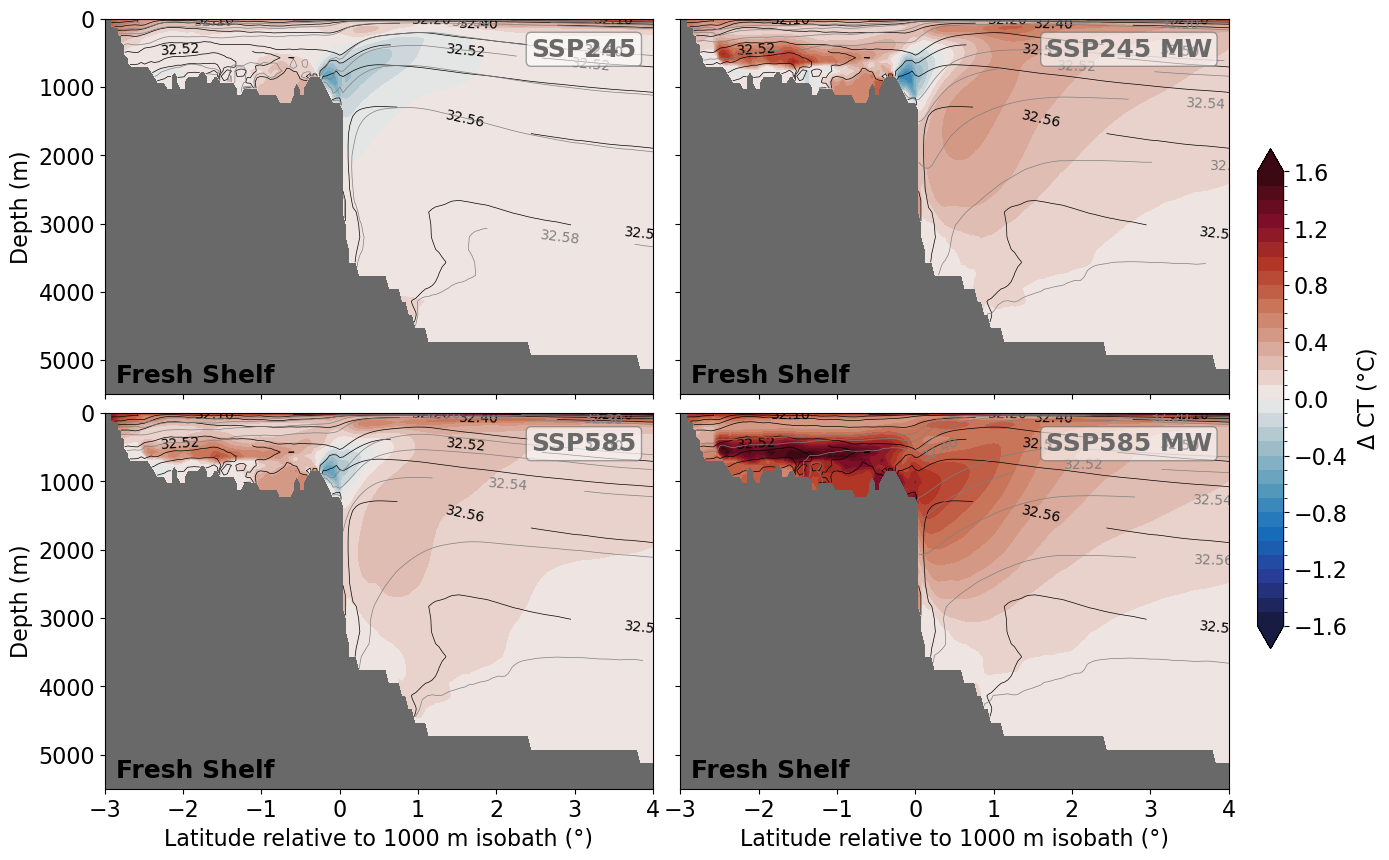

In [68]:
plt.rcParams.update({'font.size': 16})
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14.5,10), sharex=True, sharey=True)
plt.subplots_adjust(wspace=0.05, hspace=0.05)

# shade temperature
axes[0,0].contourf(ssp245_mean.yt_isobath_rel, ssp245_mean.st_ocean, ssp245_mean - control_mean,
                   cmap=cmap, norm=mpl.colors.BoundaryNorm(levels,ncolors=cmap.N, clip=False), 
                   levels=levels, extend='both')
axes[0,1].contourf(ssp245mw_mean.yt_isobath_rel, ssp245mw_mean.st_ocean, ssp245mw_mean - control_mean,
                   cmap=cmap, norm=mpl.colors.BoundaryNorm(levels,ncolors=cmap.N, clip=False), 
                   levels=levels, extend='both')
axes[1,0].contourf(ssp585_mean.yt_isobath_rel, ssp585_mean.st_ocean, ssp585_mean - control_mean,
                   cmap=cmap, norm=mpl.colors.BoundaryNorm(levels,ncolors=cmap.N, clip=False), 
                   levels=levels, extend='both')
cb = axes[1,1].contourf(ssp585mw_mean.yt_isobath_rel, ssp585mw_mean.st_ocean, ssp585mw_mean - control_mean,
                   cmap=cmap, norm=mpl.colors.BoundaryNorm(levels,ncolors=cmap.N, clip=False), 
                   levels=levels, extend='both')
colorbar_vert(cb, [0.92, 0.25, 0.018, 0.5], '$\Delta$ CT (\u00b0C)')

# plot contours
lvls = np.concatenate((np.arange(32.1, 32.5, 0.1), np.arange(32.5,34,0.02)))
for i, ax in enumerate(axes.flatten()):
    cs = ax.contour(control_mean_sig1.yt_isobath_rel[:-150], control_mean_sig1.st_ocean, 
                    control_mean_sig1[:,:-150], levels=lvls, colors='k', linewidths=0.5, zorder=2)
    ax.clabel(cs, lvls,use_clabeltext=True, fontsize=10, zorder=2)
cs = axes[0,0].contour(ssp245_mean_sig1.yt_isobath_rel, ssp245_mean_sig1.st_ocean, 
                       ssp245_mean_sig1, levels=lvls, colors='grey', linewidths=0.5, zorder=2)
axes[0,0].clabel(cs, lvls,use_clabeltext=True, fontsize=10, zorder=2)
cs = axes[0,1].contour(ssp245mw_mean_sig1.yt_isobath_rel, ssp245mw_mean_sig1.st_ocean, 
                       ssp245mw_mean_sig1, levels=lvls, colors='grey', linewidths=0.5, zorder=2)
axes[0,1].clabel(cs, lvls,use_clabeltext=True, fontsize=10, zorder=2)
cs = axes[1,0].contour(ssp585_mean_sig1.yt_isobath_rel, ssp585_mean_sig1.st_ocean, 
                       ssp585_mean_sig1, levels=lvls, colors='grey', linewidths=0.5, zorder=2)
axes[1,0].clabel(cs, lvls,use_clabeltext=True, fontsize=10, zorder=2)
cs = axes[1,1].contour(ssp585mw_mean_sig1.yt_isobath_rel, ssp585mw_mean_sig1.st_ocean, 
                       ssp585mw_mean_sig1, levels=lvls, colors='grey', linewidths=0.5, zorder=2)
axes[1,1].clabel(cs, lvls,use_clabeltext=True, fontsize=10, zorder=2)

axes[0,0].invert_yaxis()
axes[0,0].set_ylim([5500,0])
axes[0,0].set_xlim([-3,4])
axes[0,0].set_facecolor('dimgrey')
axes[0,1].set_facecolor('dimgrey')
axes[1,0].set_facecolor('dimgrey')
axes[1,1].set_facecolor('dimgrey')

axes[0,0].set_ylabel('Depth (m)')
axes[1,0].set_ylabel('Depth (m)')
axes[1,0].set_xlabel('Latitude relative to 1000 m isobath (\u00b0)')
axes[1,1].set_xlabel('Latitude relative to 1000 m isobath (\u00b0)')

labels = ['SSP245','SSP245 MW','SSP585','SSP585 MW']
for i, ax in enumerate(axes.flatten()):
    ax.text(0.02, 0.03, f'Fresh Shelf',  c='k', fontsize=18, ha='left', fontweight='bold', transform=ax.transAxes)
    ax.text(0.97, 0.9, f'{labels[i]}', fontsize=18, fontweight='bold', color='dimgrey', ha='right', transform=ax.transAxes,
            bbox=dict(facecolor='w', alpha=0.6, edgecolor='dimgrey', boxstyle='round,pad=0.2'))

# save to file
save_flag = 0
figfile = f'../figs/SuppFig_temp_anomaly_transect_isobath_adjusted_{region}.jpg'
if save_flag == 1:
    fig.savefig(figfile, bbox_inches='tight', dpi=300)


plt.show()

From Huneke et al. (2022):
-240 to -200 
-195 to -170
-60 to -20
40 to 70

In [69]:
region = 'dense'
control_mean = control.where(((control.xt_ocean>-240)&(control.xt_ocean<-200)) | ((control.xt_ocean>-195)&(ssp245.xt_ocean<-170)) | ((ssp245.xt_ocean>-60) & (ssp245.xt_ocean<-20)) | ((ssp245.xt_ocean>40) & (ssp245.xt_ocean<70)), np.nan).mean('xt_ocean')
ssp245_mean = ssp245.where(((ssp245.xt_ocean>-240)&(ssp245.xt_ocean<-200)) | ((ssp245.xt_ocean>-195)&(ssp245.xt_ocean<-170)) | ((ssp245.xt_ocean>-60) & (ssp245.xt_ocean<-20)) | ((ssp245.xt_ocean>40) & (ssp245.xt_ocean<70)), np.nan).mean('xt_ocean')
ssp245mw_mean = ssp245mw.where(((ssp245.xt_ocean>-240)&(ssp245.xt_ocean<-200)) | ((ssp245.xt_ocean>-195)&(ssp245.xt_ocean<-170)) | ((ssp245.xt_ocean>-60) & (ssp245.xt_ocean<-20)) | ((ssp245.xt_ocean>40) & (ssp245.xt_ocean<70)), np.nan).mean('xt_ocean')
ssp585_mean = ssp585.where(((ssp245.xt_ocean>-240)&(ssp245.xt_ocean<-200)) | ((ssp245.xt_ocean>-195)&(ssp245.xt_ocean<-170)) | ((ssp245.xt_ocean>-60) & (ssp245.xt_ocean<-20)) | ((ssp245.xt_ocean>40) & (ssp245.xt_ocean<70)), np.nan).mean('xt_ocean')
ssp585mw_mean = ssp585mw.where(((ssp245.xt_ocean>-240)&(ssp245.xt_ocean<-200)) | ((ssp245.xt_ocean>-195)&(ssp245.xt_ocean<-170)) | ((ssp245.xt_ocean>-60) & (ssp245.xt_ocean<-20)) | ((ssp245.xt_ocean>40) & (ssp245.xt_ocean<70)), np.nan).mean('xt_ocean')

control_mean_sig1 = control_sig1.where(((control.xt_ocean>-240)&(control.xt_ocean<-200)) | ((control.xt_ocean>-195)&(ssp245.xt_ocean<-170)) | ((ssp245.xt_ocean>-60) & (ssp245.xt_ocean<-20)) | ((ssp245.xt_ocean>40) & (ssp245.xt_ocean<70)), np.nan).mean('xt_ocean')
ssp245_mean_sig1 = ssp245_sig1.where(((ssp245.xt_ocean>-240)&(ssp245.xt_ocean<-200)) | ((ssp245.xt_ocean>-195)&(ssp245.xt_ocean<-170)) | ((ssp245.xt_ocean>-60) & (ssp245.xt_ocean<-20)) | ((ssp245.xt_ocean>40) & (ssp245.xt_ocean<70)), np.nan).mean('xt_ocean')
ssp245mw_mean_sig1 = ssp245mw_sig1.where(((ssp245.xt_ocean>-240)&(ssp245.xt_ocean<-200)) | ((ssp245.xt_ocean>-195)&(ssp245.xt_ocean<-170)) | ((ssp245.xt_ocean>-60) & (ssp245.xt_ocean<-20)) | ((ssp245.xt_ocean>40) & (ssp245.xt_ocean<70)), np.nan).mean('xt_ocean')
ssp585_mean_sig1 = ssp585_sig1.where(((ssp245.xt_ocean>-240)&(ssp245.xt_ocean<-200)) | ((ssp245.xt_ocean>-195)&(ssp245.xt_ocean<-170)) | ((ssp245.xt_ocean>-60) & (ssp245.xt_ocean<-20)) | ((ssp245.xt_ocean>40) & (ssp245.xt_ocean<70)), np.nan).mean('xt_ocean')
ssp585mw_mean_sig1 = ssp585mw_sig1.where(((ssp245.xt_ocean>-240)&(ssp245.xt_ocean<-200)) | ((ssp245.xt_ocean>-195)&(ssp245.xt_ocean<-170)) | ((ssp245.xt_ocean>-60) & (ssp245.xt_ocean<-20)) | ((ssp245.xt_ocean>40) & (ssp245.xt_ocean<70)), np.nan).mean('xt_ocean')


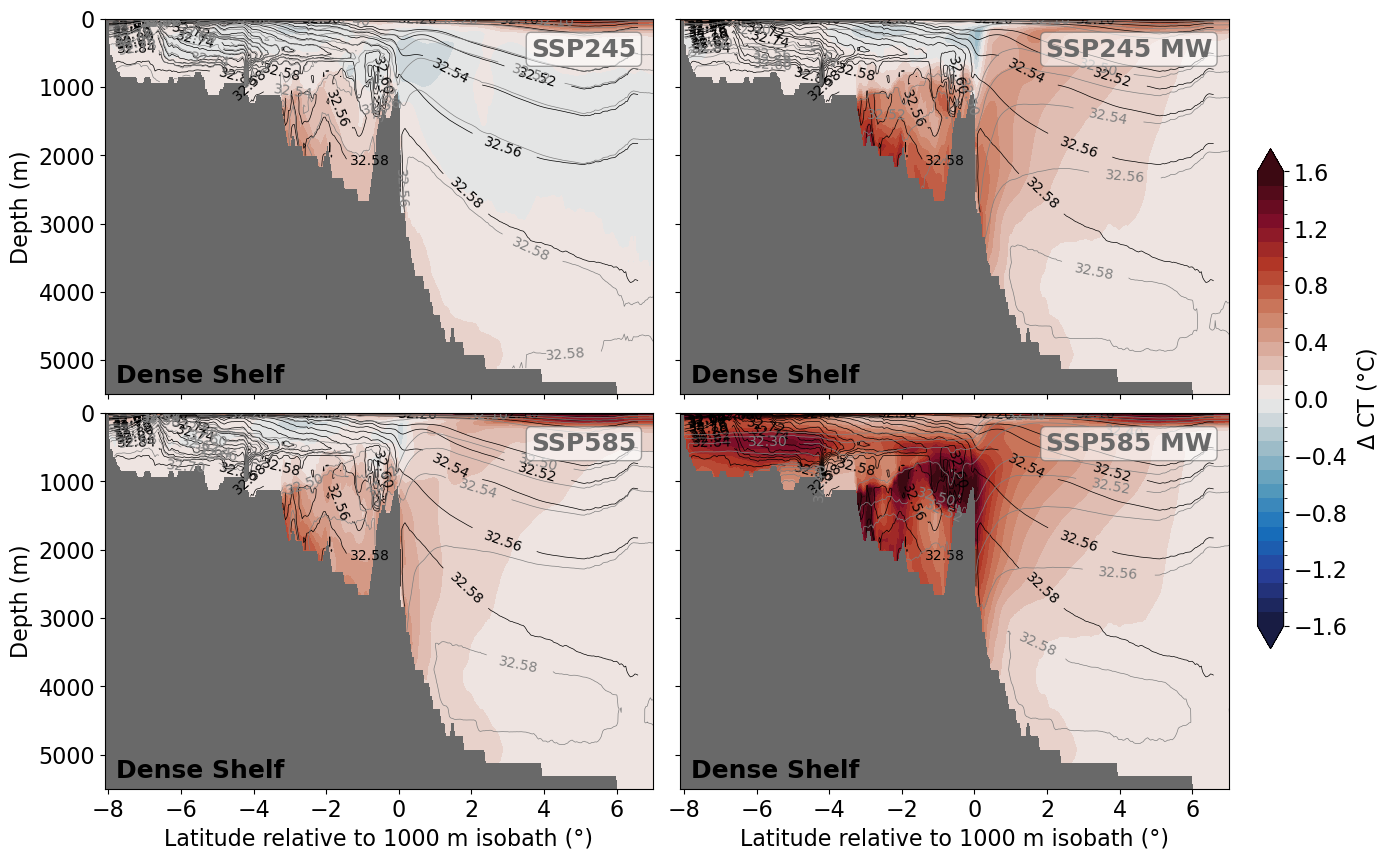

In [70]:
plt.rcParams.update({'font.size': 16})
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14.5,10), sharex=True, sharey=True)
plt.subplots_adjust(wspace=0.05, hspace=0.05)

# shade temperature
axes[0,0].contourf(ssp245_mean.yt_isobath_rel, ssp245_mean.st_ocean, ssp245_mean - control_mean,
                   cmap=cmap, norm=mpl.colors.BoundaryNorm(levels,ncolors=cmap.N, clip=False), 
                   levels=levels, extend='both')
axes[0,1].contourf(ssp245mw_mean.yt_isobath_rel, ssp245mw_mean.st_ocean, ssp245mw_mean - control_mean,
                   cmap=cmap, norm=mpl.colors.BoundaryNorm(levels,ncolors=cmap.N, clip=False), 
                   levels=levels, extend='both')
axes[1,0].contourf(ssp585_mean.yt_isobath_rel, ssp585_mean.st_ocean, ssp585_mean - control_mean,
                   cmap=cmap, norm=mpl.colors.BoundaryNorm(levels,ncolors=cmap.N, clip=False), 
                   levels=levels, extend='both')
cb = axes[1,1].contourf(ssp585mw_mean.yt_isobath_rel, ssp585mw_mean.st_ocean, ssp585mw_mean - control_mean,
                   cmap=cmap, norm=mpl.colors.BoundaryNorm(levels,ncolors=cmap.N, clip=False), 
                   levels=levels, extend='both')
colorbar_vert(cb, [0.92, 0.25, 0.018, 0.5], '$\Delta$ CT (\u00b0C)')

# plot contours
lvls = np.concatenate((np.arange(32.1, 32.5, 0.1), np.arange(32.5,34,0.02)))
for i, ax in enumerate(axes.flatten()):
    cs = ax.contour(control_mean_sig1.yt_isobath_rel[:-150], control_mean_sig1.st_ocean, 
                    control_mean_sig1[:,:-150], levels=lvls, colors='k', linewidths=0.5, zorder=2)
    ax.clabel(cs, lvls,use_clabeltext=True, fontsize=10, zorder=2)
cs = axes[0,0].contour(ssp245_mean_sig1.yt_isobath_rel, ssp245_mean_sig1.st_ocean, 
                       ssp245_mean_sig1, levels=lvls, colors='grey', linewidths=0.5, zorder=2)
axes[0,0].clabel(cs, lvls,use_clabeltext=True, fontsize=10, zorder=2)
cs = axes[0,1].contour(ssp245mw_mean_sig1.yt_isobath_rel, ssp245mw_mean_sig1.st_ocean, 
                       ssp245mw_mean_sig1, levels=lvls, colors='grey', linewidths=0.5, zorder=2)
axes[0,1].clabel(cs, lvls,use_clabeltext=True, fontsize=10, zorder=2)
cs = axes[1,0].contour(ssp585_mean_sig1.yt_isobath_rel, ssp585_mean_sig1.st_ocean, 
                       ssp585_mean_sig1, levels=lvls, colors='grey', linewidths=0.5, zorder=2)
axes[1,0].clabel(cs, lvls,use_clabeltext=True, fontsize=10, zorder=2)
cs = axes[1,1].contour(ssp585mw_mean_sig1.yt_isobath_rel, ssp585mw_mean_sig1.st_ocean, 
                       ssp585mw_mean_sig1, levels=lvls, colors='grey', linewidths=0.5, zorder=2)
axes[1,1].clabel(cs, lvls,use_clabeltext=True, fontsize=10, zorder=2)

axes[0,0].invert_yaxis()
axes[0,0].set_ylim([5500,0])
axes[0,0].set_xlim([-8.1,7])
axes[0,0].set_facecolor('dimgrey')
axes[0,1].set_facecolor('dimgrey')
axes[1,0].set_facecolor('dimgrey')
axes[1,1].set_facecolor('dimgrey')

axes[0,0].set_ylabel('Depth (m)')
axes[1,0].set_ylabel('Depth (m)')
axes[1,0].set_xlabel('Latitude relative to 1000 m isobath (\u00b0)')
axes[1,1].set_xlabel('Latitude relative to 1000 m isobath (\u00b0)')

labels = ['SSP245','SSP245 MW','SSP585','SSP585 MW']
for i, ax in enumerate(axes.flatten()):
    ax.text(0.02, 0.03, f'Dense Shelf',  c='k', fontsize=18, ha='left', fontweight='bold', transform=ax.transAxes)
    ax.text(0.97, 0.9, f'{labels[i]}', fontsize=18, fontweight='bold', color='dimgrey', ha='right', transform=ax.transAxes,
            bbox=dict(facecolor='w', alpha=0.6, edgecolor='dimgrey', boxstyle='round,pad=0.2'))

# save to file
save_flag = 1
figfile = f'../figs/SuppFig_temp_anomaly_transect_isobath_adjusted_{region}.jpg'
if save_flag == 1:
    fig.savefig(figfile, bbox_inches='tight', dpi=300)


plt.show()

In [71]:
region = 'warm'
control_mean = control.where(((control.xt_ocean>-130)&(control.xt_ocean<-65)), np.nan).mean('xt_ocean')
ssp245_mean = ssp245.where(((ssp245.xt_ocean>-130)&(ssp245.xt_ocean<-65)), np.nan).mean('xt_ocean')
ssp245mw_mean = ssp245mw.where(((ssp245.xt_ocean>-130)&(ssp245.xt_ocean<-65)), np.nan).mean('xt_ocean')
ssp585_mean = ssp585.where(((ssp245.xt_ocean>-130)&(ssp245.xt_ocean<-65)), np.nan).mean('xt_ocean')
ssp585mw_mean = ssp585mw.where(((ssp245.xt_ocean>-130)&(ssp245.xt_ocean<-65)), np.nan).mean('xt_ocean')

control_mean_sig1 = control_sig1.where(((control.xt_ocean>-130)&(control.xt_ocean<-65)), np.nan).mean('xt_ocean')
ssp245_mean_sig1 = ssp245_sig1.where(((ssp245.xt_ocean>-130)&(ssp245.xt_ocean<-65)), np.nan).mean('xt_ocean')
ssp245mw_mean_sig1 = ssp245mw_sig1.where(((ssp245.xt_ocean>-130)&(ssp245.xt_ocean<-65)), np.nan).mean('xt_ocean')
ssp585_mean_sig1 = ssp585_sig1.where(((ssp245.xt_ocean>-130)&(ssp245.xt_ocean<-65)), np.nan).mean('xt_ocean')
ssp585mw_mean_sig1 = ssp585mw_sig1.where(((ssp245.xt_ocean>-130)&(ssp245.xt_ocean<-65)), np.nan).mean('xt_ocean')

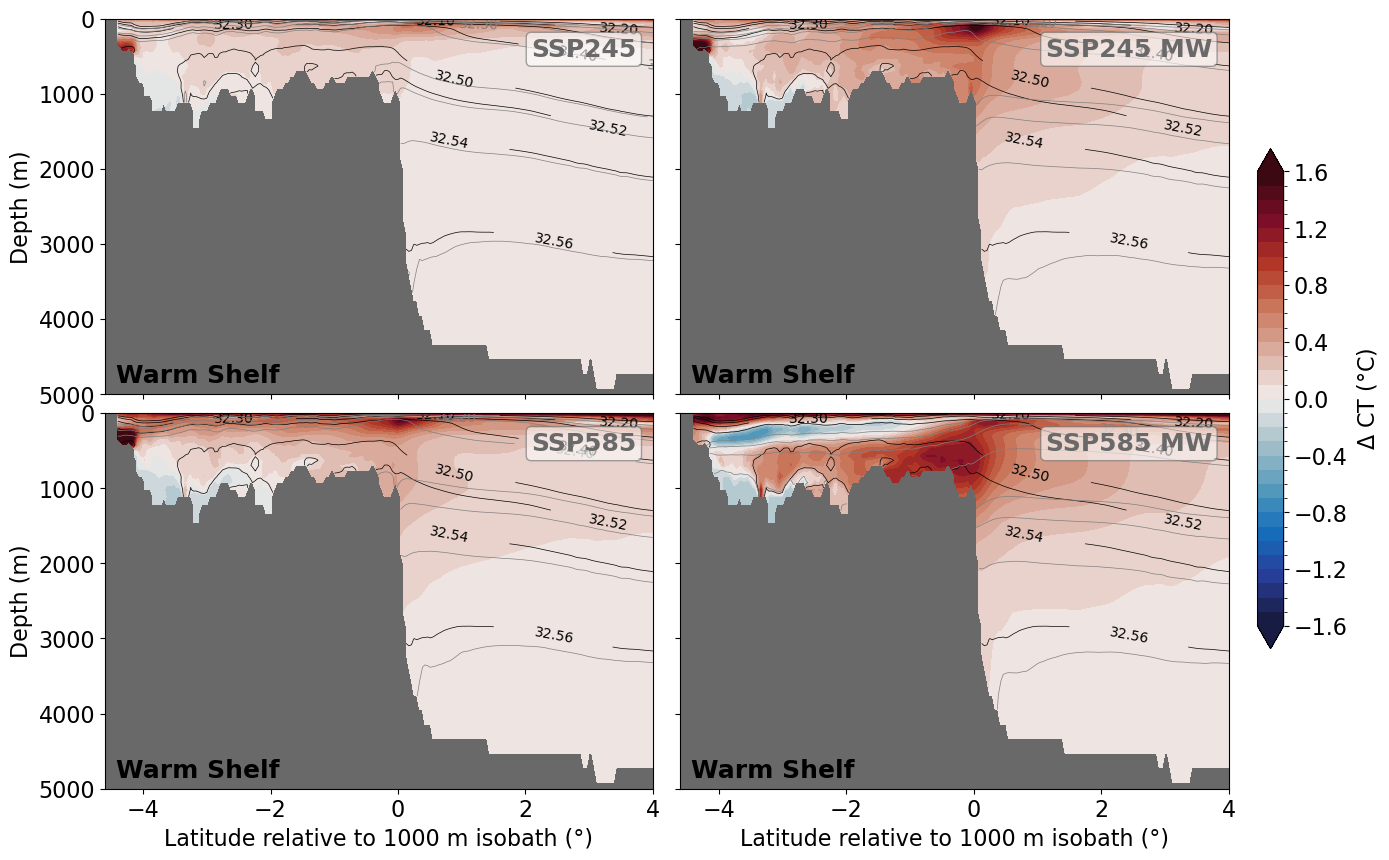

In [73]:
plt.rcParams.update({'font.size': 16})
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14.5,10), sharex=True, sharey=True)
plt.subplots_adjust(wspace=0.05, hspace=0.05)

axes[0,0].contourf(ssp245_mean.yt_isobath_rel, ssp245_mean.st_ocean, ssp245_mean - control_mean,
                   cmap=cmap, norm=mpl.colors.BoundaryNorm(levels,ncolors=cmap.N, clip=False), 
                   levels=levels, extend='both')
axes[0,1].contourf(ssp245mw_mean.yt_isobath_rel, ssp245mw_mean.st_ocean, ssp245mw_mean - control_mean,
                   cmap=cmap, norm=mpl.colors.BoundaryNorm(levels,ncolors=cmap.N, clip=False), 
                   levels=levels, extend='both')
axes[1,0].contourf(ssp585_mean.yt_isobath_rel, ssp585_mean.st_ocean, ssp585_mean - control_mean,
                   cmap=cmap, norm=mpl.colors.BoundaryNorm(levels,ncolors=cmap.N, clip=False), 
                   levels=levels, extend='both')
cb = axes[1,1].contourf(ssp585mw_mean.yt_isobath_rel, ssp585mw_mean.st_ocean, ssp585mw_mean - control_mean,
                   cmap=cmap, norm=mpl.colors.BoundaryNorm(levels,ncolors=cmap.N, clip=False), 
                   levels=levels, extend='both')
colorbar_vert(cb, [0.92, 0.25, 0.018, 0.5], '$\Delta$ CT (\u00b0C)')

# plot contours
lvls = np.concatenate((np.arange(32.1, 32.5, 0.1), np.arange(32.5,34,0.02)))
for i, ax in enumerate(axes.flatten()):
    cs = ax.contour(control_mean_sig1.yt_isobath_rel[:-200], control_mean_sig1.st_ocean, 
                    control_mean_sig1[:,:-200], levels=lvls, colors='k', linewidths=0.5, zorder=2)
    ax.clabel(cs, lvls,use_clabeltext=True, fontsize=10, zorder=2)
cs = axes[0,0].contour(ssp245_mean_sig1.yt_isobath_rel, ssp245_mean_sig1.st_ocean, 
                       ssp245_mean_sig1, levels=lvls, colors='grey', linewidths=0.5, zorder=2)
axes[0,0].clabel(cs, lvls,use_clabeltext=True, fontsize=10, zorder=2)
cs = axes[0,1].contour(ssp245mw_mean_sig1.yt_isobath_rel, ssp245mw_mean_sig1.st_ocean, 
                       ssp245mw_mean_sig1, levels=lvls, colors='grey', linewidths=0.5, zorder=2)
axes[0,1].clabel(cs, lvls,use_clabeltext=True, fontsize=10, zorder=2)
cs = axes[1,0].contour(ssp585_mean_sig1.yt_isobath_rel, ssp585_mean_sig1.st_ocean, 
                       ssp585_mean_sig1, levels=lvls, colors='grey', linewidths=0.5, zorder=2)
axes[1,0].clabel(cs, lvls,use_clabeltext=True, fontsize=10, zorder=2)
cs = axes[1,1].contour(ssp585mw_mean_sig1.yt_isobath_rel, ssp585mw_mean_sig1.st_ocean, 
                       ssp585mw_mean_sig1, levels=lvls, colors='grey', linewidths=0.5, zorder=2)
axes[1,1].clabel(cs, lvls,use_clabeltext=True, fontsize=10, zorder=2)


axes[0,0].invert_yaxis()
axes[0,0].set_ylim([5000,0])
axes[0,0].set_xlim([-4.6,4])
axes[0,0].set_facecolor('dimgrey')
axes[0,1].set_facecolor('dimgrey')
axes[1,0].set_facecolor('dimgrey')
axes[1,1].set_facecolor('dimgrey')

axes[0,0].set_ylabel('Depth (m)')
axes[1,0].set_ylabel('Depth (m)')
axes[1,0].set_xlabel('Latitude relative to 1000 m isobath (\u00b0)')
axes[1,1].set_xlabel('Latitude relative to 1000 m isobath (\u00b0)')

labels = ['SSP245','SSP245 MW','SSP585','SSP585 MW']
for i, ax in enumerate(axes.flatten()):
    ax.text(0.02, 0.03, f'Warm Shelf',  c='k', fontsize=18, ha='left', fontweight='bold', transform=ax.transAxes)
    ax.text(0.97, 0.9, f'{labels[i]}', fontsize=18, fontweight='bold', color='dimgrey', ha='right', transform=ax.transAxes,
            bbox=dict(facecolor='w', alpha=0.6, edgecolor='dimgrey', boxstyle='round,pad=0.2'))

# save to file
save_flag = 1
figfile = f'../figs/SuppFig_temp_anomaly_transect_isobath_adjusted_{region}.jpg'
if save_flag == 1:
    fig.savefig(figfile, bbox_inches='tight', dpi=300)


plt.show()

In [19]:
path = '/g/data/e14/hd4873/access-om2-01/project03_misc_data/isobath_aligned_transects/'
control = xr.open_dataset(path+'salt_control.nc')
ssp245 = xr.open_dataset(path+'salt_ssp245.nc')
ssp245mw = xr.open_dataset(path+'salt_ssp245mw.nc')
ssp585 = xr.open_dataset(path+'salt_ssp585.nc')
ssp585mw = xr.open_dataset(path+'salt_ssp585mw.nc')

control = control.__xarray_dataarray_variable__.rename('salt')
ssp245 = ssp245.__xarray_dataarray_variable__.rename('salt')
ssp245mw = ssp245mw.__xarray_dataarray_variable__.rename('salt')
ssp585 = ssp585.__xarray_dataarray_variable__.rename('salt')
ssp585mw = ssp585mw.__xarray_dataarray_variable__.rename('salt')

# density
control_sig1 = xr.open_dataset(path+'sigma1_control.nc')
ssp245_sig1 = xr.open_dataset(path+'sigma1_ssp245.nc')
ssp245mw_sig1 = xr.open_dataset(path+'sigma1_ssp245mw.nc')
ssp585_sig1 = xr.open_dataset(path+'sigma1_ssp585.nc')
ssp585mw_sig1 = xr.open_dataset(path+'sigma1_ssp585mw.nc')

control_sig1 = control_sig1.__xarray_dataarray_variable__.rename('sig1')
ssp245_sig1 = ssp245_sig1.__xarray_dataarray_variable__.rename('sig1')
ssp245mw_sig1 = ssp245mw_sig1.__xarray_dataarray_variable__.rename('sig1')
ssp585_sig1 = ssp585_sig1.__xarray_dataarray_variable__.rename('sig1')
ssp585mw_sig1 = ssp585mw_sig1.__xarray_dataarray_variable__.rename('sig1')

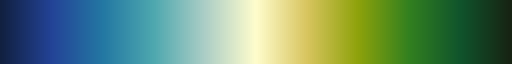

In [20]:
def colorbar_vert(cb, axes, label):
    fs = 16
    cbaxes = fig.add_axes(axes)
    cbar = plt.colorbar(cb, cax = cbaxes, orientation = 'vertical',extend = 'both')
    cbar.set_label(label,fontsize=fs,labelpad=6)
    #cbar.ax.tick_params(labelsize=fs, labeltop=True)
    return cbar

import matplotlib as mpl
from palettable.cmocean.diverging import Delta_11

cmap = plt.cm.get_cmap(Delta_11.mpl_colormap)
levels = np.arange(-0.5, 0.52, 0.02)
cmap.set_bad('k')
cmap

#### East Antarctica

In [21]:
%%time
region = 'east_antarctica'
l1 = -250
l2 = -280
l3 = 80

control_mean_plot = control.where(((control.xt_ocean < l1) & (control.xt_ocean >= l2) | (control.xt_ocean  > l3)), np.nan)
control_mean = control.where(((control.xt_ocean < l1) & (control.xt_ocean >= l2) | (control.xt_ocean  > l3)), np.nan).mean('xt_ocean')
ssp245_mean = ssp245.where(((control.xt_ocean < l1) & (control.xt_ocean >= l2) | (control.xt_ocean  > l3)), np.nan).mean('xt_ocean')
ssp245mw_mean = ssp245mw.where(((control.xt_ocean < l1) & (control.xt_ocean >= l2) | (control.xt_ocean  > l3)), np.nan).mean('xt_ocean')
ssp585_mean = ssp585.where(((control.xt_ocean < l1) & (control.xt_ocean >= l2) | (control.xt_ocean  > l3)), np.nan).mean('xt_ocean')
ssp585mw_mean = ssp585mw.where(((control.xt_ocean < l1) & (control.xt_ocean >= l2) | (control.xt_ocean  > l3)), np.nan).mean('xt_ocean')

# sigma1
control_mean_sig1 = control_sig1.where(((control.xt_ocean < l1) & (control.xt_ocean >= l2) | (control.xt_ocean  > l3)), np.nan).mean('xt_ocean')
ssp245_mean_sig1 = ssp245_sig1.where(((control.xt_ocean < l1) & (control.xt_ocean >= l2) | (control.xt_ocean  > l3)), np.nan).mean('xt_ocean')
ssp245mw_mean_sig1 = ssp245mw_sig1.where(((control.xt_ocean < l1) & (control.xt_ocean >= l2) | (control.xt_ocean  > l3)), np.nan).mean('xt_ocean')
ssp585_mean_sig1 = ssp585_sig1.where(((control.xt_ocean < l1) & (control.xt_ocean >= l2) | (control.xt_ocean  > l3)), np.nan).mean('xt_ocean')
ssp585mw_mean_sig1 = ssp585mw_sig1.where(((control.xt_ocean < l1) & (control.xt_ocean >= l2) | (control.xt_ocean  > l3)), np.nan).mean('xt_ocean')

CPU times: user 10.5 s, sys: 13.7 s, total: 24.2 s
Wall time: 30.5 s


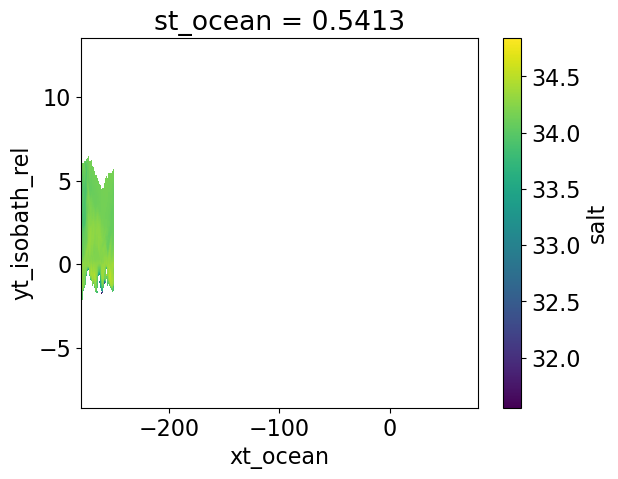

In [61]:
control_mean_plot.isel(st_ocean=0).plot(); plt.show()

Plot figure. 

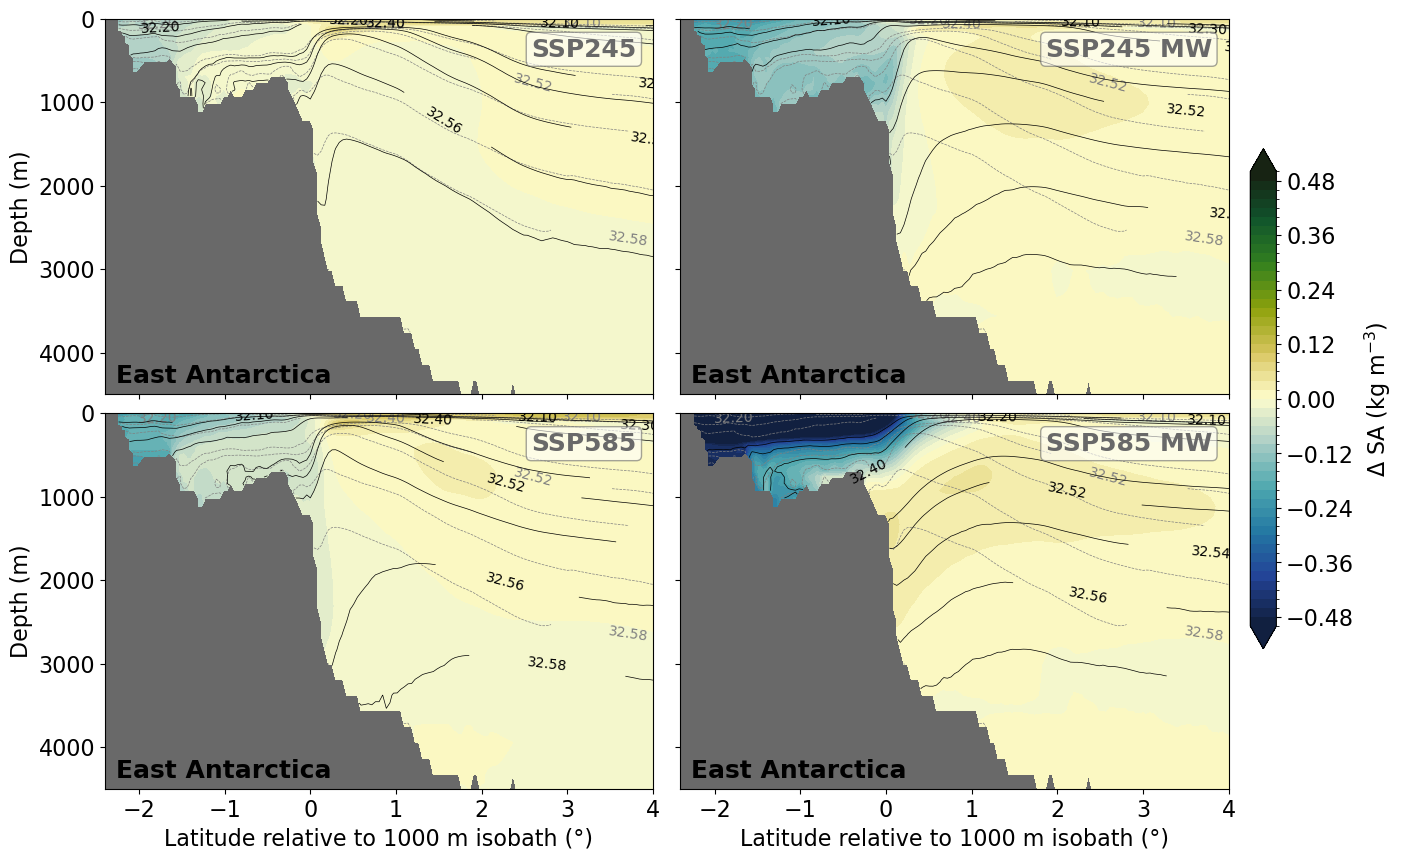

In [80]:
plt.rcParams.update({'font.size': 16})
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14.5,10), sharex=True, sharey=True)
plt.subplots_adjust(wspace=0.05, hspace=0.05)

cb = axes[0,0].contourf(ssp245_mean.yt_isobath_rel, ssp245_mean.st_ocean, ssp245_mean - control_mean,
                   cmap=cmap, norm=mpl.colors.BoundaryNorm(levels,ncolors=cmap.N, clip=False), 
                   levels=levels, extend='both')
axes[0,1].contourf(ssp245mw_mean.yt_isobath_rel, ssp245mw_mean.st_ocean, ssp245mw_mean - control_mean,
                   cmap=cmap, norm=mpl.colors.BoundaryNorm(levels,ncolors=cmap.N, clip=False), 
                   levels=levels, extend='both')
axes[1,0].contourf(ssp585_mean.yt_isobath_rel, ssp585_mean.st_ocean, ssp585_mean - control_mean,
                   cmap=cmap, norm=mpl.colors.BoundaryNorm(levels,ncolors=cmap.N, clip=False), 
                   levels=levels, extend='both')
axes[1,1].contourf(ssp585mw_mean.yt_isobath_rel, ssp585mw_mean.st_ocean, ssp585mw_mean - control_mean,
                   cmap=cmap, norm=mpl.colors.BoundaryNorm(levels,ncolors=cmap.N, clip=False), 
                   levels=levels, extend='both')

colorbar_vert(cb, [0.915, 0.25, 0.018, 0.5], '$\Delta$ SA (kg m$^{-3}$)')

# plot contours
lvls = np.concatenate((np.arange(32.1, 32.5, 0.1), np.arange(32.5,34,0.02)))
for i, ax in enumerate(axes.flatten()):
    cs = ax.contour(control_mean_sig1.yt_isobath_rel, control_mean_sig1.st_ocean, 
                    control_mean_sig1, levels=lvls, colors='grey', linewidths=0.5, linestyles='--', zorder=2)
    ax.clabel(cs, lvls,use_clabeltext=True, fontsize=10, zorder=2)
cs = axes[0,0].contour(ssp245_mean_sig1.yt_isobath_rel, ssp245_mean_sig1.st_ocean, 
                       ssp245_mean_sig1, levels=lvls, colors='k', linewidths=0.5, zorder=2)
axes[0,0].clabel(cs, lvls,use_clabeltext=True, fontsize=10, zorder=2)
cs = axes[0,1].contour(ssp245mw_mean_sig1.yt_isobath_rel, ssp245mw_mean_sig1.st_ocean, 
                       ssp245mw_mean_sig1, levels=lvls, colors='k', linewidths=0.5, zorder=2)
axes[0,1].clabel(cs, lvls,use_clabeltext=True, fontsize=10, zorder=2)
cs = axes[1,0].contour(ssp585_mean_sig1.yt_isobath_rel, ssp585_mean_sig1.st_ocean, 
                       ssp585_mean_sig1, levels=lvls, colors='k', linewidths=0.5, zorder=2)
axes[1,0].clabel(cs, lvls,use_clabeltext=True, fontsize=10, zorder=2)
cs = axes[1,1].contour(ssp585mw_mean_sig1.yt_isobath_rel, ssp585mw_mean_sig1.st_ocean, 
                       ssp585mw_mean_sig1, levels=lvls, colors='k', linewidths=0.5, zorder=2)
axes[1,1].clabel(cs, lvls,use_clabeltext=True, fontsize=10, zorder=2)

axes[0,0].invert_yaxis()
axes[0,0].set_ylim([4500,0])
axes[0,0].set_xlim([-2.4,4])
axes[0,0].set_facecolor('dimgrey')
axes[0,1].set_facecolor('dimgrey')
axes[1,0].set_facecolor('dimgrey')
axes[1,1].set_facecolor('dimgrey')

axes[0,0].set_ylabel('Depth (m)')
axes[1,0].set_ylabel('Depth (m)')
axes[1,0].set_xlabel('Latitude relative to 1000 m isobath (\u00b0)')
axes[1,1].set_xlabel('Latitude relative to 1000 m isobath (\u00b0)')

labels = ['SSP245','SSP245 MW','SSP585','SSP585 MW']
for i, ax in enumerate(axes.flatten()):
    ax.text(0.02, 0.03, f'East Antarctica',  c='k', fontsize=18, ha='left', fontweight='bold', transform=ax.transAxes)
    ax.text(0.97, 0.9, f'{labels[i]}', fontsize=18, fontweight='bold', color='dimgrey', ha='right', transform=ax.transAxes,
            bbox=dict(facecolor='w', alpha=0.6, edgecolor='dimgrey', boxstyle='round,pad=0.2'))

# save to file
save_flag = 1
figfile = f'../figs/SuppFig_salt_anomaly_transect_isobath_adjusted_{region}.jpg'
if save_flag == 1:
    fig.savefig(figfile, bbox_inches='tight', dpi=300)


plt.show()

In [22]:
%%time
region = 'east_antarctica'
l1 = -230
l2 = -250
l3 = 80

control_mean_plot = control.where(((control.xt_ocean < l1) & (control.xt_ocean >= l2) | (control.xt_ocean  > l3)), np.nan)
control_mean = control.where(((control.xt_ocean < l1) & (control.xt_ocean >= l2) | (control.xt_ocean  > l3)), np.nan).mean('xt_ocean')
ssp245_mean = ssp245.where(((control.xt_ocean < l1) & (control.xt_ocean >= l2) | (control.xt_ocean  > l3)), np.nan).mean('xt_ocean')
ssp245mw_mean = ssp245mw.where(((control.xt_ocean < l1) & (control.xt_ocean >= l2) | (control.xt_ocean  > l3)), np.nan).mean('xt_ocean')
ssp585_mean = ssp585.where(((control.xt_ocean < l1) & (control.xt_ocean >= l2) | (control.xt_ocean  > l3)), np.nan).mean('xt_ocean')
ssp585mw_mean = ssp585mw.where(((control.xt_ocean < l1) & (control.xt_ocean >= l2) | (control.xt_ocean  > l3)), np.nan).mean('xt_ocean')

# sigma1
control_mean_sig1 = control_sig1.where(((control.xt_ocean < l1) & (control.xt_ocean >= l2) | (control.xt_ocean  > l3)), np.nan).mean('xt_ocean')
ssp245_mean_sig1 = ssp245_sig1.where(((control.xt_ocean < l1) & (control.xt_ocean >= l2) | (control.xt_ocean  > l3)), np.nan).mean('xt_ocean')
ssp245mw_mean_sig1 = ssp245mw_sig1.where(((control.xt_ocean < l1) & (control.xt_ocean >= l2) | (control.xt_ocean  > l3)), np.nan).mean('xt_ocean')
ssp585_mean_sig1 = ssp585_sig1.where(((control.xt_ocean < l1) & (control.xt_ocean >= l2) | (control.xt_ocean  > l3)), np.nan).mean('xt_ocean')
ssp585mw_mean_sig1 = ssp585mw_sig1.where(((control.xt_ocean < l1) & (control.xt_ocean >= l2) | (control.xt_ocean  > l3)), np.nan).mean('xt_ocean')

CPU times: user 9.32 s, sys: 6.23 s, total: 15.6 s
Wall time: 14.5 s


Plot figure. 

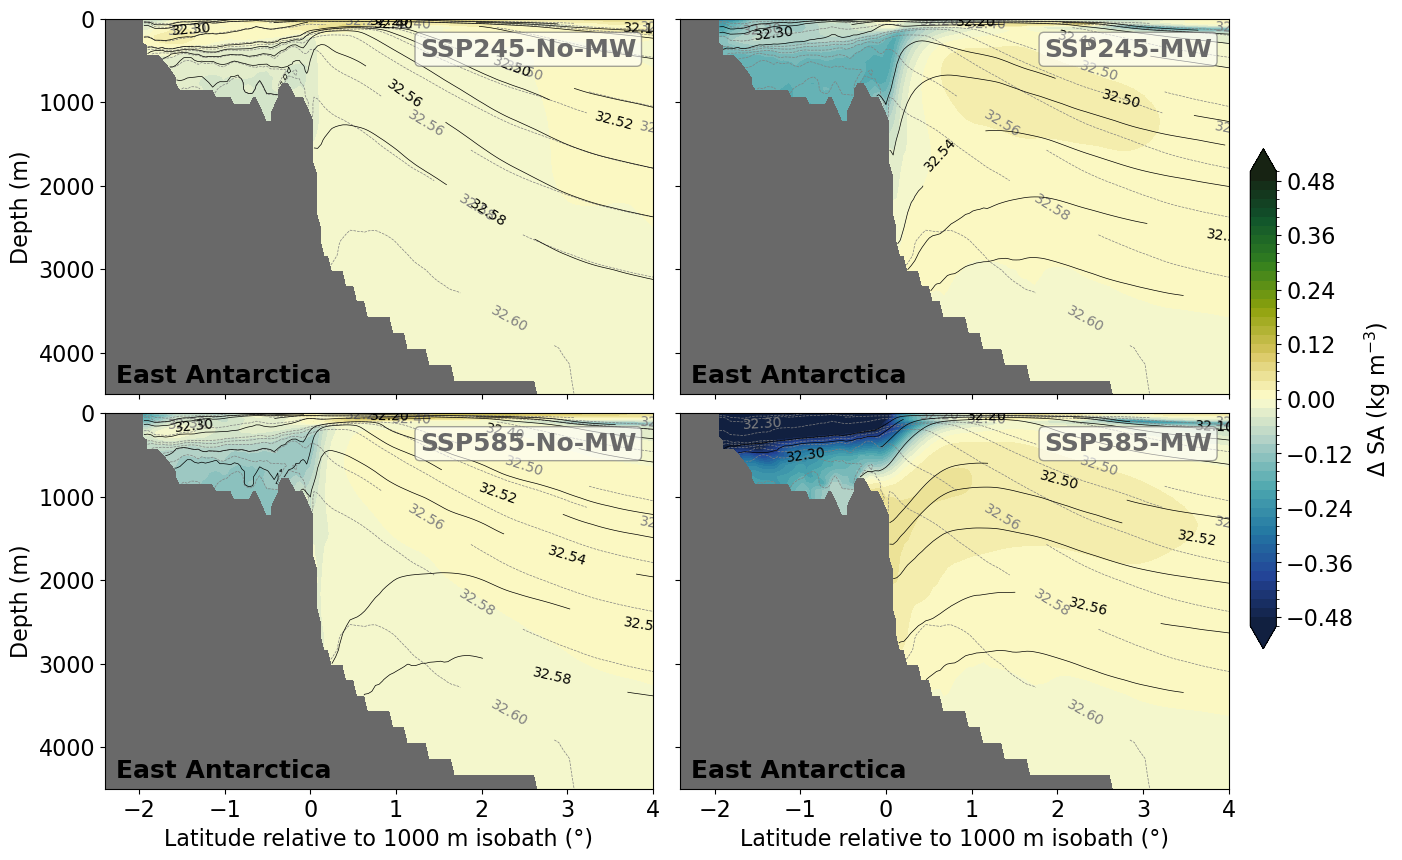

In [23]:
plt.rcParams.update({'font.size': 16})
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14.5,10), sharex=True, sharey=True)
plt.subplots_adjust(wspace=0.05, hspace=0.05)

cb = axes[0,0].contourf(ssp245_mean.yt_isobath_rel, ssp245_mean.st_ocean, ssp245_mean - control_mean,
                   cmap=cmap, norm=mpl.colors.BoundaryNorm(levels,ncolors=cmap.N, clip=False), 
                   levels=levels, extend='both')
axes[0,1].contourf(ssp245mw_mean.yt_isobath_rel, ssp245mw_mean.st_ocean, ssp245mw_mean - control_mean,
                   cmap=cmap, norm=mpl.colors.BoundaryNorm(levels,ncolors=cmap.N, clip=False), 
                   levels=levels, extend='both')
axes[1,0].contourf(ssp585_mean.yt_isobath_rel, ssp585_mean.st_ocean, ssp585_mean - control_mean,
                   cmap=cmap, norm=mpl.colors.BoundaryNorm(levels,ncolors=cmap.N, clip=False), 
                   levels=levels, extend='both')
axes[1,1].contourf(ssp585mw_mean.yt_isobath_rel, ssp585mw_mean.st_ocean, ssp585mw_mean - control_mean,
                   cmap=cmap, norm=mpl.colors.BoundaryNorm(levels,ncolors=cmap.N, clip=False), 
                   levels=levels, extend='both')

colorbar_vert(cb, [0.915, 0.25, 0.018, 0.5], '$\Delta$ SA (kg m$^{-3}$)')

# plot contours
lvls = np.concatenate((np.arange(32.1, 32.5, 0.1), np.arange(32.5,34,0.02)))
for i, ax in enumerate(axes.flatten()):
    cs = ax.contour(control_mean_sig1.yt_isobath_rel, control_mean_sig1.st_ocean, 
                    control_mean_sig1, levels=lvls, colors='grey', linewidths=0.5, linestyles='--', zorder=2)
    ax.clabel(cs, lvls,use_clabeltext=True, fontsize=10, zorder=2)
cs = axes[0,0].contour(ssp245_mean_sig1.yt_isobath_rel, ssp245_mean_sig1.st_ocean, 
                       ssp245_mean_sig1, levels=lvls, colors='k', linewidths=0.5, zorder=2)
axes[0,0].clabel(cs, lvls,use_clabeltext=True, fontsize=10, zorder=2)
cs = axes[0,1].contour(ssp245mw_mean_sig1.yt_isobath_rel, ssp245mw_mean_sig1.st_ocean, 
                       ssp245mw_mean_sig1, levels=lvls, colors='k', linewidths=0.5, zorder=2)
axes[0,1].clabel(cs, lvls,use_clabeltext=True, fontsize=10, zorder=2)
cs = axes[1,0].contour(ssp585_mean_sig1.yt_isobath_rel, ssp585_mean_sig1.st_ocean, 
                       ssp585_mean_sig1, levels=lvls, colors='k', linewidths=0.5, zorder=2)
axes[1,0].clabel(cs, lvls,use_clabeltext=True, fontsize=10, zorder=2)
cs = axes[1,1].contour(ssp585mw_mean_sig1.yt_isobath_rel, ssp585mw_mean_sig1.st_ocean, 
                       ssp585mw_mean_sig1, levels=lvls, colors='k', linewidths=0.5, zorder=2)
axes[1,1].clabel(cs, lvls,use_clabeltext=True, fontsize=10, zorder=2)

axes[0,0].invert_yaxis()
axes[0,0].set_ylim([4500,0])
axes[0,0].set_xlim([-2.4,4])
axes[0,0].set_facecolor('dimgrey')
axes[0,1].set_facecolor('dimgrey')
axes[1,0].set_facecolor('dimgrey')
axes[1,1].set_facecolor('dimgrey')

axes[0,0].set_ylabel('Depth (m)')
axes[1,0].set_ylabel('Depth (m)')
axes[1,0].set_xlabel('Latitude relative to 1000 m isobath (\u00b0)')
axes[1,1].set_xlabel('Latitude relative to 1000 m isobath (\u00b0)')

labels = ['SSP245-No-MW','SSP245-MW','SSP585-No-MW','SSP585-MW']
for i, ax in enumerate(axes.flatten()):
    ax.text(0.02, 0.03, f'East Antarctica',  c='k', fontsize=18, ha='left', fontweight='bold', transform=ax.transAxes)
    ax.text(0.97, 0.9, f'{labels[i]}', fontsize=18, fontweight='bold', color='dimgrey', ha='right', transform=ax.transAxes,
            bbox=dict(facecolor='w', alpha=0.6, edgecolor='dimgrey', boxstyle='round,pad=0.2'))

# save to file
save_flag = 1
figfile = f'../figs/SuppFig_salt_anomaly_transect_isobath_adjusted_{region}_110-130E.jpg'
if save_flag == 1:
    fig.savefig(figfile, bbox_inches='tight', dpi=300)


plt.show()

In [26]:
%%time
region = 'east_antarctica'
l1 = 50
l2 = 30
l3 = 80

control_mean_plot = control.where(((control.xt_ocean < l1) & (control.xt_ocean >= l2) | (control.xt_ocean  > l3)), np.nan)
control_mean = control.where(((control.xt_ocean < l1) & (control.xt_ocean >= l2) | (control.xt_ocean  > l3)), np.nan).mean('xt_ocean')
ssp245_mean = ssp245.where(((control.xt_ocean < l1) & (control.xt_ocean >= l2) | (control.xt_ocean  > l3)), np.nan).mean('xt_ocean')
ssp245mw_mean = ssp245mw.where(((control.xt_ocean < l1) & (control.xt_ocean >= l2) | (control.xt_ocean  > l3)), np.nan).mean('xt_ocean')
ssp585_mean = ssp585.where(((control.xt_ocean < l1) & (control.xt_ocean >= l2) | (control.xt_ocean  > l3)), np.nan).mean('xt_ocean')
ssp585mw_mean = ssp585mw.where(((control.xt_ocean < l1) & (control.xt_ocean >= l2) | (control.xt_ocean  > l3)), np.nan).mean('xt_ocean')

# sigma1
control_mean_sig1 = control_sig1.where(((control.xt_ocean < l1) & (control.xt_ocean >= l2) | (control.xt_ocean  > l3)), np.nan).mean('xt_ocean')
ssp245_mean_sig1 = ssp245_sig1.where(((control.xt_ocean < l1) & (control.xt_ocean >= l2) | (control.xt_ocean  > l3)), np.nan).mean('xt_ocean')
ssp245mw_mean_sig1 = ssp245mw_sig1.where(((control.xt_ocean < l1) & (control.xt_ocean >= l2) | (control.xt_ocean  > l3)), np.nan).mean('xt_ocean')
ssp585_mean_sig1 = ssp585_sig1.where(((control.xt_ocean < l1) & (control.xt_ocean >= l2) | (control.xt_ocean  > l3)), np.nan).mean('xt_ocean')
ssp585mw_mean_sig1 = ssp585mw_sig1.where(((control.xt_ocean < l1) & (control.xt_ocean >= l2) | (control.xt_ocean  > l3)), np.nan).mean('xt_ocean')

CPU times: user 9.29 s, sys: 6.2 s, total: 15.5 s
Wall time: 14.4 s


Plot figure. 

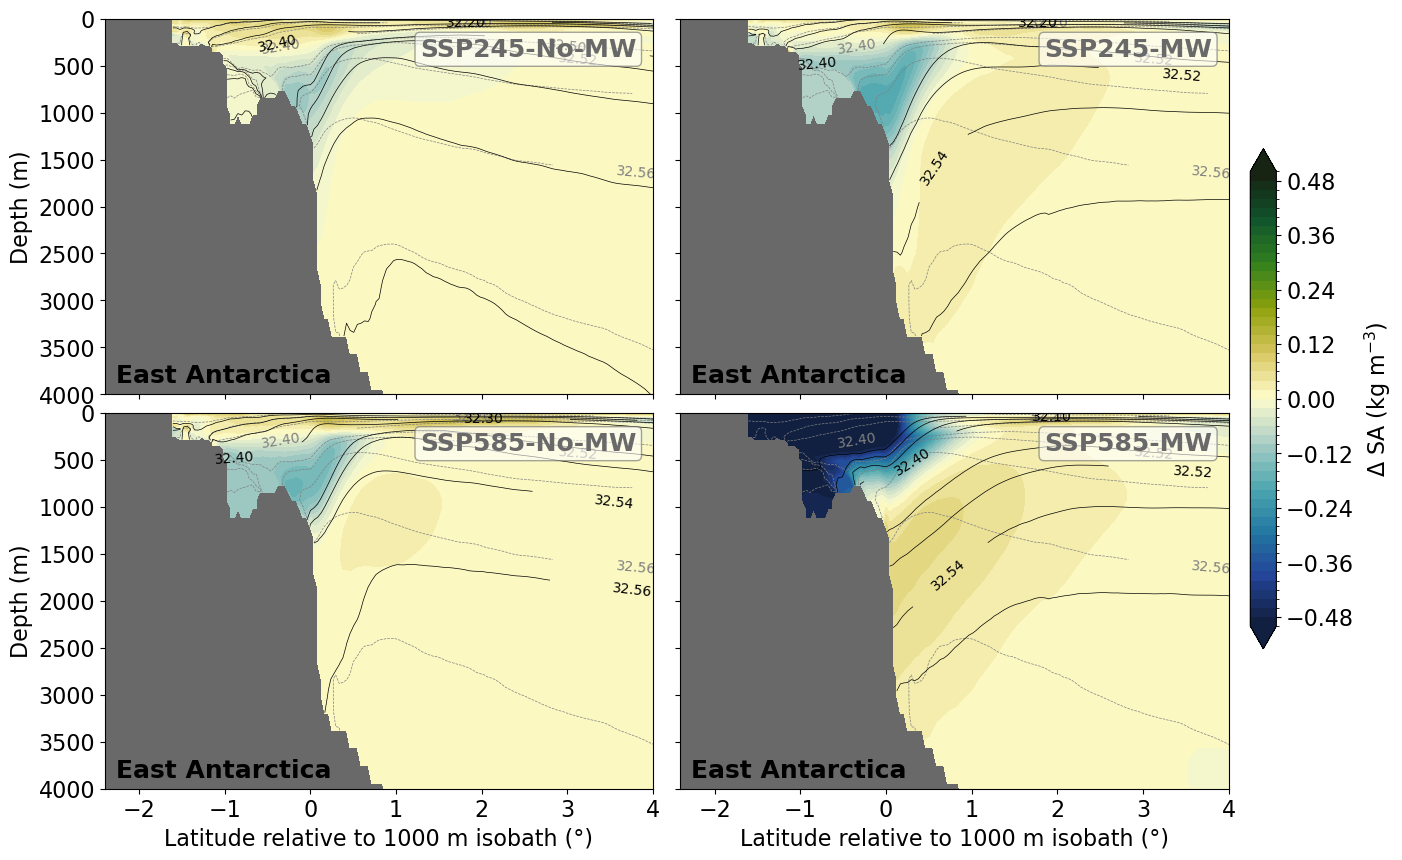

In [27]:
plt.rcParams.update({'font.size': 16})
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14.5,10), sharex=True, sharey=True)
plt.subplots_adjust(wspace=0.05, hspace=0.05)

cb = axes[0,0].contourf(ssp245_mean.yt_isobath_rel, ssp245_mean.st_ocean, ssp245_mean - control_mean,
                   cmap=cmap, norm=mpl.colors.BoundaryNorm(levels,ncolors=cmap.N, clip=False), 
                   levels=levels, extend='both')
axes[0,1].contourf(ssp245mw_mean.yt_isobath_rel, ssp245mw_mean.st_ocean, ssp245mw_mean - control_mean,
                   cmap=cmap, norm=mpl.colors.BoundaryNorm(levels,ncolors=cmap.N, clip=False), 
                   levels=levels, extend='both')
axes[1,0].contourf(ssp585_mean.yt_isobath_rel, ssp585_mean.st_ocean, ssp585_mean - control_mean,
                   cmap=cmap, norm=mpl.colors.BoundaryNorm(levels,ncolors=cmap.N, clip=False), 
                   levels=levels, extend='both')
axes[1,1].contourf(ssp585mw_mean.yt_isobath_rel, ssp585mw_mean.st_ocean, ssp585mw_mean - control_mean,
                   cmap=cmap, norm=mpl.colors.BoundaryNorm(levels,ncolors=cmap.N, clip=False), 
                   levels=levels, extend='both')

colorbar_vert(cb, [0.915, 0.25, 0.018, 0.5], '$\Delta$ SA (kg m$^{-3}$)')

# plot contours
lvls = np.concatenate((np.arange(32.1, 32.5, 0.1), np.arange(32.5,34,0.02)))
for i, ax in enumerate(axes.flatten()):
    cs = ax.contour(control_mean_sig1.yt_isobath_rel, control_mean_sig1.st_ocean, 
                    control_mean_sig1, levels=lvls, colors='grey', linewidths=0.5, linestyles='--', zorder=2)
    ax.clabel(cs, lvls,use_clabeltext=True, fontsize=10, zorder=2)
cs = axes[0,0].contour(ssp245_mean_sig1.yt_isobath_rel, ssp245_mean_sig1.st_ocean, 
                       ssp245_mean_sig1, levels=lvls, colors='k', linewidths=0.5, zorder=2)
axes[0,0].clabel(cs, lvls,use_clabeltext=True, fontsize=10, zorder=2)
cs = axes[0,1].contour(ssp245mw_mean_sig1.yt_isobath_rel, ssp245mw_mean_sig1.st_ocean, 
                       ssp245mw_mean_sig1, levels=lvls, colors='k', linewidths=0.5, zorder=2)
axes[0,1].clabel(cs, lvls,use_clabeltext=True, fontsize=10, zorder=2)
cs = axes[1,0].contour(ssp585_mean_sig1.yt_isobath_rel, ssp585_mean_sig1.st_ocean, 
                       ssp585_mean_sig1, levels=lvls, colors='k', linewidths=0.5, zorder=2)
axes[1,0].clabel(cs, lvls,use_clabeltext=True, fontsize=10, zorder=2)
cs = axes[1,1].contour(ssp585mw_mean_sig1.yt_isobath_rel, ssp585mw_mean_sig1.st_ocean, 
                       ssp585mw_mean_sig1, levels=lvls, colors='k', linewidths=0.5, zorder=2)
axes[1,1].clabel(cs, lvls,use_clabeltext=True, fontsize=10, zorder=2)

axes[0,0].invert_yaxis()
axes[0,0].set_ylim([4000,0])
axes[0,0].set_xlim([-2.,4])
axes[0,0].set_facecolor('dimgrey')
axes[0,1].set_facecolor('dimgrey')
axes[1,0].set_facecolor('dimgrey')
axes[1,1].set_facecolor('dimgrey')

axes[0,0].set_ylabel('Depth (m)')
axes[1,0].set_ylabel('Depth (m)')
axes[1,0].set_xlabel('Latitude relative to 1000 m isobath (\u00b0)')
axes[1,1].set_xlabel('Latitude relative to 1000 m isobath (\u00b0)')

labels = ['SSP245-No-MW','SSP245-MW','SSP585-No-MW','SSP585-MW']
for i, ax in enumerate(axes.flatten()):
    ax.text(0.02, 0.03, f'East Antarctica',  c='k', fontsize=18, ha='left', fontweight='bold', transform=ax.transAxes)
    ax.text(0.97, 0.9, f'{labels[i]}', fontsize=18, fontweight='bold', color='dimgrey', ha='right', transform=ax.transAxes,
            bbox=dict(facecolor='w', alpha=0.6, edgecolor='dimgrey', boxstyle='round,pad=0.2'))

# save to file
save_flag = 1
figfile = f'../figs/SuppFig_salt_anomaly_transect_isobath_adjusted_{region}_30-50E.jpg'
if save_flag == 1:
    fig.savefig(figfile, bbox_inches='tight', dpi=300)


plt.show()

#### Ross Sea

In [112]:
region = 'ross'
control_mean = control.where(((control.xt_ocean < -155) & ((control.xt_ocean  > -198))), np.nan).mean('xt_ocean')
ssp245_mean = ssp245.where(((ssp245.xt_ocean < -155) & ((ssp245.xt_ocean  > -198))), np.nan).mean('xt_ocean')
ssp245mw_mean = ssp245mw.where(((ssp245.xt_ocean < -155) & ((ssp245.xt_ocean  > -198))), np.nan).mean('xt_ocean')
ssp585_mean = ssp585.where(((ssp245.xt_ocean < -155) & ((ssp245.xt_ocean  > -198))), np.nan).mean('xt_ocean')
ssp585mw_mean = ssp585mw.where(((ssp245.xt_ocean < -155) & ((ssp245.xt_ocean  > -198))), np.nan).mean('xt_ocean')

Plot figure. 

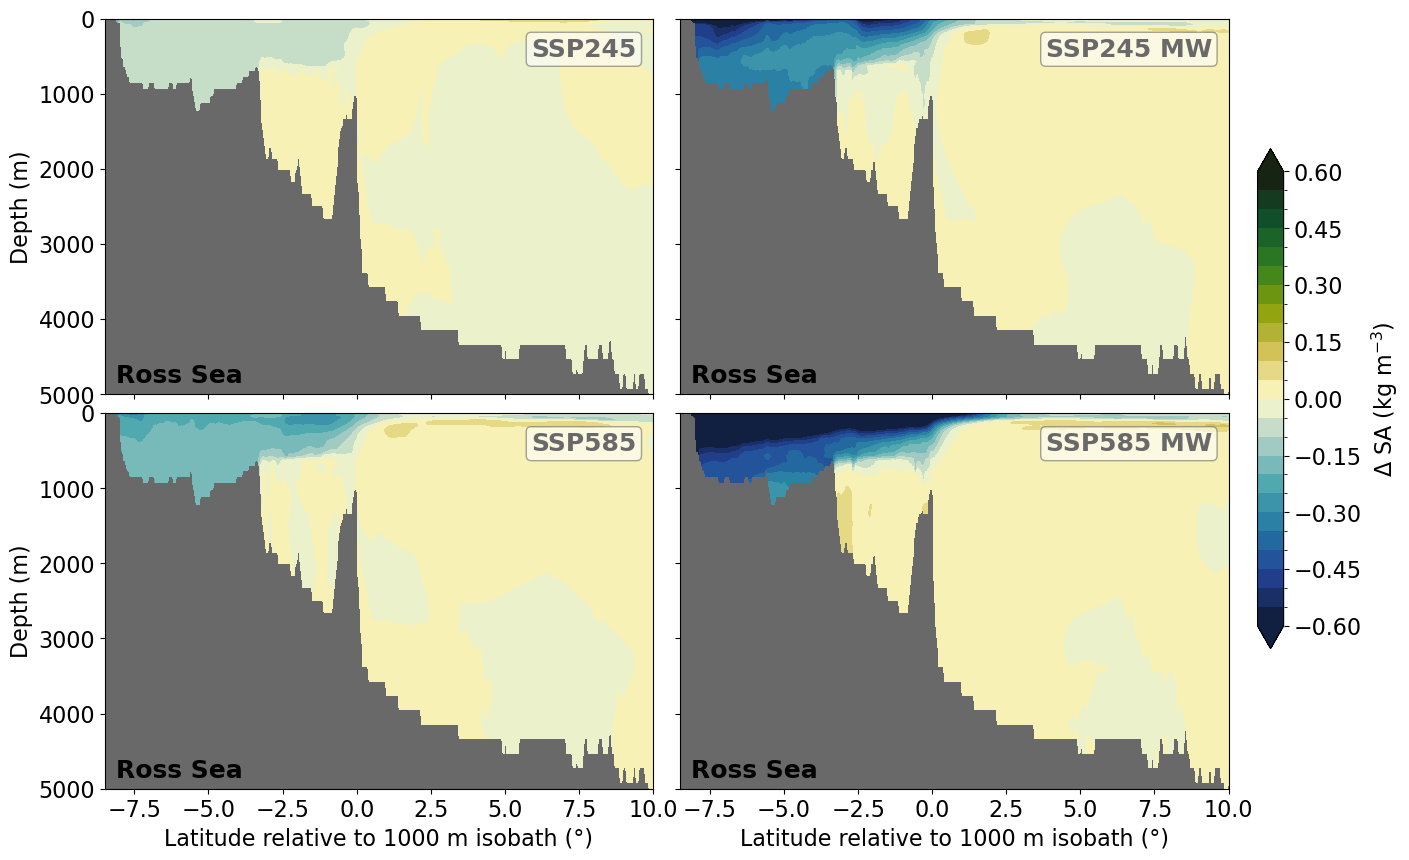

In [113]:
plt.rcParams.update({'font.size': 16})
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14.5,10), sharex=True, sharey=True)
plt.subplots_adjust(wspace=0.05, hspace=0.05)

axes[0,0].contourf(ssp245_mean.yt_isobath_rel, ssp245_mean.st_ocean, ssp245_mean - control_mean,
                   cmap=cmap, norm=mpl.colors.BoundaryNorm(levels,ncolors=cmap.N, clip=False), 
                   levels=levels, extend='both')
axes[0,1].contourf(ssp245mw_mean.yt_isobath_rel, ssp245mw_mean.st_ocean, ssp245mw_mean - control_mean,
                   cmap=cmap, norm=mpl.colors.BoundaryNorm(levels,ncolors=cmap.N, clip=False), 
                   levels=levels, extend='both')
axes[1,0].contourf(ssp585_mean.yt_isobath_rel, ssp585_mean.st_ocean, ssp585_mean - control_mean,
                   cmap=cmap, norm=mpl.colors.BoundaryNorm(levels,ncolors=cmap.N, clip=False), 
                   levels=levels, extend='both')
cb = axes[1,1].contourf(ssp585mw_mean.yt_isobath_rel, ssp585mw_mean.st_ocean, ssp585mw_mean - control_mean,
                   cmap=cmap, norm=mpl.colors.BoundaryNorm(levels,ncolors=cmap.N, clip=False), 
                   levels=levels, extend='both')

colorbar_vert(cb, [0.92, 0.25, 0.018, 0.5], '$\Delta$ SA (kg m$^{-3}$)')

axes[0,0].invert_yaxis()
axes[0,0].set_ylim([5000,0])
axes[0,0].set_xlim([-8.5,10])
axes[0,0].set_facecolor('dimgrey')
axes[0,1].set_facecolor('dimgrey')
axes[1,0].set_facecolor('dimgrey')
axes[1,1].set_facecolor('dimgrey')

axes[0,0].set_ylabel('Depth (m)')
axes[1,0].set_ylabel('Depth (m)')
axes[1,0].set_xlabel('Latitude relative to 1000 m isobath (\u00b0)')
axes[1,1].set_xlabel('Latitude relative to 1000 m isobath (\u00b0)')

labels = ['SSP245','SSP245 MW','SSP585','SSP585 MW']
for i, ax in enumerate(axes.flatten()):
    ax.text(0.02, 0.03, f'Ross Sea',  c='k', fontsize=18, ha='left', fontweight='bold', transform=ax.transAxes)
    ax.text(0.97, 0.9, f'{labels[i]}', fontsize=18, fontweight='bold', color='dimgrey', ha='right', transform=ax.transAxes,
            bbox=dict(facecolor='w', alpha=0.6, edgecolor='dimgrey', boxstyle='round,pad=0.2'))

# save to file
save_flag = 1
figfile = f'../figs/SuppFig_salt_anomaly_transect_isobath_adjusted_{region}.jpg'
if save_flag == 1:
    fig.savefig(figfile, bbox_inches='tight', dpi=300)


plt.show()

#### West Antarctica

In [96]:
region = 'west_antarctica'
l1 = -100
l2 = -140
control_mean = control.where(((control.xt_ocean < l1) & ((control.xt_ocean  > l2))), np.nan).mean('xt_ocean')
ssp245_mean = ssp245.where(((ssp245.xt_ocean < l1) & ((ssp245.xt_ocean  > l2))), np.nan).mean('xt_ocean')
ssp245mw_mean = ssp245mw.where(((ssp245.xt_ocean < l1) & ((ssp245.xt_ocean  > l2))), np.nan).mean('xt_ocean')
ssp585_mean = ssp585.where(((ssp245.xt_ocean < l1) & ((ssp245.xt_ocean  > l2))), np.nan).mean('xt_ocean')
ssp585mw_mean = ssp585mw.where(((ssp245.xt_ocean < l1) & ((ssp245.xt_ocean  > l2))), np.nan).mean('xt_ocean')

control_mean_sig1 = control_sig1.where(((control.xt_ocean < l1) & ((control.xt_ocean  > l2))), np.nan).mean('xt_ocean')
ssp245_mean_sig1 = ssp245_sig1.where(((ssp245.xt_ocean < l1) & ((ssp245.xt_ocean  > l2))), np.nan).mean('xt_ocean')
ssp245mw_mean_sig1 = ssp245mw_sig1.where(((ssp245.xt_ocean < l1) & ((ssp245.xt_ocean  > l2))), np.nan).mean('xt_ocean')
ssp585_mean_sig1 = ssp585_sig1.where(((ssp245.xt_ocean < l1) & ((ssp245.xt_ocean  > l2))), np.nan).mean('xt_ocean')
ssp585mw_mean_sig1 = ssp585mw_sig1.where(((ssp245.xt_ocean < l1) & ((ssp245.xt_ocean  > l2))), np.nan).mean('xt_ocean')

Plot figure. 

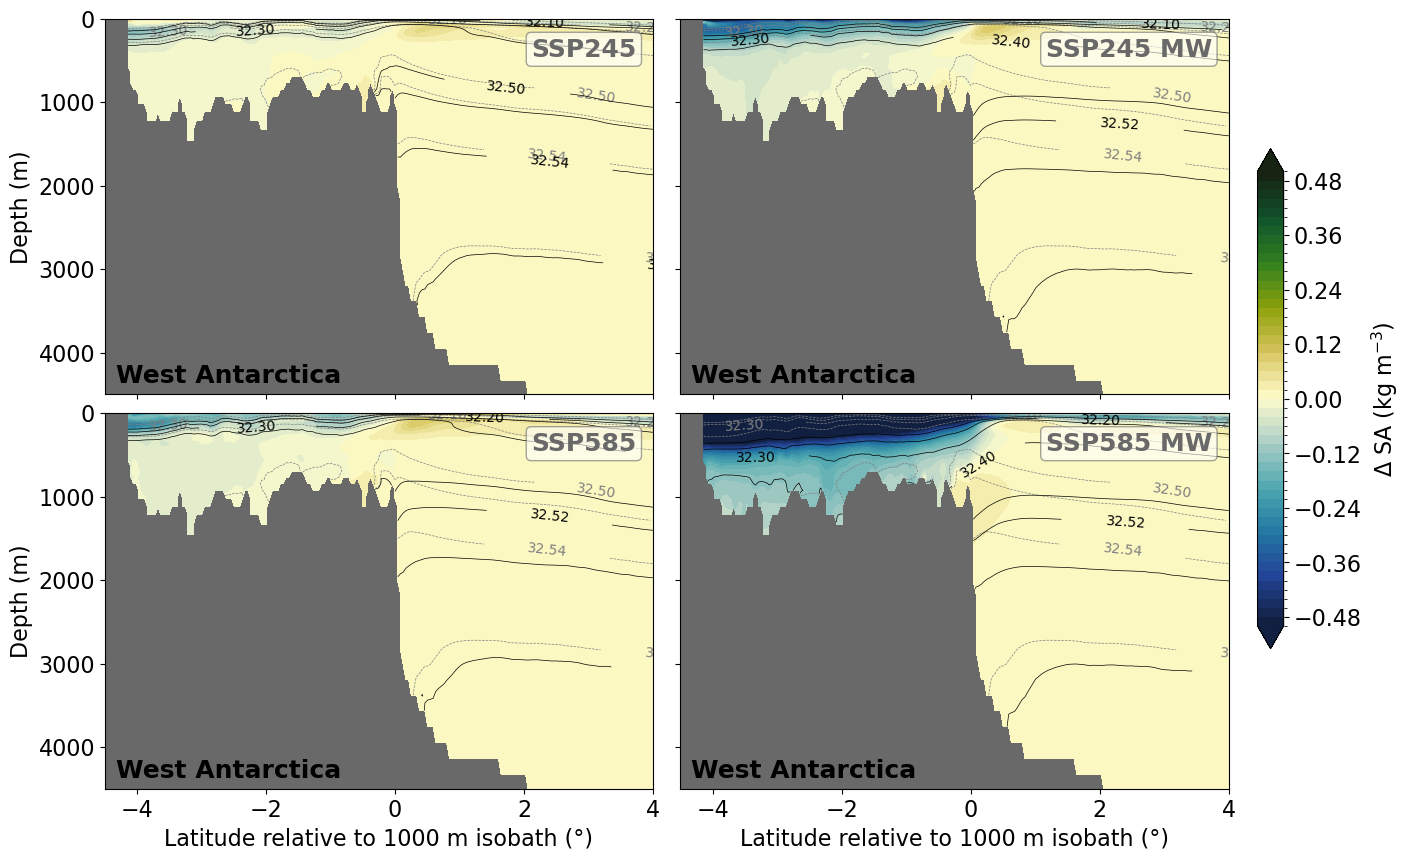

In [97]:
plt.rcParams.update({'font.size': 16})
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14.5,10), sharex=True, sharey=True)
plt.subplots_adjust(wspace=0.05, hspace=0.05)

axes[0,0].contourf(ssp245_mean.yt_isobath_rel, ssp245_mean.st_ocean, ssp245_mean - control_mean,
                   cmap=cmap, norm=mpl.colors.BoundaryNorm(levels,ncolors=cmap.N, clip=False), 
                   levels=levels, extend='both')
axes[0,1].contourf(ssp245mw_mean.yt_isobath_rel, ssp245mw_mean.st_ocean, ssp245mw_mean - control_mean,
                   cmap=cmap, norm=mpl.colors.BoundaryNorm(levels,ncolors=cmap.N, clip=False), 
                   levels=levels, extend='both')
axes[1,0].contourf(ssp585_mean.yt_isobath_rel, ssp585_mean.st_ocean, ssp585_mean - control_mean,
                   cmap=cmap, norm=mpl.colors.BoundaryNorm(levels,ncolors=cmap.N, clip=False), 
                   levels=levels, extend='both')
cb = axes[1,1].contourf(ssp585mw_mean.yt_isobath_rel, ssp585mw_mean.st_ocean, ssp585mw_mean - control_mean,
                   cmap=cmap, norm=mpl.colors.BoundaryNorm(levels,ncolors=cmap.N, clip=False), 
                   levels=levels, extend='both')

colorbar_vert(cb, [0.92, 0.25, 0.018, 0.5], '$\Delta$ SA (kg m$^{-3}$)')

# plot contours
lvls = np.concatenate((np.arange(32.1, 32.5, 0.1), np.arange(32.5,34,0.02)))
for i, ax in enumerate(axes.flatten()):
    cs = ax.contour(control_mean_sig1.yt_isobath_rel[:-150], control_mean_sig1.st_ocean, 
                    control_mean_sig1[:,:-150], levels=lvls, colors='grey', linewidths=0.5, linestyles='--', zorder=2)
    ax.clabel(cs, lvls,use_clabeltext=True, fontsize=10, zorder=2)
cs = axes[0,0].contour(ssp245_mean_sig1.yt_isobath_rel[:-150], ssp245_mean_sig1.st_ocean, 
                       ssp245_mean_sig1[:,:-150], levels=lvls, colors='k', linewidths=0.5, zorder=2)
axes[0,0].clabel(cs, lvls,use_clabeltext=True, fontsize=10, zorder=2)
cs = axes[0,1].contour(ssp245mw_mean_sig1.yt_isobath_rel[:-150], ssp245mw_mean_sig1.st_ocean, 
                       ssp245mw_mean_sig1[:,:-150], levels=lvls, colors='k', linewidths=0.5, zorder=2)
axes[0,1].clabel(cs, lvls,use_clabeltext=True, fontsize=10, zorder=2)
cs = axes[1,0].contour(ssp585_mean_sig1.yt_isobath_rel[:-150], ssp585_mean_sig1.st_ocean, 
                       ssp585_mean_sig1[:,:-150], levels=lvls, colors='k', linewidths=0.5, zorder=2)
axes[1,0].clabel(cs, lvls,use_clabeltext=True, fontsize=10, zorder=2)
cs = axes[1,1].contour(ssp585mw_mean_sig1.yt_isobath_rel[:-150], ssp585mw_mean_sig1.st_ocean, 
                       ssp585mw_mean_sig1[:,:-150], levels=lvls, colors='k', linewidths=0.5, zorder=2)
axes[1,1].clabel(cs, lvls,use_clabeltext=True, fontsize=10, zorder=2)

axes[0,0].invert_yaxis()
axes[0,0].set_ylim([4500,0])
axes[0,0].set_xlim([-4.5,4])
axes[0,0].set_facecolor('dimgrey')
axes[0,1].set_facecolor('dimgrey')
axes[1,0].set_facecolor('dimgrey')
axes[1,1].set_facecolor('dimgrey')

axes[0,0].set_ylabel('Depth (m)')
axes[1,0].set_ylabel('Depth (m)')
axes[1,0].set_xlabel('Latitude relative to 1000 m isobath (\u00b0)')
axes[1,1].set_xlabel('Latitude relative to 1000 m isobath (\u00b0)')

labels = ['SSP245','SSP245 MW','SSP585','SSP585 MW']
for i, ax in enumerate(axes.flatten()):
    ax.text(0.02, 0.03, f'West Antarctica',  c='k', fontsize=18, ha='left', fontweight='bold', transform=ax.transAxes)
    ax.text(0.97, 0.9, f'{labels[i]}', fontsize=18, fontweight='bold', color='dimgrey', ha='right', transform=ax.transAxes,
            bbox=dict(facecolor='w', alpha=0.6, edgecolor='dimgrey', boxstyle='round,pad=0.2'))

# save to file
save_flag = 1
figfile = f'../figs/SuppFig_salt_anomaly_transect_isobath_adjusted_{region}.jpg'
if save_flag == 1:
    fig.savefig(figfile, bbox_inches='tight', dpi=300)


plt.show()

#### Weddell Sea

In [108]:
region = 'weddell'
control_mean = control.where(((control.xt_ocean < -15) & ((control.xt_ocean  > -65))), np.nan).mean('xt_ocean')
ssp245_mean = ssp245.where(((ssp245.xt_ocean < -15) & ((ssp245.xt_ocean  > -65))), np.nan).mean('xt_ocean')
ssp245mw_mean = ssp245mw.where(((ssp245.xt_ocean < -15) & ((ssp245.xt_ocean  > -65))), np.nan).mean('xt_ocean')
ssp585_mean = ssp585.where(((ssp245.xt_ocean < -15) & ((ssp245.xt_ocean  > -65))), np.nan).mean('xt_ocean')
ssp585mw_mean = ssp585mw.where(((ssp245.xt_ocean < -15) & ((ssp245.xt_ocean  > -65))), np.nan).mean('xt_ocean')

Plot figure. 

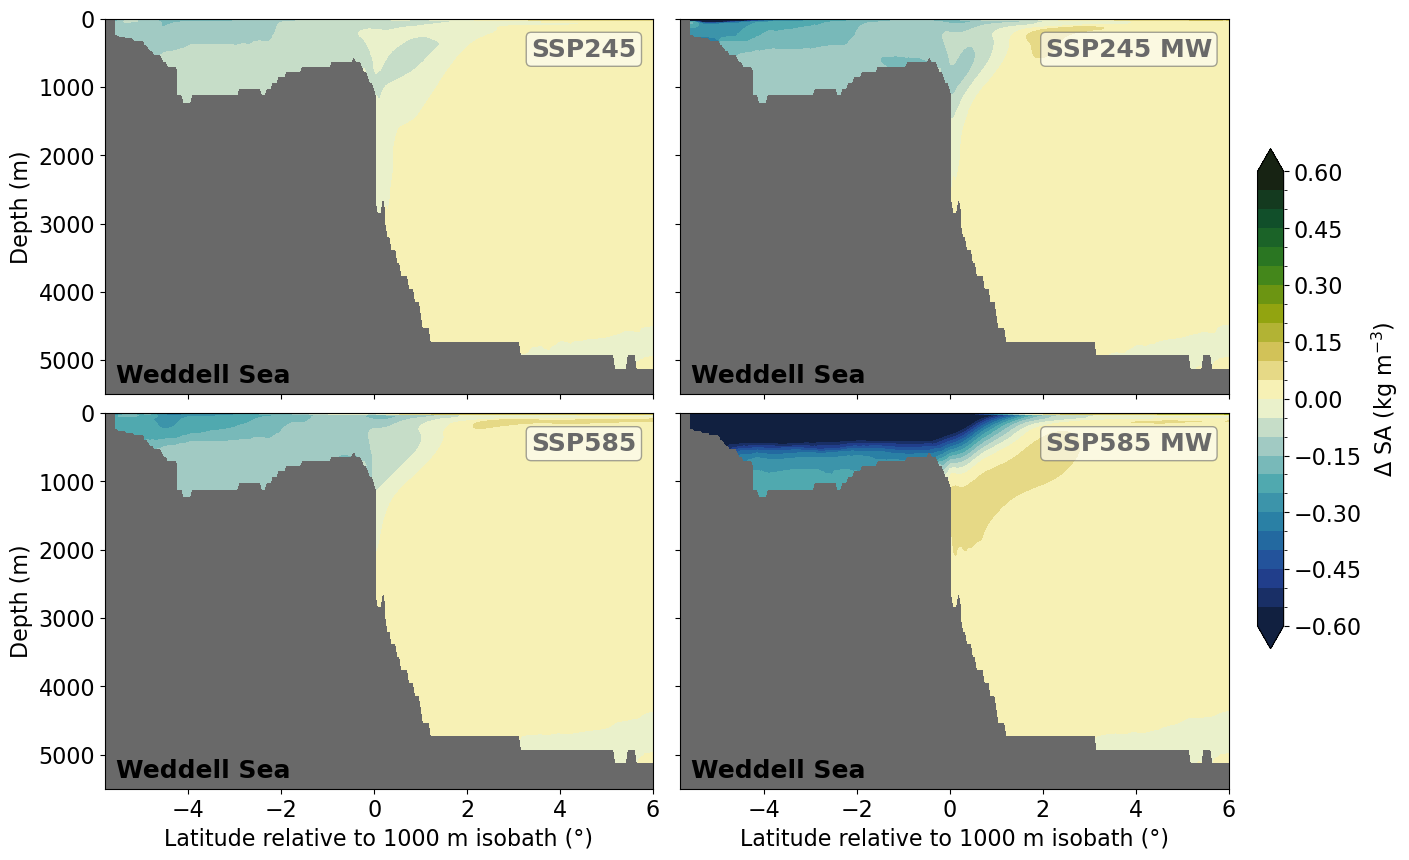

In [110]:
plt.rcParams.update({'font.size': 16})
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14.5,10), sharex=True, sharey=True)
plt.subplots_adjust(wspace=0.05, hspace=0.05)

axes[0,0].contourf(ssp245_mean.yt_isobath_rel, ssp245_mean.st_ocean, ssp245_mean - control_mean,
                   cmap=cmap, norm=mpl.colors.BoundaryNorm(levels,ncolors=cmap.N, clip=False), 
                   levels=levels, extend='both')
axes[0,1].contourf(ssp245mw_mean.yt_isobath_rel, ssp245mw_mean.st_ocean, ssp245mw_mean - control_mean,
                   cmap=cmap, norm=mpl.colors.BoundaryNorm(levels,ncolors=cmap.N, clip=False), 
                   levels=levels, extend='both')
axes[1,0].contourf(ssp585_mean.yt_isobath_rel, ssp585_mean.st_ocean, ssp585_mean - control_mean,
                   cmap=cmap, norm=mpl.colors.BoundaryNorm(levels,ncolors=cmap.N, clip=False), 
                   levels=levels, extend='both')
cb = axes[1,1].contourf(ssp585mw_mean.yt_isobath_rel, ssp585mw_mean.st_ocean, ssp585mw_mean - control_mean,
                   cmap=cmap, norm=mpl.colors.BoundaryNorm(levels,ncolors=cmap.N, clip=False), 
                   levels=levels, extend='both')

colorbar_vert(cb, [0.92, 0.25, 0.018, 0.5], '$\Delta$ SA (kg m$^{-3}$)')

axes[0,0].invert_yaxis()
axes[0,0].set_ylim([5500,0])
axes[0,0].set_xlim([-5.8,6])
axes[0,0].set_facecolor('dimgrey')
axes[0,1].set_facecolor('dimgrey')
axes[1,0].set_facecolor('dimgrey')
axes[1,1].set_facecolor('dimgrey')

axes[0,0].set_ylabel('Depth (m)')
axes[1,0].set_ylabel('Depth (m)')
axes[1,0].set_xlabel('Latitude relative to 1000 m isobath (\u00b0)')
axes[1,1].set_xlabel('Latitude relative to 1000 m isobath (\u00b0)')

labels = ['SSP245','SSP245 MW','SSP585','SSP585 MW']
for i, ax in enumerate(axes.flatten()):
    ax.text(0.02, 0.03, f'Weddell Sea',  c='k', fontsize=18, ha='left', fontweight='bold', transform=ax.transAxes)
    ax.text(0.97, 0.9, f'{labels[i]}', fontsize=18, fontweight='bold', color='dimgrey', ha='right', transform=ax.transAxes,
            bbox=dict(facecolor='w', alpha=0.6, edgecolor='dimgrey', boxstyle='round,pad=0.2'))

# save to file
save_flag = 1
figfile = f'../figs/SuppFig_salt_anomaly_transect_isobath_adjusted_{region}.jpg'
if save_flag == 1:
    fig.savefig(figfile, bbox_inches='tight', dpi=300)


plt.show()